In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

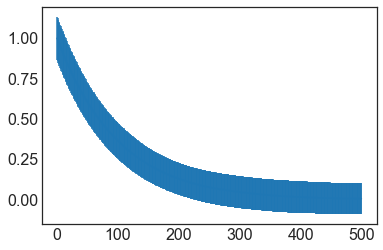

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

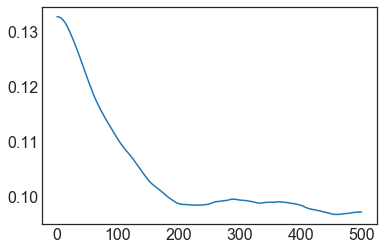

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    decay:      101.268683 +/- 1.05611196 (1.04%) (init = 100)
    amplitude:  0.79842691 +/- 0.0066952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50323777
    reduced chi-square = 0.00101052
    Akaike info crit   = -3446.65031
    Bayesian info crit = -3438.22109
[[Variables]]
    decay:      87.2221101 +/- 0.93297412 (1.07%) (init = 100)
    amplitude:  0.89560519 +/- 0.00673196 (0.75%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 49.8390885
    reduced chi-square = 0.10007849
    Akaike info crit   = -1148.90426
    Bayesian info crit = -1140.47504
[[Variables]]
    decay:      89.0557996 +/- 1.04579870 (1.17%) (init = 100)
    amplitude:  0.88443477 +/- 0.00832459 (0.94%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.68424510
    reduced chi-square = 0.00338202
    Akaike info crit   = -2842.64532
    Bayesian info crit = -2834.21611
[[Variables]]
    decay:      123.270611 +/- 1.98965666 (1.61%) (init = 100)
    amplitude:  0.92341146 +/- 0.01043219 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 168.378697
    reduced chi-square = 0.33810983
    Akaike info crit   = -540.196255
    Bayesian info crit = -531.767039
[[Variables]]
    decay:      128.373717 +/- 2.26829234 (1.77%) (init = 100)
    amplitude:  0.89432236 +/- 0.01265064 (1.41%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 41.1930583
    reduced chi-square = 0.08271698
    Akaike info crit   = -1244.16917
    Bayesian info crit = -1235.73996
[[Variables]]
    decay:      75.2255612 +/- 0.86980389 (1.16%) (init = 100)
    amplitude:  0.89938149 +/- 0.00826934 (0.92%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  94  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.19924361
    reduced chi-square = 0.00240812
    Akaike info crit   = -3012.45853
    Bayesian info crit = -3004.02932
[[Variables]]
    decay:      156.531576 +/- 1.56866577 (1.00%) (init = 100)
    amplitude:  1.14450699 +/- 0.007899

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 353.332123
    reduced chi-square = 0.70950225
    Akaike info crit   = -169.599813
    Bayesian info crit = -161.170597
[[Variables]]
    decay:      59.4766544 +/- 1.77934387 (2.99%) (init = 100)
    amplitude:  1.16940803 +/- 0.02737389 (2.34%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  129  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 5.58167116
    reduced chi-square = 0.01120818
    Akaike info crit   = -2243.55994
    Bayesian info crit = -2235.13072
[[Variables]]
    decay:      99.5936929 +/- 3.00114857 (3.01%) (init = 100)
    amplitude:  0.99286295 +/- 0.02102

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 526.867794
    reduced chi-square = 1.05796746
    Akaike info crit   = 30.1707769
    Bayesian info crit = 38.5999931
[[Variables]]
    decay:      63.5484996 +/- 2.58582844 (4.07%) (init = 100)
    amplitude:  1.00932453 +/- 0.03229745 (3.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  163  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64686608
    reduced chi-square = 0.00330696
    Akaike info crit   = -2853.86698
    Bayesian info crit = -2845.43777
[[Variables]]
    decay:      92.4369609 +/- 1.58293937 (1.71%) (init = 100)
    amplitude:  0.98384338 +/- 0.0118396

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.09457354
    reduced chi-square = 1.8991e-04
    Akaike info crit   = -4282.49285
    Bayesian info crit = -4274.06363
[[Variables]]
    decay:      146.624243 +/- 0.35716103 (0.24%) (init = 100)
    amplitude:  1.35255268 +/- 0.00228310 (0.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 9.25379076
    reduced chi-square = 0.01858191
    Akaike info crit   = -1990.78741
    Bayesian info crit = -1982.35819
[[Variables]]
    decay:      146.274578 +/- 0.37827846 (0.26%) (init = 100)
    amplitude:  1.35572371 +/- 0.00277768 (0.20%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62866777
    reduced chi-square = 0.00126239
    Akaike info crit   = -3335.38022
    Bayesian info crit = -3326.95101
[[Variables]]
    decay:      182.298703 +/- 2.13539678 (1.17%) (init = 100)
    amplitude:  0.67912839 +/- 0.00536381 (0.79%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.721

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 50.1916680
    reduced chi-square = 0.10078648
    Akaike info crit   = -1145.37953
    Bayesian info crit = -1136.95031
[[Variables]]
    decay:      190.415040 +/- 2.18476605 (1.15%) (init = 100)
    amplitude:  0.65741983 +/- 0.00571394 (0.87%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 122.973246
    reduced chi-square = 0.24693423
    Akaike info crit   = -697.320639
    Bayesian info crit = -688.891423
[[Variables]]
    decay:      80.2426052 +/- 1.30231760 (1.62%) (init = 100)
    amplitude:  1.06653227 +/- 0.01381191 (1.30%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.714

***** Iteration  267  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.27513009
    reduced chi-square = 5.5247e-04
    Akaike info crit   = -3748.55967
    Bayesian info crit = -3740.13046
[[Variables]]
    decay:      94.9528628 +/- 0.70339691 (0.74%) (init = 100)
    amplitude:  0.91752480 +/- 0.00477

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 4.74272777
    reduced chi-square = 0.00952355
    Akaike info crit   = -2324.99783
    Bayesian info crit = -2316.56861
[[Variables]]
    decay:      131.767583 +/- 3.69628410 (2.81%) (init = 100)
    amplitude:  0.86682661 +/- 0.01697190 (1.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 445.560014
    reduced chi-square = 0.89469882
    Akaike info crit   = -53.6380748
    Bayesian info crit = -45.2088586
[[Variables]]
    decay:      154.590343 +/- 4.74423511 (3.07%) (init = 100)
    amplitude:  0.77652944 +/- 0.01876089 (2.42%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 56.1488577
    reduced chi-square = 0.11274871
    Akaike info crit   = -1089.30088
    Bayesian info crit = -1080.87166
[[Variables]]
    decay:      96.0948599 +/- 1.02616826 (1.07%) (init = 100)
    amplitude:  0.98965220 +/- 0.00849007 (0.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.721

***** Iteration  338  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.90736901
    reduced chi-square = 0.00182203
    Akaike info crit   = -3151.90708
    Bayesian info crit = -3143.47787
[[Variables]]
    decay:      122.324991 +/- 1.38654625 (1.13%) (init = 100)
    amplitude:  0.96841390 +/- 0.00768

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 399.219891
    reduced chi-square = 0.80164637
    Akaike info crit   = -108.547864
    Bayesian info crit = -100.118647
[[Variables]]
    decay:      57.8944414 +/- 2.32631644 (4.02%) (init = 100)
    amplitude:  0.94055905 +/- 0.02950513 (3.14%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  372  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 5.88921361
    reduced chi-square = 0.01182573
    Akaike info crit   = -2216.74281
    Bayesian info crit = -2208.31360
[[Variables]]
    decay:      148.624684 +/- 2.93680858 (1.98%) (init = 100)
    amplitude:  1.30926012 +/- 0.01790

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.08861759
    reduced chi-square = 0.00620204
    Akaike info crit   = -2539.44225
    Bayesian info crit = -2531.01303
[[Variables]]
    decay:      75.1474349 +/- 1.58956708 (2.12%) (init = 100)
    amplitude:  1.20705652 +/- 0.01793064 (1.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 296.611559
    reduced chi-square = 0.59560554
    Akaike info crit   = -257.092348
    Bayesian info crit = -248.663132
[[Variables]]
    decay:      72.0463279 +/- 1.66257510 (2.31%) (init = 100)
    amplitude:  1.24017176 +/- 0.02269656 (1.83%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 635.518075
    reduced chi-square = 1.27614071
    Akaike info crit   = 123.916217
    Bayesian info crit = 132.345433
[[Variables]]
    decay:      107.841155 +/- 3.04450021 (2.82%) (init = 100)
    amplitude:  1.18402951 +/- 0.02689205 (2.27%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.725

***** Iteration  442  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.13824886
    reduced chi-square = 0.00429367
    Akaike info crit   = -2723.31045
    Bayesian info crit = -2714.88123
[[Variables]]
    decay:      109.700796 +/- 2.21921267 (2.02%) (init = 100)
    amplitude:  0.87469750 +/- 0.0124224

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.38502559
    reduced chi-square = 0.00278118
    Akaike info crit   = -2940.44474
    Bayesian info crit = -2932.01553
[[Variables]]
    decay:      103.460726 +/- 1.31772698 (1.27%) (init = 100)
    amplitude:  1.14927232 +/- 0.01028250 (0.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 144.207311
    reduced chi-square = 0.28957291
    Akaike info crit   = -617.678088
    Bayesian info crit = -609.248872
[[Variables]]
    decay:      102.768633 +/- 1.45040566 (1.41%) (init = 100)
    amplitude:  1.15730803 +/- 0.01313586 (1.14%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 211.044810
    reduced chi-square = 0.42378476
    Akaike info crit   = -427.268809
    Bayesian info crit = -418.839592
[[Variables]]
    decay:      179.788066 +/- 3.07081590 (1.71%) (init = 100)
    amplitude:  0.91743712 +/- 0.01202443 (1.31%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.753

***** Iteration  513  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.17435614
    reduced chi-square = 0.00235814
    Akaike info crit   = -3022.94404
    Bayesian info crit = -3014.51482
[[Variables]]
    decay:      89.4522446 +/- 1.08493490 (1.21%) (init = 100)
    amplitude:  1.19182343 +/- 0.01015

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 172.245578
    reduced chi-square = 0.34587465
    Akaike info crit   = -528.843432
    Bayesian info crit = -520.414215
[[Variables]]
    decay:      146.091305 +/- 2.35568465 (1.61%) (init = 100)
    amplitude:  0.93850081 +/- 0.01199137 (1.28%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.739

***** Iteration  548  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.13759555
    reduced chi-square = 2.7630e-04
    Akaike info crit   = -4095.02240
    Bayesian info crit = -4086.59318
[[Variables]]
    decay:      154.318344 +/- 0.61073001 (0.40%) (init = 100)
    amplitude:  0.98631927 +/- 0.00269

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.12200913
    reduced chi-square = 0.00426106
    Akaike info crit   = -2727.12238
    Bayesian info crit = -2718.69316
[[Variables]]
    decay:      160.901731 +/- 2.96259666 (1.84%) (init = 100)
    amplitude:  0.82130992 +/- 0.01038307 (1.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.715

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 179.679626
    reduced chi-square = 0.36080246
    Akaike info crit   = -507.716344
    Bayesian info crit = -499.287128
[[Variables]]
    decay:      175.563410 +/- 3.30938808 (1.89%) (init = 100)
    amplitude:  0.77177362 +/- 0.01121678 (1.45%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.52356957
    reduced chi-square = 0.00105134
    Akaike info crit   = -3426.84673
    Bayesian info crit = -3418.41751
[[Variables]]
    decay:      95.1210658 +/- 0.62479051 (0.66%) (init = 100)
    amplitude:  1.42629330 +/- 0.00658388 (0.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 52.9638715
    reduced chi-square = 0.10635316
    Akaike info crit   = -1118.49904
    Bayesian info crit = -1110.06983
[[Variables]]
    decay:      94.5476451 +/- 0.68413249 (0.72%) (init = 100)
    amplitude:  1.43122965 +/- 0.00831622 (0.58%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 5.37279450
    reduced chi-square = 0.01078874
    Akaike info crit   = -2262.62997
    Bayesian info crit = -2254.20075
[[Variables]]
    decay:      71.9346806 +/- 2.14181573 (2.98%) (init = 100)
    amplitude:  1.15523617 +/- 0.02415959 (2.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 528.866725
    reduced chi-square = 1.06198138
    Akaike info crit   = 32.0641822
    Bayesian info crit = 40.4933984
[[Variables]]
    decay:      69.0290212 +/- 2.27531185 (3.30%) (init = 100)
    amplitude:  1.18895274 +/- 0.03099096 (2.61%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 35.5431597
    reduced chi-square = 0.07137181
    Akaike info crit   = -1317.93019
    Bayesian info crit = -1309.50097
[[Variables]]
    decay:      101.469500 +/- 0.85840176 (0.85%) (init = 100)
    amplitude:  0.96511850 +/- 0.00656483 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  687  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.82489891
    reduced chi-square = 0.00165642
    Akaike info crit   = -3199.55126
    Bayesian info crit = -3191.12205
[[Variables]]
    decay:      155.706863 +/- 1.61860316 (1.04%) (init = 100)
    amplitude:  0.91661976 +/- 0.00656

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 22.3820901
    reduced chi-square = 0.04494396
    Akaike info crit   = -1549.17350
    Bayesian info crit = -1540.74429
[[Variables]]
    decay:      164.353778 +/- 0.88064809 (0.54%) (init = 100)
    amplitude:  0.97681590 +/- 0.00408297 (0.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.747

***** Iteration  723  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.29426175
    reduced chi-square = 0.00460695
    Akaike info crit   = -2688.09849
    Bayesian info crit = -2679.66928
[[Variables]]
    decay:      132.513058 +/- 2.63053148 (1.99%) (init = 100)
    amplitude:  0.85002945 +/- 0.01177

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.38839298
    reduced chi-square = 0.00278794
    Akaike info crit   = -2939.23058
    Bayesian info crit = -2930.80136
[[Variables]]
    decay:      82.6712160 +/- 1.32645276 (1.60%) (init = 100)
    amplitude:  1.01795125 +/- 0.01147735 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 144.224749
    reduced chi-square = 0.28960793
    Akaike info crit   = -617.617629
    Bayesian info crit = -609.188413
[[Variables]]
    decay:      81.8708212 +/- 1.47860027 (1.81%) (init = 100)
    amplitude:  1.02594262 +/- 0.01480166 (1.44%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.52252366
    reduced chi-square = 0.00305728
    Akaike info crit   = -2893.11942
    Bayesian info crit = -2884.69020
[[Variables]]
    decay:      217.204764 +/- 3.16187205 (1.46%) (init = 100)
    amplitude:  0.82572791 +/- 0.00779965 (0.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.731

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 133.153331
    reduced chi-square = 0.26737617
    Akaike info crit   = -657.553386
    Bayesian info crit = -649.124170
[[Variables]]
    decay:      230.261801 +/- 3.49120914 (1.52%) (init = 100)
    amplitude:  0.79045546 +/- 0.00858624 (1.09%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.38587811
    reduced chi-square = 0.00479092
    Akaike info crit   = -2668.52043
    Bayesian info crit = -2660.09121
[[Variables]]
    decay:      94.2948420 +/- 1.75996648 (1.87%) (init = 100)
    amplitude:  1.07595485 +/- 0.01411442 (1.31%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 236.362612
    reduced chi-square = 0.47462372
    Akaike info crit   = -370.620490
    Bayesian info crit = -362.191274
[[Variables]]
    decay:      91.8044471 +/- 1.85584208 (2.02%) (init = 100)
    amplitude:  1.10006815 +/- 0.01784135 (1.62%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 489.617850
    reduced chi-square = 0.98316837
    Akaike info crit   = -6.49145527
    Bayesian info crit = 1.93776093
[[Variables]]
    decay:      83.6916421 +/- 2.81647392 (3.37%) (init = 100)
    amplitude:  1.00167161 +/- 0.02696018 (2.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.716

***** Iteration  859  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 3.71475081
    reduced chi-square = 0.00745934
    Akaike info crit   = -2447.14825
    Bayesian info crit = -2438.71903
[[Variables]]
    decay:      75.6150959 +/- 2.14054896 (2.83%) (init = 100)
    amplitude:  0.98613411 +/- 0.019605

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 128.972328
    reduced chi-square = 0.25898058
    Akaike info crit   = -673.505115
    Bayesian info crit = -665.075899
[[Variables]]
    decay:      70.7613547 +/- 1.12175769 (1.59%) (init = 100)
    amplitude:  1.20307101 +/- 0.01510770 (1.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

***** Iteration  895  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.23127350
    reduced chi-square = 4.6440e-04
    Akaike info crit   = -3835.38120
    Bayesian info crit = -3826.95198
[[Variables]]
    decay:      89.2711478 +/- 0.58778277 (0.66%) (init = 100)
    amplitude:  0.97520202 +/- 0.00451

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.58048560
    reduced chi-square = 0.00116563
    Akaike info crit   = -3375.24919
    Bayesian info crit = -3366.81997
[[Variables]]
    decay:      125.803925 +/- 1.26517943 (1.01%) (init = 100)
    amplitude:  0.86253368 +/- 0.00606636 (0.70%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 57.7675806
    reduced chi-square = 0.11599916
    Akaike info crit   = -1075.09018
    Bayesian info crit = -1066.66097
[[Variables]]
    decay:      127.802231 +/- 1.39005838 (1.09%) (init = 100)
    amplitude:  0.85275569 +/- 0.00742661 (0.87%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.76831362
    reduced chi-square = 0.00154280
    Akaike info crit   = -3235.08269
    Bayesian info crit = -3226.65347
[[Variables]]
    decay:      108.076080 +/- 1.04853835 (0.97%) (init = 100)
    amplitude:  1.10102014 +/- 0.00749942 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 77.3905624
    reduced chi-square = 0.15540274
    Akaike info crit   = -928.871629
    Bayesian info crit = -920.442413
[[Variables]]
    decay:      106.799004 +/- 1.12535395 (1.05%) (init = 100)
    amplitude:  1.11285561 +/- 0.00943117 (0.85%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 76.2594540
    reduced chi-square = 0.15313143
    Akaike info crit   = -936.233352
    Bayesian info crit = -927.804136
[[Variables]]
    decay:      114.486146 +/- 1.60147397 (1.40%) (init = 100)
    amplitude:  0.80305845 +/- 0.00902973 (1.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.727

***** Iteration  995  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 3.58343623
    reduced chi-square = 0.00719566
    Akaike info crit   = -2465.14296
    Bayesian info crit = -2456.71374
[[Variables]]
    decay:      112.595293 +/- 2.25210654 (2.00%) (init = 100)
    amplitude:  1.13187274 +/- 0.01588

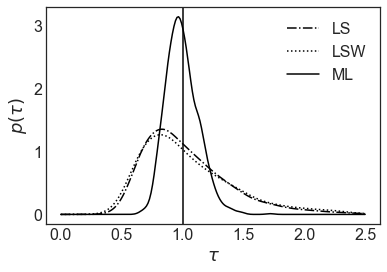

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

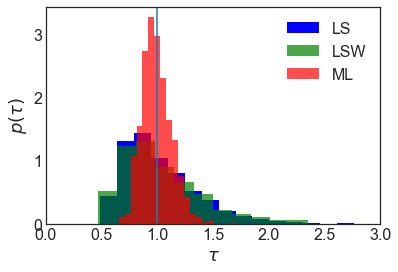

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


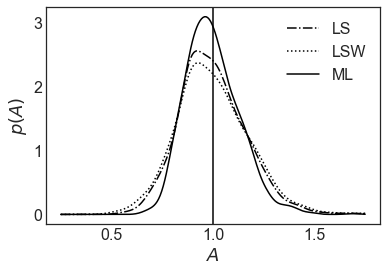

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

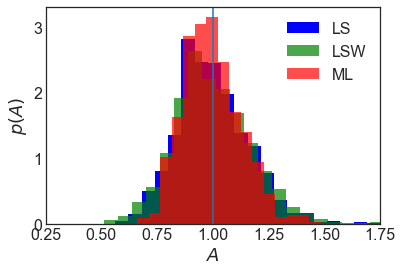

In [14]:
# amplitude
plt.hist(result_array.T[2],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 4.692624086158618
Amplitude LSW std (real): 8.3673321023892
Amplitude LSW stderr (real): 0.08367332102389201
Amplitude LSW std (fit): 0.9950832668790089
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.548446448599749e-25)


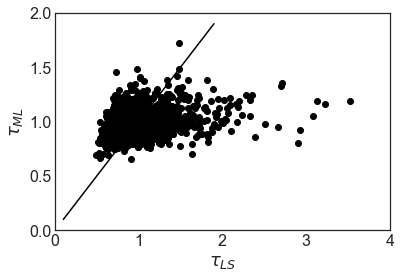

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767423, 1.3727086902427204e-263)


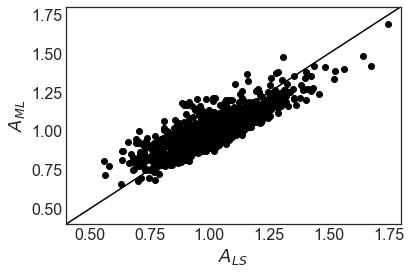

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.00544211158822298 0.9939418654806541 0.009520460345979705
1 0.7384507401780944 0.014800775155431269 1.659481283174133 0.04862577555746138
2 0.8189945390255113 0.008341269650960773 1.2161571144605954 0.017689000724257463
3 1.177426213439023 0.008512380556837134 0.869670623699744 0.008946273247059084
4 1.0437891737470233 0.014007021533873081 0.6674355511975543 0.012763371773673647
5 0.883051617048809 0.00858219052936581 0.7431840677695469 0.010284184173800653
6 0.9986686993248759 0.005205087905933227 0.8289406605407509 0.006148559498558599
7 0.8705609103632095 0.007324202103499727 1.2761723469792459 0.015361640341763991
8 1.0469415961904982 0.004889410637600746 1.0666728821039506 0.0070945098128067305
9 0.8705229773500358 0.005136756260122944 1.404644623697107 0.011921526795272194
10 1.210331143970472 0.021603434174906247 0.6449979054220899 0.01641139632324621
11 1.0678373545348654 0.012159441384276045 1.5898917788383589 0.02633043239929993
12 1.0466327034058365 0.0

656 1.0419611587831445 0.010706304584901134 0.6016159816963211 0.008814440906433869
657 1.3796906367257336 0.02222836263394379 0.701316109097676 0.01609135223724567
658 1.0016502579041822 0.0196156387040846 0.6052074257861851 0.01690327110643452
659 0.8068790536838826 0.01054494900882596 1.209396393375598 0.02256727351677917
660 0.8448943450381698 0.008104959206695895 0.5985731767133358 0.00818731340133432
661 1.425040936832656 0.017156454556700167 0.8211897195886859 0.0140687801472775
662 0.9792009851114964 0.011699141806397096 0.6683429612381256 0.011377033103454235
663 1.1043645708874874 0.010658960854813097 0.815656013010224 0.011202964241582554
664 1.0718439886361044 0.01633558504317089 0.8307712651697817 0.018019844322990988
665 1.0101628959444144 0.009785476078363185 1.1163078044779504 0.015409466846674937
666 0.9449476385226756 0.01353094102886937 0.7002314306188846 0.014283221469951495
667 0.8350402235908381 0.005394747890803705 0.8595852550244348 0.007902538829889031
668 0.89

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

0.00E+00
-79527971.70080663
0.3989422804014327
2.59E-01
-0.18841818509930627
(500,)


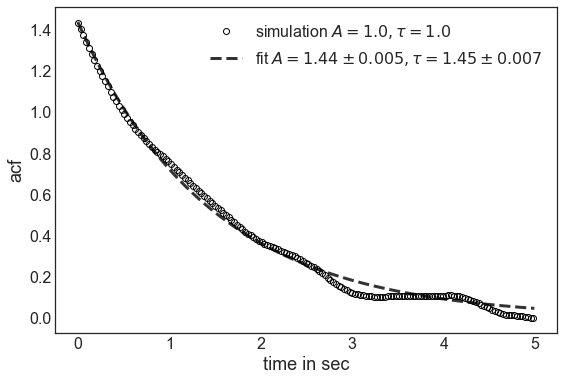

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

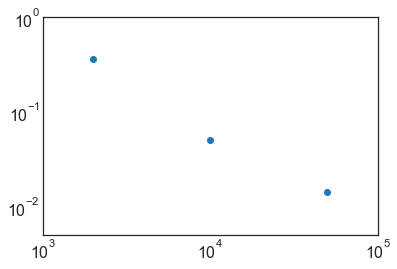

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

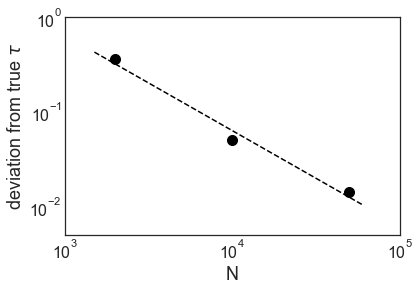

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6495.27draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8821892986367268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928747261180717, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.42550,0.165325,0.001527,1.104235,1.750168,11862.288995,1.000158
tau,1.50492,0.257030,0.002503,1.038776,2.022413,11788.033747,1.000245


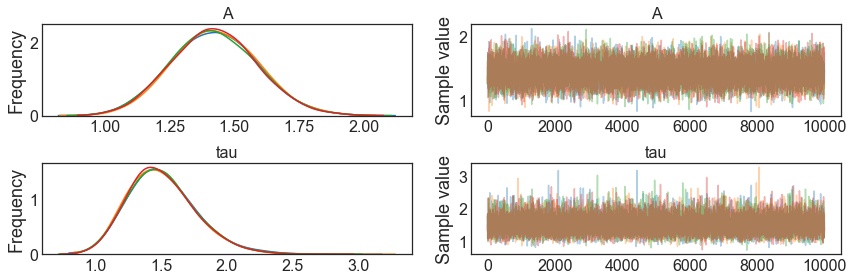

In [42]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=20)
    tau = pm.Uniform('tau', lower=0, upper=20)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1,observed=acf)
    
    trace = pm.sample(10000)
    
pm.traceplot(trace)
pm.summary(trace)

[1.11177882 1.2595415  1.31197546 1.42242958 1.53615596 1.58980757
 1.75991898]
[1.0738816  1.2539616  1.3239866  1.47996668 1.65808397 1.75405001
 2.07449456]
A_sigma 0.1651330333016402
tau_sigma 0.25004420724964826


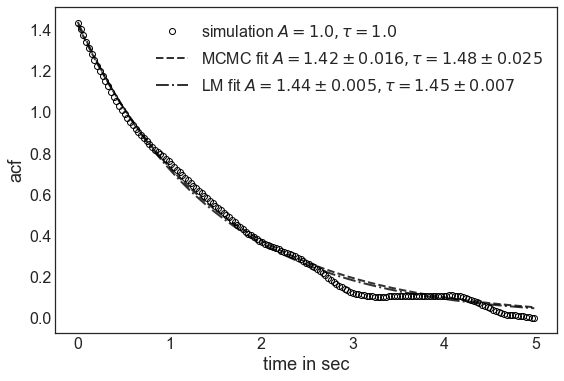

In [52]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['tau'].mean()),"k--",linewidth=2,label=r"MCMC fit $A=1.42\pm0.016,\tau=1.48\pm0.025$",alpha=0.8)
plt.plot(t[::3],fit[::3],"k-.",linewidth=2,label=r"LM fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300MCMC.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

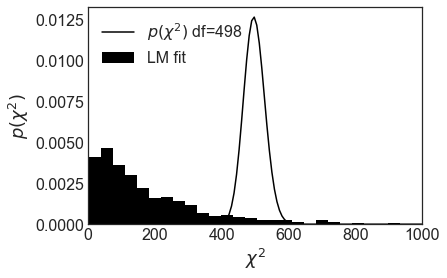

In [66]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=50,color="k",density=True,label="LM fit")
plt.plot(x,chi2dist,color="k",label=r"$p(\chi^{2})$ df=498")
plt.xlim((0,1000))
plt.ylabel(r"$p(\chi^{2})$")
plt.xlabel(r"$\chi^2$")
plt.legend(loc="upper left")
plt.savefig("chi2dist.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [31]:
result_array.T[11].mean()

192.78086697829272

In [32]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=20)
        tau = pm.Uniform('tau', lower=0, upper=20)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1,observed=y)
    
        trace = pm.sample(10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
    print(A_perc)
    print(tau_perc)
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5980.30draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8927453247168854, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39832679 0.57027679 0.63270688 0.76390251 0.90681704 0.98132628
 1.23041627]
[0.49815288 0.73504333 0.83371382 1.07453403 1.40164332 1.60287326
 2.57497668]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5292.92draws/s]
The acceptance probability does not match the target. It is 0.9027184654290263, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32055392 0.47686842 0.53643571 0.66457259 0.80956716 0.88087063
 1.12100323]
[ 0.78875857  1.22611437  1.42515991  1.98133583  2.87988815  3.58557845
 10.0024456 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6140.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40795481 0.58231947 0.64396096 0.77318195 0.91352211 0.98642136
 1.21744579]
[0.61807482 0.90365668 1.02263699 1.32530828 1.74741568 2.02027387
 3.48088913]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.98draws/s]
The acceptance probability does not match the target. It is 0.9094660382062918, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878636157385171, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76312174 0.94327113 1.00888362 1.1437352  1.28808209 1.36078646
 1.58216173]
[0.55193496 0.70323896 0.76434694 0.90334988 1.06969128 1.16487406
 1.49909189]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6187.08draws/s]


[0.59447948 0.7875928  0.85709494 1.00507161 1.16273682 1.24204476
 1.49528831]
[0.3811583  0.51998124 0.57351716 0.69905215 0.85313411 0.9412916
 1.29212666]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6032.34draws/s]
The acceptance probability does not match the target. It is 0.7085852927789208, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885795658780116, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39106551 0.59836113 0.6678678  0.81911019 0.98249529 1.06272478
 1.32814039]
[0.38436628 0.56079584 0.63350675 0.82145553 1.08280668 1.25307925
 2.16317446]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6610.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57440074 0.75839553 0.82407268 0.96213263 1.11443053 1.1916543
 1.43986536]
[0.46548872 0.63748429 0.70344226 0.86925975 1.06979726 1.18696222
 1.6675701 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6385.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51508025 0.66598217 0.72143997 0.84008616 0.96668826 1.03049389
 1.2306095 ]
[0.72542309 0.98698076 1.09243594 1.33906893 1.65247295 1.84526747
 2.62665678]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6359.89draws/s]
The acceptance probability does not match the target. It is 0.8906559457779781, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66133742 0.82703758 0.88568705 1.01383429 1.1491923  1.21694467
 1.4327013 ]
[0.65015678 0.85092948 0.92661558 1.11352313 1.34449605 1.47607748
 1.96713449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6080.68draws/s]
The acceptance probability does not match the target. It is 0.887034037347178, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894560589468441, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50168274 0.65967347 0.71595159 0.8329216  0.95726195 1.02088255
 1.22119127]
[0.80680306 1.09412727 1.21191279 1.49413902 1.87548663 2.10361584
 3.1571489 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6579.41draws/s]
The acceptance probability does not match the target. It is 0.8994621554955705, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77323382 0.9655678  1.03396678 1.18008052 1.33736756 1.4148468
 1.6560817 ]
[0.40285007 0.51891844 0.5645452  0.66387304 0.77902679 0.84322293
 1.07184605]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5810.28draws/s]
The acceptance probability does not match the target. It is 0.9021465612183216, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71687667 0.86904582 0.92365426 1.03757331 1.15878839 1.21905752
 1.40706731]
[1.01361631 1.28583623 1.39803683 1.66087161 1.99258485 2.18087545
 2.95688011]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6583.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69850977 0.8493519  0.90108188 1.01225567 1.12838048 1.18855302
 1.37335192]
[1.08581342 1.3802831  1.49922177 1.79238096 2.15613798 2.36778414
 3.24424806]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5797.95draws/s]
The acceptance probability does not match the target. It is 0.8925202012161625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9043154996113482, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6418325  0.78016199 0.82844985 0.93621363 1.04832028 1.10641969
 1.29391796]
[1.11420837 1.43532283 1.56808692 1.88003427 2.27088549 2.49302852
 3.40261498]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5130.98draws/s]
The acceptance probability does not match the target. It is 0.9001926816314818, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37638661 0.53982701 0.59503369 0.71014367 0.83025554 0.89302847
 1.09124934]
[0.85200573 1.20809698 1.36259382 1.74168667 2.28162789 2.65185839
 5.05888843]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6301.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43783894 0.60693004 0.66606593 0.7994271  0.94496033 1.01843051
 1.25498637]
[0.5333157  0.76313175 0.86153005 1.10401062 1.42086675 1.61634778
 2.51173894]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5267.68draws/s]
The acceptance probability does not match the target. It is 0.8887647741181293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997066703092312, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35062996 0.50924284 0.5657095  0.6838799  0.80680638 0.87034328
 1.07170203]
[0.92305454 1.31633029 1.48892731 1.9503482  2.65765581 3.16031566
 7.29443965]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6222.06draws/s]
The acceptance probability does not match the target. It is 0.8926102873019506, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55196948 0.71969946 0.77971869 0.90769696 1.04795608 1.11905824
 1.33828742]
[0.58153239 0.79321771 0.87924833 1.08130488 1.33764365 1.48368971
 2.07767917]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6189.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4893556  0.65906281 0.71828586 0.84910766 0.99058477 1.06297743
 1.30035445]
[0.54041658 0.7542463  0.84381644 1.05446321 1.327129   1.48935145
 2.17058959]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6462.89draws/s]


[0.75728961 0.93128264 0.99262621 1.12553215 1.26635233 1.335956
 1.56297311]
[0.48598521 0.62190583 0.67144967 0.78399562 0.91005424 0.97996864
 1.22544711]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6359.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60786965 0.74593368 0.79634885 0.90215208 1.01501629 1.07117732
 1.24534117]
[1.08272433 1.39587109 1.51866634 1.81405347 2.18375101 2.40585971
 3.35001807]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6393.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67522874 0.80864527 0.85365701 0.95311072 1.05877009 1.11094595
 1.27609267]
[1.36642787 1.73090402 1.87557875 2.21712938 2.64727942 2.89808054
 3.94606269]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6086.10draws/s]
The acceptance probability does not match the target. It is 0.8898940933798891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965804686399892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992270269317149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931257828843805, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61179219 0.80651877 0.87440283 1.02323425 1.17906687 1.25944879
 1.5078738 ]
[0.39834332 0.53052069 0.58163487 0.70392554 0.85854863 0.94755233
 1.29396781]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6563.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52209068 0.66950237 0.72132903 0.83518826 0.9552902  1.01516088
 1.2017986 ]
[0.84983019 1.14052857 1.2572066  1.53368153 1.88858751 2.09684642
 2.98421693]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6614.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54334018 0.72515709 0.79432684 0.93683084 1.08740399 1.16591385
 1.41013237]
[0.38961136 0.54088677 0.5998162  0.73920146 0.9102764  1.00762912
 1.37414941]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6512.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58497329 0.72514557 0.77676856 0.88522897 1.00156529 1.05955095
 1.23773034]
[1.05740512 1.37252017 1.49657923 1.80471069 2.19637985 2.43100221
 3.4577496 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6014.18draws/s]
The acceptance probability does not match the target. It is 0.9016548582747864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838349652701246, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59524643 0.74530936 0.79752169 0.90826804 1.02483324 1.08328118
 1.26694433]
[1.01695031 1.32305089 1.44289993 1.74508603 2.12580008 2.35574261
 3.35234747]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5894.57draws/s]
The acceptance probability does not match the target. It is 0.894649098811951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844614260633819, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45559844 0.61558232 0.67334782 0.80130494 0.9383035  1.00783253
 1.23575505]
[0.61726278 0.8706386  0.97689577 1.23441049 1.57563528 1.79129874
 2.78394758]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6320.35draws/s]
The acceptance probability does not match the target. It is 0.8892121360264142, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88649246 1.05478165 1.11583087 1.24692712 1.38017639 1.4476933
 1.6608455 ]
[0.66787238 0.82972808 0.89214408 1.03478923 1.20139575 1.29240411
 1.62191358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6155.17draws/s]
The acceptance probability does not match the target. It is 0.8905169037785646, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817148162802414, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46751598 0.64640518 0.71168205 0.85291283 1.0066039  1.08810503
 1.34188072]
[0.44489442 0.64575778 0.72786657 0.93344109 1.19762895 1.35372184
 2.02978816]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6330.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49708555 0.66703323 0.72474547 0.85292469 0.98808645 1.05670048
 1.27274729]
[0.71788103 0.99077077 1.10219529 1.39199691 1.77152094 2.007809
 3.17446656]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6380.91draws/s]
The acceptance probability does not match the target. It is 0.8864967216291686, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52707971 0.70037648 0.76318931 0.89990347 1.0434703  1.11945174
 1.35468437]
[0.45988556 0.63533828 0.70488564 0.86878762 1.06170941 1.17487259
 1.61073613]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6313.52draws/s]
The acceptance probability does not match the target. It is 0.8983214409385086, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54210302 0.74382337 0.81253593 0.96395978 1.12637712 1.20779262
 1.47633315]
[0.36315081 0.51825021 0.57729745 0.71721622 0.89369507 1.00031103
 1.46122436]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6251.14draws/s]
The acceptance probability does not match the target. It is 0.8929533437827742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790887065598111, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53879907 0.69850736 0.75547253 0.8812443  1.0136308  1.08193881
 1.29697107]
[0.62771345 0.85248675 0.94080271 1.15656041 1.42799393 1.5859809
 2.24767639]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5878.07draws/s]
The acceptance probability does not match the target. It is 0.8952698484882038, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3726679  0.58796453 0.65994212 0.82000457 0.99301678 1.08351288
 1.37035908]
[0.30653076 0.46859118 0.53706079 0.71173961 0.95179909 1.10436833
 1.91954349]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5755.15draws/s]
The acceptance probability does not match the target. It is 0.8817783270798223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9068228227946932, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9089248892096856, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43223362 0.61335613 0.67964243 0.82318262 0.97778399 1.05633956
 1.31322531]
[0.42067188 0.61282107 0.69568442 0.89815639 1.16441874 1.33448276
 2.05726496]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6431.34draws/s]
The acceptance probability does not match the target. It is 0.9044265575688715, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74443708 0.93002916 0.99853725 1.14404996 1.29446229 1.36985415
 1.61311998]
[0.45461939 0.58438154 0.63448445 0.75301143 0.88862094 0.96509143
 1.24475382]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6232.74draws/s]
The acceptance probability does not match the target. It is 0.8994002019231722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868917322939621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987888002531413, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71509069 0.8724929  0.93028035 1.05402779 1.18420837 1.24774402
 1.45263442]
[0.74380336 0.96324116 1.04494345 1.23921455 1.47635227 1.61365761
 2.12960782]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6979.67draws/s]
The acceptance probability does not match the target. It is 0.8865330523652961, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.07150807 1.23891314 1.29628488 1.41950466 1.54716743 1.610488
 1.80244035]
[0.70256007 0.83032366 0.8757081  0.97967698 1.09467489 1.15595728
 1.36261819]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6698.57draws/s]
The acceptance probability does not match the target. It is 0.8807045658194349, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53108811 0.69808346 0.75910069 0.88702495 1.02381195 1.09141887
 1.31181459]
[0.53568191 0.73563037 0.81330246 0.99656768 1.21795444 1.34407542
 1.86289766]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6231.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71175774 0.86091256 0.91441915 1.02843931 1.14832594 1.20832082
 1.39403041]
[0.83119258 1.04490356 1.12802727 1.32267065 1.55324386 1.68502471
 2.1605584 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6499.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69488524 0.87289771 0.93775796 1.07760862 1.22460567 1.29902135
 1.53362424]
[0.45686956 0.59291073 0.64657859 0.76874183 0.91481251 0.99455083
 1.28397861]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.65draws/s]
The acceptance probability does not match the target. It is 0.8877410945964235, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96268088 1.10468862 1.15426637 1.25912859 1.36588657 1.41949736
 1.58322735]
[1.29301993 1.542724   1.63991252 1.8582662  2.11888466 2.26196384
 2.79169124]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5149.56draws/s]
The acceptance probability does not match the target. It is 0.897693121451409, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.2393436  0.39898996 0.46353835 0.603982   0.7561195  0.83504278
 1.08239376]
[ 0.55062021  0.89192677  1.05640033  1.50983418  2.27696699  2.91017753
 10.03543132]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6904.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86001792 1.02443263 1.08389124 1.20696038 1.33609997 1.40120428
 1.60402075]
[0.69525892 0.85610728 0.91663368 1.05562841 1.22124084 1.30983347
 1.63169042]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6808.93draws/s]
The acceptance probability does not match the target. It is 0.8848278488140482, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6399306  0.82810448 0.8974717  1.04513027 1.2000234  1.27687673
 1.52930838]
[0.37460494 0.50250027 0.55336459 0.66776852 0.80268111 0.87624526
 1.14566911]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6490.04draws/s]
The acceptance probability does not match the target. It is 0.8898507877814006, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61485468 0.79398732 0.85802968 0.99371001 1.13619176 1.20750272
 1.4416825 ]
[0.52207526 0.69300062 0.75760083 0.91783224 1.11822584 1.23489541
 1.70005663]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6212.40draws/s]
The acceptance probability does not match the target. It is 0.8801964785677189, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855220180347279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920570024200073, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42746671 0.61531956 0.68227885 0.82445575 0.97805881 1.05496071
 1.30358156]
[0.42753567 0.61001987 0.68346145 0.86921614 1.12089854 1.27406317
 1.99061321]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6851.77draws/s]
The acceptance probability does not match the target. It is 0.8926401245967838, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.42503856 1.57093728 1.62231256 1.73160015 1.84337947 1.89829675
 2.06489925]
[1.15196627 1.30963526 1.36790815 1.4944936  1.63997812 1.71721418
 1.96993533]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6836.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61031217 0.78747345 0.84899883 0.98458056 1.13009923 1.20186163
 1.43445513]
[0.49013905 0.65591372 0.71799601 0.87113345 1.05397147 1.15312656
 1.53814128]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6206.08draws/s]
The acceptance probability does not match the target. It is 0.8968748025969737, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44678759 0.63974007 0.70964195 0.85751624 1.01966156 1.10280602
 1.36627191]
[0.36630007 0.52662324 0.59213229 0.75656068 0.97497825 1.10503051
 1.6723036 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5858.52draws/s]
The acceptance probability does not match the target. It is 0.881855233910966, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38661213 0.57627659 0.64372806 0.79319883 0.95892269 1.04102347
 1.31916119]
[0.38693109 0.5822797  0.66816165 0.88923928 1.19336054 1.3850641
 2.33457415]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6773.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79945805 0.92749176 0.97181985 1.06649311 1.16169202 1.21013035
 1.36177168]
[1.6046493  1.93369025 2.06671356 2.37752937 2.76321436 2.98768282
 3.8438371 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6413.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37218046 0.5489324  0.61116937 0.74527153 0.89064729 0.96927196
 1.21876097]
[0.4595371  0.68547951 0.78233758 1.02331761 1.34051269 1.53414673
 2.49186118]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6599.20draws/s]
The acceptance probability does not match the target. It is 0.8832675289777837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6275806  0.78940976 0.8480608  0.9703068  1.1030292  1.17187212
 1.37695891]
[0.60998114 0.80118792 0.87425017 1.04530411 1.24848357 1.36124713
 1.79094501]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6152.22draws/s]
The acceptance probability does not match the target. It is 0.8930010861831678, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799820769764205, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59821434 0.76476219 0.82374327 0.95488558 1.09067557 1.16046368
 1.37435716]
[0.57656705 0.76721188 0.84434909 1.02916523 1.24856937 1.37636571
 1.88256915]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5952.23draws/s]
The acceptance probability does not match the target. It is 0.8889971407542968, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4571595  0.61527373 0.67271709 0.79672848 0.92621899 0.99543568
 1.21150092]
[0.6862498  0.95488338 1.06920598 1.34456967 1.70919313 1.9325677
 3.02776285]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6819.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83256189 0.99352986 1.05013889 1.17269187 1.29812624 1.36072696
 1.5536162 ]
[0.70732051 0.87132039 0.93218506 1.07269362 1.23612827 1.3235521
 1.62827329]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6055.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52231668 0.69108833 0.7500424  0.88059201 1.02020499 1.0921947
 1.31368636]
[0.69218557 0.9481892  1.05418037 1.32468817 1.68113885 1.89634952
 2.86601412]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6320.28draws/s]
The acceptance probability does not match the target. It is 0.8904003566409504, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63644387 0.80656217 0.86806353 1.00336212 1.14900754 1.2217671
 1.44732107]
[0.52163798 0.69979995 0.76753605 0.93272681 1.13265591 1.2471766
 1.66697426]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6106.77draws/s]
The acceptance probability does not match the target. It is 0.8841256832123071, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40852307 0.5741098  0.63233308 0.7572469  0.8909018  0.95877105
 1.17772591]
[0.59281687 0.85785228 0.96386194 1.22216019 1.57158923 1.79384536
 2.8060177 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5794.69draws/s]
The acceptance probability does not match the target. It is 0.9125838998475272, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993047118505514, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46388401 0.66947725 0.74333311 0.90057282 1.06639363 1.14965193
 1.426293  ]
[0.3305028  0.47563558 0.53461967 0.67938891 0.87007703 0.98719547
 1.51060602]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5332.69draws/s]
The acceptance probability does not match the target. It is 0.6912287526199637, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3318079  0.5470677  0.62811563 0.79978299 0.98469019 1.0787128
 1.36997967]
[0.454125   0.68465639 0.79539811 1.12371861 1.67132308 2.07869073
 5.80670746]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6489.95draws/s]
The acceptance probability does not match the target. It is 0.8867925165614328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8970515629993153, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986870336912218, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55068549 0.71483157 0.77535734 0.90791605 1.05170732 1.12583237
 1.35467773]
[0.49298789 0.67368471 0.74449015 0.91689343 1.12236735 1.24056106
 1.68695592]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6552.75draws/s]
The acceptance probability does not match the target. It is 0.8808419165409013, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78980398 0.98468293 1.05372613 1.20164781 1.3612037  1.43859867
 1.68714189]
[0.44868043 0.57316754 0.62328819 0.74096511 0.88543023 0.96641233
 1.27150031]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6238.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46781607 0.68896886 0.76414228 0.92539354 1.09367019 1.18050348
 1.45284601]
[0.34856088 0.49393037 0.55433406 0.7058049  0.91406753 1.04366558
 1.71127871]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6420.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40713748 0.60393474 0.67851407 0.84190103 1.01861304 1.10965377
 1.40922676]
[0.27312155 0.42490038 0.48404109 0.6303245  0.82270388 0.93628033
 1.4286065 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6505.22draws/s]
The acceptance probability does not match the target. It is 0.8795035894198139, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75805759 0.94222682 1.00484495 1.14115568 1.28649719 1.35861631
 1.58385149]
[0.57743454 0.73693015 0.79944559 0.94955494 1.13229409 1.23167132
 1.61282674]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6816.34draws/s]
The acceptance probability does not match the target. It is 0.8827320206797078, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93373889 1.09019789 1.14574294 1.26377994 1.38604759 1.44576778
 1.63626349]
[0.75752566 0.90939298 0.96504759 1.09121274 1.23033082 1.30540713
 1.55588048]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6339.94draws/s]
The acceptance probability does not match the target. It is 0.8810287012221508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9021694205643318, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59933548 0.76946511 0.83246371 0.97054598 1.11623919 1.19016083
 1.42247546]
[0.49543299 0.66896178 0.73874654 0.9042083  1.10205697 1.21801834
 1.65026409]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5978.39draws/s]
The acceptance probability does not match the target. It is 0.9018005637124422, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52948461 0.70570625 0.76810605 0.90361183 1.04574308 1.11911191
 1.35105563]
[0.53048125 0.73341957 0.8151085  1.01578142 1.26954142 1.41804032
 2.06185915]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6608.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57546111 0.74418465 0.80496789 0.93474956 1.07547515 1.14694402
 1.37165991]
[0.54803471 0.73422259 0.80849679 0.98712477 1.20653297 1.33425115
 1.83939475]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6709.97draws/s]
The acceptance probability does not match the target. It is 0.8830773734439539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875247647717782, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7711769  0.978914   1.05263825 1.20954467 1.37400706 1.45731739
 1.71723106]
[0.37677354 0.48632695 0.52892105 0.62795433 0.75017908 0.81914793
 1.0724653 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6529.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4629511  0.66722695 0.73762996 0.89408764 1.06049027 1.1452552
 1.41682792]
[0.33027157 0.47690629 0.53764634 0.68457675 0.86835278 0.98282891
 1.48637719]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5504.86draws/s]
The acceptance probability does not match the target. It is 0.9167421051533386, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29805009 0.49593653 0.56352742 0.71305845 0.87754684 0.96241091
 1.23641744]
[0.34925402 0.54823389 0.63170086 0.85542451 1.16687749 1.38172648
 2.66032961]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6587.88draws/s]
The acceptance probability does not match the target. It is 0.9002479860134732, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862103546155949, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82608172 1.01374645 1.07814494 1.21588161 1.36305246 1.4373403
 1.66297095]
[0.49251916 0.61637164 0.66417593 0.77304509 0.90158356 0.97127255
 1.21818303]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6972.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8780814  1.04851935 1.1092443  1.24356865 1.3819522  1.44945968
 1.65947222]
[0.5734882  0.70952193 0.76243398 0.88202522 1.01834388 1.09181848
 1.34815943]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5369.01draws/s]
The acceptance probability does not match the target. It is 0.9162137705725591, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29949356 0.47882824 0.53950686 0.67617052 0.82209372 0.89636187
 1.1399558 ]
[0.55105494 0.84471167 0.97630898 1.32519954 1.85009426 2.21733497
 5.10112482]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5869.82draws/s]
The acceptance probability does not match the target. It is 0.8944711858389259, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837888261121902, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31729938 0.48797632 0.54560018 0.67509109 0.81371878 0.88464383
 1.11401324]
[0.53319168 0.80353104 0.91650196 1.21008261 1.6137294  1.88214253
 3.49271361]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5514.40draws/s]
The acceptance probability does not match the target. It is 0.891411489567167, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60736345 0.78170267 0.84260491 0.97396681 1.11223886 1.18215587
 1.39871666]
[0.72332885 0.95996768 1.05794748 1.30862836 1.63958406 1.83914704
 2.69129611]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5780.87draws/s]
The acceptance probability does not match the target. It is 0.8810242979199533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900957732857983, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56288999 0.74595791 0.81267755 0.95400009 1.10440362 1.18369249
 1.43261665]
[0.52251815 0.72012062 0.80258923 1.0092937  1.27672949 1.44092681
 2.17318493]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5837.25draws/s]
The acceptance probability does not match the target. It is 0.9123041908999966, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51034733 0.65016918 0.69865903 0.80396078 0.91517303 0.97177295
 1.14908768]
[1.03790815 1.37000082 1.50753782 1.83241544 2.26123113 2.52166729
 3.70148403]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6603.61draws/s]
The acceptance probability does not match the target. It is 0.8816826658800273, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66757696 0.87709495 0.95141339 1.10951181 1.27617362 1.36024108
 1.62331692]
[0.37018836 0.49202763 0.53881127 0.65186397 0.79029842 0.87209288
 1.1892135 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6535.34draws/s]
The acceptance probability does not match the target. It is 0.8879375697553783, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55372433 0.72722545 0.79042887 0.92641406 1.07493629 1.14609693
 1.38445471]
[0.47218655 0.64872366 0.71915926 0.88302875 1.08940982 1.20759491
 1.68423358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6636.14draws/s]
The acceptance probability does not match the target. It is 0.8840659990345772, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54523677 0.71674363 0.77831396 0.91007615 1.05278205 1.12458557
 1.35011151]
[0.48346149 0.65628441 0.72233922 0.87829154 1.06849698 1.17715316
 1.5935255 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6738.78draws/s]
The acceptance probability does not match the target. It is 0.8898638908294846, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98637698 1.14710237 1.20587227 1.33240606 1.46391792 1.52914915
 1.72878873]
[0.74391741 0.89607918 0.95694008 1.09263848 1.24825546 1.33249919
 1.62012964]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6501.77draws/s]
The acceptance probability does not match the target. It is 0.881329575368677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890650508300381, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898841679528852, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64803521 0.8599741  0.9352191  1.09570559 1.26537993 1.35457014
 1.63255764]
[0.31094071 0.41855005 0.4607572  0.56124711 0.68325289 0.75156777
 1.02856983]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6303.70draws/s]
The acceptance probability does not match the target. It is 0.8870060642395659, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62305503 0.79592921 0.85562352 0.9848026  1.12327561 1.19094737
 1.41364581]
[0.63110621 0.84077782 0.92264193 1.11526355 1.36022033 1.50169367
 2.05038693]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6725.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91948332 1.07156988 1.12393223 1.23742311 1.35564027 1.41421914
 1.59700626]
[0.96521368 1.16226596 1.23830773 1.41332342 1.61653351 1.73238441
 2.12213989]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6349.40draws/s]
The acceptance probability does not match the target. It is 0.8833299139977361, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897500473765343, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50943601 0.69598003 0.76372377 0.90843661 1.06376546 1.14243212
 1.39235655]
[0.39387679 0.54509543 0.60561856 0.75094306 0.93163501 1.03780391
 1.48973773]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5276.75draws/s]
The acceptance probability does not match the target. It is 0.8913815629364308, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842327047961894, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53764016 0.71482403 0.77785394 0.91668828 1.06241042 1.13544281
 1.37443333]
[0.60326311 0.83268597 0.92889201 1.16948915 1.48908463 1.67909785
 2.5538767 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5310.01draws/s]
The acceptance probability does not match the target. It is 0.9288719207079625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839208953402364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024554977121511, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42591795 0.62376135 0.6945067  0.84412767 1.0108639  1.09678869
 1.37606281]
[0.37020123 0.54966476 0.62606816 0.82297919 1.08832401 1.25354266
 2.05422279]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6621.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66324973 0.82968855 0.88809526 1.01457259 1.14865691 1.21446868
 1.42867221]
[0.63111167 0.82319908 0.89811678 1.07338359 1.28681407 1.40713287
 1.88443943]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6007.67draws/s]
The acceptance probability does not match the target. It is 0.8965449259210941, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9016123706535164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802126400562986, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43870755 0.62904528 0.69573101 0.84343067 1.00575716 1.08563312
 1.35788286]
[0.38159246 0.56089142 0.6365798  0.82055128 1.06260876 1.20751199
 1.88890208]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6700.32draws/s]
The acceptance probability does not match the target. It is 0.8793546538842104, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82842239 0.9692283  1.01824835 1.12117679 1.23188717 1.28737891
 1.45795733]
[1.08059673 1.31635865 1.40409817 1.61233996 1.8501516  1.98497468
 2.47842278]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6578.07draws/s]
The acceptance probability does not match the target. It is 0.8801767569429879, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51373196 0.69048741 0.75459205 0.89381241 1.03854118 1.11346375
 1.35401678]
[0.42434283 0.5956939  0.66061626 0.81750877 1.00899043 1.11669074
 1.54139058]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6562.59draws/s]
The acceptance probability does not match the target. It is 0.8959971086825148, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61700493 0.82209096 0.89353278 1.04543627 1.20478082 1.28606767
 1.52896013]
[0.37448973 0.49659529 0.54398294 0.65611807 0.79439793 0.87538603
 1.18133537]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5980.01draws/s]
The acceptance probability does not match the target. It is 0.8865328498830644, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.30251312 0.55194345 0.63211314 0.81032442 0.99424928 1.08622809
 1.37608418]
[0.28194567 0.42801201 0.49070078 0.65720678 0.89980023 1.07609095
 2.43478104]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6273.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42979596 0.62025105 0.6892951  0.84134439 0.9999796  1.08259659
 1.35151463]
[0.40488566 0.59888606 0.68077833 0.88885614 1.16842501 1.34349664
 2.13904048]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6672.63draws/s]
The acceptance probability does not match the target. It is 0.8999581950515229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900223995311498, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68251086 0.87233611 0.94169756 1.0903921  1.24955641 1.33069656
 1.57704469]
[0.37951405 0.49903374 0.54610599 0.6522832  0.77768662 0.84581525
 1.08414265]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6624.97draws/s]
The acceptance probability does not match the target. It is 0.8804745093134385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862089013704691, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86347984 1.0172268  1.0707999  1.18702375 1.30901831 1.3695386
 1.55886884]
[0.87181616 1.06630268 1.13970511 1.31172433 1.51570415 1.62694357
 2.02720042]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6700.67draws/s]
The acceptance probability does not match the target. It is 0.8811065068221138, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67278371 0.83762417 0.90163643 1.03595555 1.18001345 1.2529947
 1.47846607]
[0.5396808  0.71138296 0.77949164 0.93797731 1.13056937 1.23731627
 1.61582383]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6383.68draws/s]
The acceptance probability does not match the target. It is 0.883347391291428, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787122785377478, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42169753 0.60666855 0.6705929  0.8080301  0.95407852 1.03128943
 1.28280667]
[0.41096499 0.60107567 0.67579868 0.85532208 1.08585101 1.22383874
 1.84469813]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6139.78draws/s]
The acceptance probability does not match the target. It is 0.8955991083980801, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68688235 0.86571592 0.92977862 1.06731565 1.21227211 1.28436771
 1.51416409]
[0.58453206 0.75996309 0.83479617 1.00692297 1.22704008 1.35252204
 1.83685753]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6407.01draws/s]
The acceptance probability does not match the target. It is 0.8875301759060679, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45553898 0.62856592 0.69067941 0.82061852 0.96175294 1.03385849
 1.26687453]
[0.47708871 0.68221827 0.76421834 0.96120357 1.20200306 1.34672645
 1.92947335]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6251.18draws/s]
The acceptance probability does not match the target. It is 0.8836780797011495, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853710257868072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921922270923675, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42760545 0.63343152 0.70659667 0.86296895 1.02969631 1.11540332
 1.38895541]
[0.31884496 0.46865007 0.52801815 0.67272242 0.86597032 0.98902735
 1.5563913 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6702.06draws/s]
The acceptance probability does not match the target. It is 0.8926931634546754, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92766601 1.07136449 1.12258803 1.2334902  1.34604934 1.4018656
 1.57310252]
[0.99451237 1.18987554 1.26606736 1.43155819 1.62156859 1.72510438
 2.0913739 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7004.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.16096343 1.32944072 1.38624736 1.50961024 1.634272   1.69841128
 1.88762097]
[0.78248653 0.91506347 0.96627154 1.08003054 1.20271892 1.26816578
 1.49770366]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6403.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44957643 0.62818908 0.69512845 0.83748568 0.99504969 1.07567284
 1.33613824]
[0.41211382 0.5991573  0.67727332 0.86890527 1.11827705 1.26812857
 1.91492929]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6932.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77682606 0.94097516 0.99642828 1.11782237 1.24377882 1.3082372
 1.50448732]
[0.72926724 0.91175923 0.9818603  1.14177298 1.32819898 1.43404904
 1.81758496]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6860.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83073271 0.99972562 1.05869906 1.18762295 1.32093855 1.38801755
 1.59359164]
[0.65507617 0.81380444 0.87330733 1.01251603 1.17810807 1.26732243
 1.57927596]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5871.16draws/s]
The acceptance probability does not match the target. It is 0.9053262160467149, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42987733 0.58987489 0.6438391  0.76477253 0.89208298 0.95655462
 1.15910066]
[0.7098015  0.99590899 1.11359698 1.40766214 1.79225044 2.03439895
 3.23699533]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6080.97draws/s]
The acceptance probability does not match the target. It is 0.8921809166610445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788967544014338, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60429169 0.77842335 0.84056802 0.97814587 1.12412053 1.19864596
 1.42727669]
[0.59429154 0.79609617 0.87911885 1.08922664 1.35556272 1.51171302
 2.17042031]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5507.60draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.38819251443886316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9001043888826171, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978975921333919, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37408132 0.55736328 0.62198861 0.76479347 0.91813899 0.99465518
 1.24929811]
[0.60121009 0.89653882 1.02551594 1.38384995 1.92814819 2.30184463
 4.86957848]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6512.90draws/s]
The acceptance probability does not match the target. It is 0.8921634092857142, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48957223 0.6585106  0.7197829  0.84895345 0.98784718 1.05646178
 1.28806445]
[0.50567327 0.70778226 0.78831182 0.97371373 1.19861016 1.33466854
 1.87194489]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6957.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75224202 0.9438595  1.00921419 1.15170016 1.30082565 1.3779725
 1.60347039]
[0.43599871 0.55462246 0.59860782 0.69766667 0.81576412 0.88128191
 1.10824412]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6760.50draws/s]
The acceptance probability does not match the target. It is 0.8842394695656549, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890722496667333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823095427238077, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97250415 1.12592418 1.18018248 1.29691197 1.41707146 1.47749504
 1.66041617]
[0.84505021 1.01501206 1.07793934 1.2211165  1.38432127 1.47122308
 1.77078452]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6395.73draws/s]
The acceptance probability does not match the target. It is 0.9057934601933708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880991039129728, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70215283 0.86647747 0.9264828  1.05332019 1.18830052 1.25487756
 1.47102721]
[0.61863369 0.79873701 0.86761666 1.0282124  1.2242479  1.33164533
 1.73023039]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6371.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56042218 0.72359097 0.7803661  0.90439278 1.03825389 1.10605494
 1.32063729]
[0.67516088 0.92607275 1.02343573 1.25810691 1.55379927 1.72169211
 2.44242343]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6663.68draws/s]
The acceptance probability does not match the target. It is 0.8829954892971187, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895670241430982, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91702152 1.09720304 1.15863869 1.29356333 1.43411127 1.50338903
 1.72273855]
[0.58125953 0.71054266 0.76307545 0.88048601 1.01891721 1.09518933
 1.35991098]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6590.59draws/s]
The acceptance probability does not match the target. It is 0.8980640039490664, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83937078 1.00549682 1.0623565  1.18311638 1.31192378 1.37740295
 1.57583273]
[0.70999586 0.87182784 0.93378783 1.07748054 1.24274419 1.33441649
 1.65450288]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6066.74draws/s]
The acceptance probability does not match the target. It is 0.9027274676401544, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60277986 0.77438733 0.83383366 0.96345895 1.10033426 1.16878783
 1.38585796]
[0.62830063 0.8262161  0.90910589 1.10226275 1.34718639 1.49034184
 2.06927753]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6361.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5215991  0.67826627 0.73441212 0.85445773 0.98355848 1.05052399
 1.26046598]
[0.68583015 0.93682545 1.03965692 1.28423845 1.58835204 1.77170904
 2.54793972]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6026.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84181303 1.0238275  1.09173047 1.2327448  1.38385071 1.45632163
 1.69401024]
[0.56363958 0.71459863 0.77559569 0.91643024 1.08856827 1.18438979
 1.53141167]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6299.35draws/s]
The acceptance probability does not match the target. It is 0.8829490930326348, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880500536186148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8811256355474463, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55306835 0.71624859 0.77596692 0.90412304 1.04225178 1.112801
 1.33409485]
[0.60265152 0.82266169 0.91180956 1.12638314 1.39656464 1.54895634
 2.18525728]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6625.42draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6613071673533621, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39479303 0.57324932 0.63428551 0.76907076 0.91442084 0.98873243
 1.2328054 ]
[0.4512335  0.65142653 0.73391012 0.93477255 1.19832711 1.35430033
 2.10841017]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6449.09draws/s]
The acceptance probability does not match the target. It is 0.9033183552767723, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80953708 0.96992462 1.02874341 1.15314871 1.28244288 1.34589159
 1.53964559]
[0.70954858 0.88102985 0.9452943  1.09601651 1.26989322 1.36811879
 1.7114372 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6050.27draws/s]
The acceptance probability does not match the target. It is 0.891361168140816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884255805259434, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886949074419952, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847200394144018, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58738133 0.72517526 0.77513952 0.88044651 0.99171353 1.04610158
 1.21828126]
[1.19215835 1.54238591 1.68905046 2.0396884  2.49020047 2.76298451
 3.97615691]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 5241.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68949447 0.89284425 0.96253647 1.11418809 1.27388231 1.35309083
 1.60406937]
[0.37031013 0.48777422 0.53285934 0.63663707 0.75937933 0.8272817
 1.08679728]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6905.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63559061 0.79246237 0.84825129 0.96934446 1.0985288  1.16354665
 1.36133826]
[0.61619293 0.79774209 0.86616605 1.02326547 1.20247434 1.30253308
 1.68027709]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6855.71draws/s]
The acceptance probability does not match the target. It is 0.8889926170639892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787425031066128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827687616418458, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.20343599 1.36921729 1.42770793 1.5487902  1.6762268  1.73876348
 1.9341181 ]
[0.74829609 0.87649098 0.92294312 1.02678664 1.14334827 1.20500418
 1.41332971]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6104.28draws/s]
The acceptance probability does not match the target. It is 0.8818363503980705, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62523652 0.78533838 0.84279319 0.96320236 1.09357847 1.15872624
 1.36234874]
[0.82173147 1.08240763 1.18700714 1.44461093 1.77456726 1.97304563
 2.78397396]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6564.91draws/s]
The acceptance probability does not match the target. It is 0.8873983690907057, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78457872 0.93658807 0.99074865 1.10844939 1.22843789 1.28864887
 1.47600688]
[0.84775457 1.04935038 1.12816943 1.30835563 1.52475653 1.64354231
 2.07234193]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6604.49draws/s]
The acceptance probability does not match the target. It is 0.897860058260258, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83312132 1.03413265 1.10381556 1.25812834 1.41430162 1.49502213
 1.73770453]
[0.40537718 0.51709667 0.55910792 0.654937   0.76839355 0.83013875
 1.04800655]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5708.42draws/s]
The acceptance probability does not match the target. It is 0.8824903916197707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929636725869146, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812247033753676, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53022243 0.68614502 0.74168689 0.86354221 0.9937701  1.06073477
 1.27543663]
[0.77657548 1.0675153  1.18520204 1.47686648 1.85819917 2.09433699
 3.11285419]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5649.72draws/s]
The acceptance probability does not match the target. It is 0.9088042606835548, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.33302384 0.51551013 0.5781453  0.71847624 0.86871797 0.94464436
 1.19564608]
[0.45135802 0.68225367 0.78740674 1.03993842 1.38752153 1.61804554
 2.8717329 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5825.22draws/s]
The acceptance probability does not match the target. It is 0.8970212166749519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6593724631005565, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32416734 0.52633016 0.59745228 0.75099878 0.9185018  1.00215514
 1.27998877]
[0.3296531  0.51392318 0.59045631 0.79262669 1.07378444 1.25762219
 2.25306661]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5557.76draws/s]
The acceptance probability does not match the target. It is 0.8877931962971682, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.1747243  0.35094926 0.41736417 0.560522   0.71676811 0.79726023
 1.06104637]
[0.35531953 0.62508713 0.74075206 1.05731019 1.558556   1.93898199
 6.40676068]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6991.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7897374  0.96092673 1.02037542 1.15360434 1.29162537 1.36114268
 1.57277402]
[0.54878692 0.68586055 0.73827217 0.85729633 0.99597521 1.07118394
 1.32977597]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6518.70draws/s]
The acceptance probability does not match the target. It is 0.8897070907727119, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71978591 0.88268318 0.93876012 1.06240955 1.19125359 1.25699235
 1.4637331 ]
[0.69898609 0.90193695 0.97940796 1.15778243 1.37276651 1.4947621
 1.9450185 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6279.84draws/s]
The acceptance probability does not match the target. It is 0.8841058708905536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9092557083653598, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74521752 0.93219843 0.99900166 1.14362362 1.29351183 1.36867228
 1.604335  ]
[0.44761306 0.571723   0.62092336 0.73189343 0.86009418 0.93191697
 1.18130743]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6476.49draws/s]
The acceptance probability does not match the target. It is 0.9006992960554235, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92439431 1.08968413 1.14820424 1.27117207 1.40252433 1.46619549
 1.66539682]
[0.75427148 0.91601423 0.98026692 1.12460861 1.29467269 1.38931092
 1.71800197]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6407.58draws/s]
The acceptance probability does not match the target. It is 0.8832122553654072, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50633679 0.67258464 0.7338797  0.86676245 1.01015525 1.08287931
 1.31505615]
[0.48716785 0.67630701 0.74784707 0.9294871  1.1531754  1.27911168
 1.79454667]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6189.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58768594 0.78632084 0.85645109 1.00883664 1.16871361 1.24947975
 1.50584562]
[0.48054214 0.65626959 0.73126892 0.91411281 1.15693984 1.3128362
 1.97689644]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6487.82draws/s]
The acceptance probability does not match the target. It is 0.8872446681356277, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64320366 0.82470513 0.88873563 1.02711066 1.17802821 1.25526532
 1.49087317]
[0.50251258 0.66570608 0.73175607 0.88853617 1.08772384 1.20163811
 1.66239386]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6188.05draws/s]
The acceptance probability does not match the target. It is 0.8824801185386779, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46540728 0.642836   0.70353288 0.83820924 0.9837363  1.05990865
 1.2957285 ]
[0.51497133 0.73851812 0.82891953 1.05308599 1.336333   1.51056495
 2.26529701]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6860.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70675478 0.87654059 0.93829911 1.06900829 1.2087725  1.27873409
 1.49377844]
[0.59259821 0.75712796 0.8233096  0.98016534 1.16689372 1.27506716
 1.67264238]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5292.39draws/s]
The acceptance probability does not match the target. It is 0.8809224241236918, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151863025122554, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.25014126 0.44238548 0.50985737 0.66018405 0.821547   0.90667722
 1.17165634]
[0.43225756 0.69007198 0.81064379 1.14559249 1.6593117  2.06375345
 6.09090998]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6460.42draws/s]
The acceptance probability does not match the target. It is 0.8994191409639448, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76691297 0.96638607 1.03770386 1.18786153 1.34698453 1.42469177
 1.67419936]
[0.38391256 0.49546091 0.53877124 0.63628528 0.75065073 0.81354223
 1.05183198]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6102.78draws/s]
The acceptance probability does not match the target. It is 0.8794666760102464, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50897142 0.66006421 0.71337954 0.83000443 0.952911   1.01611489
 1.21210719]
[0.83965666 1.14251958 1.27121601 1.569042   1.96409451 2.21013278
 3.30839933]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4775.03draws/s]
The acceptance probability does not match the target. It is 0.9005278261763857, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.17838685 0.30587536 0.37563027 0.54177293 0.71799119 0.804185
 1.08000389]
[ 0.43746532  0.75855855  0.91506653  1.43806723  2.61635248  3.94512854
 14.36535177]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6545.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58255417 0.78964605 0.86305401 1.01986894 1.18830634 1.27630698
 1.53929085]
[0.34811522 0.48161008 0.53342662 0.66123484 0.82646739 0.92170474
 1.31656904]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6642.37draws/s]
The acceptance probability does not match the target. It is 0.8789412844176893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799275150280346, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73082066 0.90084185 0.96073416 1.09102664 1.22843832 1.29766009
 1.51282824]
[0.58432814 0.74904172 0.81380253 0.95998411 1.13162341 1.22207488
 1.56020005]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6525.80draws/s]
The acceptance probability does not match the target. It is 0.8934115186449058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857397748161642, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8494224  1.03192796 1.09681502 1.23460139 1.37832433 1.44936598
 1.67403678]
[0.55404488 0.69444611 0.74886935 0.87428863 1.02499747 1.10899135
 1.41258771]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6240.61draws/s]
The acceptance probability does not match the target. It is 0.8865525911977941, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796801409680957, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964375387498517, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74970622 0.92277735 0.98520318 1.12423284 1.26816758 1.33956681
 1.56502765]
[0.53735304 0.68774233 0.74586061 0.88306956 1.04447283 1.13660654
 1.47125852]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6000.39draws/s]
The acceptance probability does not match the target. It is 0.8847782053886533, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58688855 0.7733222  0.838806   0.98313374 1.13969523 1.21911664
 1.46941822]
[0.4380313  0.59911459 0.66387416 0.82280826 1.02055768 1.13345136
 1.58488361]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6006.01draws/s]
The acceptance probability does not match the target. It is 0.8825570855916681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838270788248805, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053863196462457, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63493665 0.82617184 0.89266289 1.0449993  1.20779267 1.29153817
 1.54994348]
[0.36565187 0.49528959 0.54656728 0.66518418 0.80931842 0.89188102
 1.18765183]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6124.09draws/s]
The acceptance probability does not match the target. It is 0.7170752917938013, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47070481 0.63341854 0.6875263  0.81159614 0.94432768 1.01362939
 1.21733577]
[0.69585821 0.97340067 1.08646974 1.36840629 1.73432562 1.95875041
 3.05331895]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6403.50draws/s]
The acceptance probability does not match the target. It is 0.8874424387486073, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991058956652618, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.709184   0.9006972  0.96656104 1.10845274 1.25847514 1.33449589
 1.57345104]
[0.43026351 0.55552434 0.60555938 0.71662247 0.84722482 0.9176746
 1.17729535]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5911.20draws/s]
The acceptance probability does not match the target. It is 0.8857542794306043, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40623342 0.58919481 0.65214227 0.79433776 0.94261826 1.01879572
 1.26752916]
[0.46269178 0.67709691 0.76652544 0.98717495 1.28641102 1.47199793
 2.38435994]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5490.99draws/s]
The acceptance probability does not match the target. It is 0.8950931314040826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8996229689861716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6278309741769595, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36344472 0.54472491 0.60785359 0.74071178 0.88798061 0.96356198
 1.19694134]
[0.63496961 0.94179924 1.08068036 1.44483974 1.9816373  2.36311008
 4.95775366]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6342.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60715713 0.76979861 0.82663863 0.95134528 1.08604768 1.15335563
 1.37224645]
[0.66856599 0.89070518 0.98236412 1.19766279 1.46180592 1.61657175
 2.22666576]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6275.83draws/s]
The acceptance probability does not match the target. It is 0.887092081609512, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48161307 0.69591279 0.77043611 0.93000156 1.09471992 1.18140912
 1.4462725 ]
[0.36187381 0.50634029 0.56560074 0.71501287 0.91948031 1.04780481
 1.73563661]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6455.72draws/s]
The acceptance probability does not match the target. It is 0.8794362701227343, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863772284223762, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59387233 0.76510724 0.82445169 0.95637415 1.09632518 1.16986453
 1.38791332]
[0.53631517 0.71913493 0.78800079 0.95507141 1.15647765 1.27190288
 1.70011319]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6716.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60066068 0.75008702 0.80207187 0.91530755 1.0367187  1.09855773
 1.28656108]
[0.86548968 1.12118986 1.22423299 1.46810351 1.77163982 1.94939067
 2.65765689]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6051.77draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5156866585690894, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067880944833859, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38043288 0.59335126 0.66896455 0.83390198 1.01116934 1.10304684
 1.39225737]
[0.25329052 0.38898094 0.44495414 0.58050803 0.75582126 0.86010787
 1.32996389]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6583.87draws/s]
The acceptance probability does not match the target. It is 0.8932208413030329, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69238448 0.85676646 0.91674778 1.04686188 1.18801399 1.25648985
 1.47055751]
[0.58001467 0.75935757 0.8284551  0.98448859 1.17485017 1.28001548
 1.64647179]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6815.50draws/s]
The acceptance probability does not match the target. It is 0.8813643094331197, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71946148 0.87565859 0.93337931 1.0568037  1.18631448 1.25119284
 1.45534987]
[0.67132393 0.84821433 0.91502092 1.07267737 1.26237476 1.36805267
 1.74783449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5467.60draws/s]
The acceptance probability does not match the target. It is 0.8906081463669242, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7196023282186036, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.25125665 0.42842226 0.49094215 0.63176536 0.78230167 0.8617641
 1.11989493]
[0.46674078 0.76155089 0.8963645  1.25153828 1.80936421 2.21198564
 5.99324507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5734.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.28095536 0.44020262 0.49881412 0.62172449 0.76017563 0.83147775
 1.05163661]
[0.64566658 0.9893476  1.14264058 1.54334675 2.15762818 2.60641467
 6.39481267]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6874.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74304592 0.90554905 0.9612006  1.08129912 1.2076432  1.27160529
 1.47378248]
[0.71892323 0.90900137 0.9806381  1.14786703 1.34525716 1.45301549
 1.84912332]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5956.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.21042334 0.40693741 0.47759191 0.62560614 0.7941465  0.88191076
 1.17352329]
[0.34385328 0.60097281 0.71631142 1.02842093 1.5153645  1.8808732
 5.79295671]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5938.00draws/s]
The acceptance probability does not match the target. It is 0.8901977852840941, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813409273364324, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48086094 0.65393809 0.71184993 0.84289196 0.9847903  1.05831262
 1.30007961]
[0.56794977 0.80933478 0.91254755 1.16141039 1.47939966 1.66825822
 2.48169358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6597.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64330615 0.80303538 0.86136525 0.98842964 1.1179735  1.18501805
 1.40241049]
[0.71325132 0.94114292 1.03110402 1.24625719 1.51482079 1.66196596
 2.27016415]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6186.75draws/s]
The acceptance probability does not match the target. It is 0.8877549211352006, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61489404 0.77075592 0.82546345 0.93911979 1.0633199  1.12688036
 1.32069574]
[0.88190915 1.14532635 1.25467748 1.51447953 1.84367999 2.0398133
 2.84769295]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6073.02draws/s]
The acceptance probability does not match the target. It is 0.8981138819049305, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881493405599062, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5323497  0.68182977 0.73565599 0.85446293 0.98001043 1.04425878
 1.24352037]
[0.76751106 1.0349618  1.14248618 1.39950902 1.73114673 1.92630286
 2.72848203]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6254.18draws/s]
The acceptance probability does not match the target. It is 0.8935254153455077, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7399057  0.88382075 0.93489131 1.04621549 1.16543286 1.22394329
 1.40377667]
[0.95482312 1.19258697 1.2873302  1.5028829  1.76222416 1.91259536
 2.47068519]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5564.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4675323  0.65253907 0.71989051 0.86202342 1.01695439 1.09725606
 1.35896543]
[0.43772964 0.62435335 0.70122313 0.89327662 1.14996662 1.30777805
 1.99947152]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6168.16draws/s]
The acceptance probability does not match the target. It is 0.9001225938621158, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58709175 0.76241117 0.8271558  0.97144385 1.12704592 1.20384697
 1.45156035]
[0.43576245 0.60266503 0.66780604 0.82438408 1.01861359 1.1297155
 1.55547486]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6894.42draws/s]
The acceptance probability does not match the target. It is 0.8857673128583791, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892602798994329, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897698473697381, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.04028352 1.23299859 1.2974187  1.44059109 1.5882     1.66336253
 1.88807863]
[0.48373441 0.58459672 0.62132761 0.70248419 0.79398151 0.84128285
 1.00453681]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6170.32draws/s]


[0.84531302 0.9946541  1.04565368 1.15766024 1.27209682 1.32881816
 1.50291373]
[0.93234041 1.13053832 1.20735123 1.37534944 1.57391464 1.68598099
 2.08737145]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6201.68draws/s]
The acceptance probability does not match the target. It is 0.8814911920131976, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62476589 0.75820722 0.80638689 0.90765212 1.01258352 1.06485329
 1.23103627]
[1.31816137 1.68921489 1.83226363 2.18260534 2.63995099 2.92276994
 4.18732581]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6565.67draws/s]
The acceptance probability does not match the target. It is 0.889793529820508, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65413661 0.80687042 0.86180057 0.97929343 1.10421375 1.1644801
 1.35794345]
[0.76842287 0.98778386 1.07469653 1.27579478 1.5191886  1.65606153
 2.19115507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6513.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56038908 0.72006341 0.7760827  0.90289236 1.03346491 1.10245765
 1.31964384]
[0.71198272 0.96850328 1.06798164 1.32030215 1.63485764 1.82538057
 2.63645552]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5758.23draws/s]
The acceptance probability does not match the target. It is 0.8908894464231681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924594638352726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878741978129168, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819601525570709, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35038657 0.56587593 0.64102302 0.80306081 0.97939344 1.07055783
 1.36273657]
[0.27971654 0.43064474 0.49497005 0.65679191 0.87659934 1.01537474
 1.7260019 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5288.79draws/s]
The acceptance probability does not match the target. It is 0.8900105706203758, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794982666235679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928743185867026, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58898319 0.70512449 0.74743377 0.83647805 0.92869377 0.97593923
 1.11691572]
[ 2.32071551  2.96403933  3.24466225  4.01225194  5.17415504  6.02123441
 10.96664045]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5885.60draws/s]
The acceptance probability does not match the target. It is 0.8845290477312736, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887423008844335, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51597064 0.66593149 0.72085651 0.84056555 0.96860783 1.03249379
 1.23776984]
[0.75698529 1.03053176 1.14496198 1.41797533 1.771515   1.98049056
 2.89470448]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6328.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55022934 0.75195223 0.82729871 0.98708104 1.15689082 1.24139654
 1.50582539]
[0.3057389  0.42549368 0.47222068 0.58100612 0.71840553 0.7952778
 1.11188716]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6071.21draws/s]
The acceptance probability does not match the target. It is 0.8789242547897129, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46887681 0.6484239  0.71170114 0.85553057 1.00843275 1.08781445
 1.3413445 ]
[0.43711283 0.63403151 0.7119602  0.90934068 1.1653494  1.32179116
 1.96526275]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6666.75draws/s]
The acceptance probability does not match the target. It is 0.8904260091914362, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77639074 0.93548716 0.99042427 1.10868978 1.23383015 1.29647714
 1.49228532]
[0.76473322 0.96060508 1.03485955 1.20788763 1.40509048 1.5182559
 1.91712704]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5095.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.30331746 0.40323257 0.44928875 0.55590446 0.67188945 0.72675968
 0.91115666]
[ 1.25629692  1.9029839   2.19035171  3.04292562  4.70282507  6.21173935
 14.96920516]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5431.20draws/s]
The acceptance probability does not match the target. It is 0.8905034206133892, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53079953 0.69712575 0.75953261 0.89581376 1.04300717 1.11815197
 1.35101047]
[0.63381539 0.89043689 0.99969733 1.27175291 1.63172908 1.85388198
 2.87396467]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6722.94draws/s]
The acceptance probability does not match the target. It is 0.8824848097167037, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66578273 0.80288704 0.85123531 0.95666248 1.0681874  1.12250637
 1.29277872]
[0.96765644 1.21423298 1.30620008 1.52849016 1.7875584  1.93944822
 2.49347362]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6919.93draws/s]
The acceptance probability does not match the target. It is 0.8821248583319795, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789318264727402, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81383987 0.98234591 1.04059459 1.17189016 1.3079097  1.37704559
 1.58527135]
[0.55864923 0.69514037 0.74745468 0.86422396 0.99789939 1.07074882
 1.31469869]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5359.88draws/s]
The acceptance probability does not match the target. It is 0.8887698622427554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879785550935022, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40942517 0.56899415 0.6255638  0.74770402 0.87593087 0.94387796
 1.14968868]
[0.90882639 1.30596376 1.47240111 1.91768706 2.58092124 3.05529505
 6.22806352]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6323.89draws/s]
The acceptance probability does not match the target. It is 0.8848238796246787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845366374578524, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66122616 0.84381746 0.90844324 1.04735025 1.19493363 1.27045524
 1.49639479]
[0.46502397 0.60946419 0.66603798 0.79698893 0.95056264 1.0385025
 1.3690468 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6382.38draws/s]
The acceptance probability does not match the target. It is 0.8806004137458667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799470962659669, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02119499 1.17015674 1.22331048 1.33043086 1.44630454 1.50278927
 1.67729475]
[1.06307953 1.25594467 1.32996171 1.49606658 1.6921861  1.7989463
 2.16536706]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5970.13draws/s]
The acceptance probability does not match the target. It is 0.8862289543628927, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53491942 0.68274717 0.73396542 0.84624584 0.96754225 1.02781527
 1.22021419]
[0.88268686 1.18319827 1.30339754 1.5926596  1.9711178  2.18890061
 3.15473649]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6274.51draws/s]
The acceptance probability does not match the target. It is 0.8909239325565868, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90211107 1.05379059 1.1073117  1.22182708 1.34013813 1.39957909
 1.57936245]
[0.94850583 1.14828471 1.22439708 1.40000226 1.60828221 1.72663396
 2.14023729]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6005.79draws/s]
The acceptance probability does not match the target. It is 0.8967524374782064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9046734305879699, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63754542 0.81912432 0.88323322 1.02739734 1.17566263 1.25202656
 1.49047469]
[0.47334156 0.62723386 0.68912408 0.83759733 1.01956016 1.1218334
 1.53292978]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6450.21draws/s]
The acceptance probability does not match the target. It is 0.8870891824023909, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66701498 0.84730702 0.91079989 1.04746837 1.19217975 1.26716715
 1.49396029]
[0.50716922 0.66416245 0.72582334 0.87098493 1.04657889 1.14853054
 1.52813909]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6554.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64279965 0.80986507 0.86932707 1.00018553 1.13539426 1.20507615
 1.42717072]
[0.65003004 0.85104134 0.93337181 1.131769   1.3834238  1.52871044
 2.08801681]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5351.59draws/s]
The acceptance probability does not match the target. It is 0.9121178782364538, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32397613 0.48782466 0.54455862 0.6697047  0.80445222 0.8725098
 1.09739152]
[0.69653879 1.04607067 1.19580619 1.59256739 2.19070394 2.61422274
 5.64411791]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6177.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.32470951 0.5087066  0.57361911 0.71295019 0.86682077 0.94326435
 1.19562431]
[0.37963252 0.58281462 0.66991938 0.88148635 1.1647617  1.34375296
 2.23256739]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6203.99draws/s]
The acceptance probability does not match the target. It is 0.8905077404429618, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81190346 0.99209398 1.05448061 1.19128236 1.33673595 1.40955412
 1.62850314]
[0.56781002 0.72466217 0.78306153 0.92022654 1.08978078 1.18480847
 1.52031136]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6550.76draws/s]
The acceptance probability does not match the target. It is 0.8799828094434817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858063201873426, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89061701 1.07332983 1.13724781 1.27925645 1.42332543 1.49515822
 1.70798229]
[0.50739481 0.62644307 0.67017064 0.77209682 0.88742883 0.95120771
 1.16711578]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6262.85draws/s]


[0.593766   0.78966551 0.8572056  1.0013811  1.15870228 1.23709856
 1.47937661]
[0.3757371  0.50976413 0.56051758 0.67897175 0.82098561 0.90057009
 1.20562138]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5276.23draws/s]
The acceptance probability does not match the target. It is 0.6369732970837655, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52043568 0.67668419 0.73032194 0.85054652 0.97734187 1.04084112
 1.23433216]
[0.7339979  0.98012878 1.07748773 1.31422234 1.61566373 1.79016066
 2.5574727 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5495.03draws/s]
The acceptance probability does not match the target. It is 0.8909337108354757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990442791605924, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.420289   0.60669299 0.67120772 0.814648   0.96629841 1.04448146
 1.3043522 ]
[0.4380178  0.64287033 0.72772695 0.94305249 1.2374398  1.42269776
 2.27952408]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6205.04draws/s]
The acceptance probability does not match the target. It is 0.8884152097067812, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.11397506 1.26144581 1.31160898 1.42009466 1.53219622 1.58840558
 1.75698352]
[1.07487564 1.25800342 1.32848975 1.48208262 1.65710583 1.75086727
 2.07629948]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6132.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67349416 0.82623484 0.88054413 0.99797577 1.12326073 1.18352352
 1.37277974]
[0.79833263 1.01512511 1.10169699 1.29777123 1.54160032 1.68320989
 2.19724178]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5983.66draws/s]
The acceptance probability does not match the target. It is 0.8908441475796522, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58473253 0.75047749 0.81040702 0.93993069 1.07852423 1.15034988
 1.3755254 ]
[0.54348101 0.72983258 0.80388526 0.97785988 1.19023295 1.31059937
 1.76769163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5798.65draws/s]
The acceptance probability does not match the target. It is 0.8869914912559657, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.375683   0.6013307  0.67922821 0.84742646 1.03211419 1.12704762
 1.41719986]
[0.26342043 0.39266161 0.44798383 0.58453684 0.76987958 0.88692684
 1.49803186]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6259.22draws/s]
The acceptance probability does not match the target. It is 0.879431002204208, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57190589 0.7396232  0.79877844 0.92732464 1.0702007  1.1420438
 1.3667621 ]
[0.48950118 0.66276192 0.72763258 0.87547213 1.04942505 1.14429714
 1.48261226]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5449.48draws/s]
The acceptance probability does not match the target. It is 0.8823290607123893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9175738566620708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990067366243074, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38854533 0.5435138  0.6015955  0.72456866 0.85704405 0.92618499
 1.14234943]
[0.5706107  0.83129369 0.93510877 1.1941631  1.53831633 1.74989709
 2.74815398]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6136.70draws/s]
The acceptance probability does not match the target. It is 0.887016499852706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836504679179693, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63023147 0.8099439  0.87311847 1.0129893  1.16031648 1.23311461
 1.46520345]
[0.50059409 0.66344692 0.72936938 0.88547054 1.07530543 1.18379335
 1.61266432]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6081.16draws/s]
The acceptance probability does not match the target. It is 0.881379296460067, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59499261 0.76738494 0.82546316 0.95413943 1.09119899 1.15915985
 1.36851718]
[0.64431676 0.85477953 0.93835381 1.13814314 1.39135817 1.53961442
 2.13150825]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6279.25draws/s]
The acceptance probability does not match the target. It is 0.8794810021491957, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71943627 0.8956786  0.9591171  1.0937646  1.23486836 1.30511273
 1.53040481]
[0.53108073 0.68876085 0.75102701 0.88796523 1.05071673 1.14169234
 1.46924245]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5128.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37399593 0.49270346 0.54050855 0.64173761 0.74693242 0.7993084
 0.96685079]
[ 1.45029412  2.02849111  2.28947639  2.98142713  4.17579973  5.0980072
 11.88201528]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5127.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.20866434 0.36922713 0.43741501 0.58814103 0.74556863 0.82529275
 1.0902264 ]
[0.45221179 0.74873551 0.89172352 1.30173803 1.99988396 2.62034658
 9.34473594]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6216.31draws/s]
The acceptance probability does not match the target. It is 0.8806485422678759, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66055287 0.81543138 0.86939934 0.98903663 1.11592193 1.17926086
 1.37926909]
[0.72654727 0.94515543 1.02840981 1.22186998 1.4545276  1.5884846
 2.08460591]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4494.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.21477409 0.35306245 0.41344487 0.5513648  0.702484   0.78156447
 1.04901536]
[ 0.54334119  0.94468342  1.13789726  1.68957244  2.66160937  3.53259232
 12.46601955]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6056.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40099562 0.56326185 0.62085408 0.7452488  0.88207023 0.9503998
 1.1729115 ]
[0.52784448 0.77408825 0.87215452 1.11082168 1.41262447 1.5858247
 2.37531548]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5170.56draws/s]
The acceptance probability does not match the target. It is 0.8791787014843552, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.35766976 0.50112137 0.55409641 0.66752525 0.78527969 0.84841404
 1.04973256]
[0.99367848 1.44445384 1.6312245  2.13448872 2.90719088 3.45686023
 7.80571797]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6296.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60781481 0.79414466 0.86011424 1.00617889 1.16099433 1.24163265
 1.4870757 ]
[0.38347889 0.52107971 0.57391158 0.69614545 0.84040789 0.91855083
 1.22148381]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5513.55draws/s]
The acceptance probability does not match the target. It is 0.9052050505794351, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4223881  0.63759643 0.71198747 0.87100862 1.04209969 1.12738505
 1.40347834]
[0.35625812 0.5094751  0.57392906 0.74480066 0.98068575 1.13566532
 1.93976361]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5813.17draws/s]
The acceptance probability does not match the target. It is 0.8807678566338618, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993209926922471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866589259581319, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43786386 0.64266349 0.71800897 0.87317234 1.0408552  1.12671363
 1.39411356]
[0.33203586 0.4797065  0.53864767 0.68736998 0.88181461 1.00427883
 1.59348846]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6296.76draws/s]
The acceptance probability does not match the target. It is 0.8873232636230688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885475570714342, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84451846 1.01672353 1.07752971 1.20795252 1.34396437 1.41189328
 1.62350911]
[0.55367435 0.68188304 0.73122635 0.84121302 0.96720364 1.03225809
 1.27133887]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6215.25draws/s]
The acceptance probability does not match the target. It is 0.8801524579779687, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68266138 0.8658728  0.92869787 1.0643588  1.20954923 1.28066741
 1.51055951]
[0.53338985 0.69394156 0.75800748 0.9114932  1.09757302 1.20080583
 1.60924344]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5070.49draws/s]
The acceptance probability does not match the target. It is 0.9105561579809263, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6033539  0.72245244 0.76378488 0.85189875 0.9438028  0.98945501
 1.12551728]
[2.15440894 2.70946811 2.94704602 3.57793289 4.4629698  5.04031239
 8.12596176]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5200.27draws/s]
The acceptance probability does not match the target. It is 0.903373728575226, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.15471051 0.42172711 0.50618371 0.6880903  0.87884911 0.97526921
 1.29256264]
[0.19170538 0.3410184  0.40127369 0.56290697 0.80439332 0.99131024
 3.36010832]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5406.70draws/s]
The acceptance probability does not match the target. It is 0.896350303312632, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7034151437570006, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31869673 0.46358379 0.51467425 0.62651408 0.7439479  0.80285034
 0.99196492]
[0.96714584 1.40011746 1.58506056 2.08383468 2.85594527 3.4075694
 7.96834632]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6397.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55620855 0.72672246 0.78563405 0.91536099 1.05634219 1.12592773
 1.3423045 ]
[0.52989589 0.70593224 0.77881432 0.94805116 1.15321593 1.26981214
 1.74410757]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6039.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41772376 0.60216201 0.67022764 0.81576719 0.97148925 1.05409454
 1.3111655 ]
[0.42931948 0.62955714 0.71577012 0.93336488 1.23012091 1.42225492
 2.31164414]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6004.60draws/s]
The acceptance probability does not match the target. It is 0.8796004091552964, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911480988564746, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48430964 0.66287516 0.72486063 0.8615785  1.00956948 1.0865943
 1.32608013]
[0.45973445 0.64641551 0.72140542 0.90798004 1.14215058 1.27928427
 1.83170207]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5112.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56760272 0.72057295 0.77643685 0.89286855 1.01814098 1.08130409
 1.28358405]
[0.91700377 1.22666668 1.351393   1.66991539 2.08160547 2.33616136
 3.49980403]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6329.61draws/s]
The acceptance probability does not match the target. It is 0.8905114081675773, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63993664 0.81460559 0.87864593 1.01783126 1.16214433 1.23778324
 1.47868173]
[0.49006712 0.65903874 0.72538996 0.8827289  1.06662064 1.17161678
 1.55413539]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6076.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57581315 0.72361563 0.77639222 0.891195   1.0096789  1.0688003
 1.25632314]
[0.81379737 1.06485321 1.16449354 1.3917911  1.68556764 1.84992081
 2.51675766]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6329.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65425107 0.84747959 0.91749802 1.06901285 1.22651808 1.30820718
 1.55437945]
[0.38558757 0.51550533 0.56636655 0.68050167 0.8194055  0.89446076
 1.17992331]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5927.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48772892 0.6449574  0.69881616 0.81927409 0.94814831 1.01559223
 1.22814275]
[0.77931195 1.09525733 1.22441582 1.5445323  1.96045945 2.21869778
 3.43002329]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6113.61draws/s]
The acceptance probability does not match the target. It is 0.8819177065831265, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63642973 0.81748649 0.88210652 1.01780304 1.1658353  1.23873109
 1.47506611]
[0.54910833 0.72547432 0.79852335 0.97600362 1.19726556 1.32699038
 1.85486609]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5867.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49659403 0.70085606 0.76978462 0.92714581 1.09931731 1.18776298
 1.46644917]
[0.35915814 0.52074942 0.58527927 0.75691042 0.9731274  1.10643227
 1.69029259]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6364.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71312511 0.89754822 0.96306591 1.10708453 1.26148648 1.33755071
 1.58350233]
[0.41975494 0.55195324 0.602622   0.718762   0.85466625 0.93055174
 1.19858212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6202.07draws/s]
The acceptance probability does not match the target. It is 0.8850360605656572, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935200698855388, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79713808 0.98033535 1.04430934 1.19063005 1.34374295 1.41987586
 1.66063821]
[0.44438152 0.56691082 0.61391753 0.72456294 0.85194397 0.92118596
 1.15966239]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5891.38draws/s]
The acceptance probability does not match the target. It is 0.8964928432304036, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9042795694009219, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51906821 0.70907364 0.776036   0.92218352 1.07835235 1.15953108
 1.41695913]
[0.36108993 0.50874615 0.5664708  0.70085021 0.86396865 0.9568477
 1.33664107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6150.24draws/s]
The acceptance probability does not match the target. It is 0.885872787925298, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53906163 0.72318425 0.78993009 0.93136321 1.08337667 1.15879754
 1.40509457]
[0.41293428 0.57098381 0.63258571 0.77997902 0.96210762 1.06531842
 1.4822853 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5995.48draws/s]
The acceptance probability does not match the target. It is 0.8919020047927727, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71030604 0.91365451 0.98708568 1.14384377 1.31004313 1.39348213
 1.64691414]
[0.39398756 0.51680098 0.56397429 0.67963059 0.82782584 0.91329597
 1.25003839]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5841.49draws/s]
The acceptance probability does not match the target. It is 0.888081622097109, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.56398988 0.73956174 0.80134157 0.93963529 1.0808572  1.1546603
 1.38602332]
[0.51662171 0.69820469 0.76912398 0.9419059  1.16421443 1.29382005
 1.80872527]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6043.67draws/s]
The acceptance probability does not match the target. It is 0.8791639609016259, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56065707 0.71300793 0.76814127 0.88757043 1.01582323 1.07942531
 1.27953401]
[0.70328489 0.93433512 1.02747008 1.24710323 1.5196987  1.6731301
 2.2809762 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6182.48draws/s]
The acceptance probability does not match the target. It is 0.89690737725433, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8904555548682339, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99922399 1.19021125 1.25792827 1.40033915 1.55091109 1.62572078
 1.85060788]
[0.52453389 0.64190655 0.68730057 0.79090012 0.91098367 0.9764986
 1.20258963]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5382.81draws/s]
The acceptance probability does not match the target. It is 0.9053336875678836, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798483706653084, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61777975 0.76629335 0.81789753 0.92869659 1.04601387 1.10672406
 1.29055692]
[1.11266327 1.44892313 1.58682071 1.92308567 2.35720674 2.62404115
 3.7787744 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5594.25draws/s]
The acceptance probability does not match the target. It is 0.885791430581117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067408748934763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927618683779671, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68930304 0.82792561 0.877433   0.98452578 1.09735344 1.15229791
 1.32404512]
[1.16549738 1.46186766 1.58338811 1.87402334 2.2356836  2.45120526
 3.29924283]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6079.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3476841  0.5386119  0.60453494 0.74723743 0.90010123 0.97588701
 1.23431145]
[0.43759707 0.66002455 0.75767169 1.00806851 1.3523903  1.57698553
 2.8818871 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6130.85draws/s]
The acceptance probability does not match the target. It is 0.8913504335807608, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002348451725515, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012180837396873, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62475773 0.80844208 0.87258682 1.00878304 1.15250512 1.22701876
 1.46262108]
[0.49496676 0.65978848 0.72343271 0.87219624 1.05373949 1.15435134
 1.56217814]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6092.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67975906 0.86998129 0.93878326 1.08505012 1.23953437 1.3156974
 1.56317325]
[0.39982484 0.52597687 0.57351935 0.685765   0.81635181 0.88774753
 1.15155225]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6271.80draws/s]
The acceptance probability does not match the target. It is 0.8807699811342649, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92933436 1.07447915 1.12710524 1.23577089 1.34974877 1.40584642
 1.57873679]
[1.0723727  1.28823598 1.37199553 1.56504838 1.78507641 1.90481938
 2.35192009]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5635.27draws/s]
The acceptance probability does not match the target. It is 0.8924350249405706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7078759856663915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912111854881216, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48129182 0.65877653 0.72206415 0.85895775 1.01100746 1.08702245
 1.33117445]
[0.44676949 0.64562045 0.72399135 0.91868411 1.16599452 1.31234305
 1.90904842]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5954.84draws/s]
The acceptance probability does not match the target. It is 0.8818874364969926, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52325443 0.72847789 0.80167855 0.95662376 1.12440085 1.20909898
 1.46925063]
[0.34213861 0.47834705 0.53264319 0.66326838 0.835317   0.94006591
 1.38735407]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6162.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49207049 0.67285704 0.73832769 0.883421   1.03929395 1.11619954
 1.36653284]
[0.37364439 0.53832238 0.60225759 0.75231935 0.93853251 1.04322503
 1.46069209]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5918.77draws/s]
The acceptance probability does not match the target. It is 0.8791595678833295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962495723164542, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89554566 1.07510385 1.13877253 1.27964762 1.42228934 1.49472517
 1.71786698]
[0.5888274  0.73544754 0.79187271 0.92571882 1.08568912 1.17338984
 1.49284867]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4489.34draws/s]
The acceptance probability does not match the target. It is 0.9531901552183834, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9181674996861583, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46318492 0.62242314 0.68076683 0.8078739  0.9447697  1.01353991
 1.23876533]
[0.76782426 1.09348467 1.23077474 1.59038687 2.08701307 2.41571267
 4.0837948 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6116.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5805982  0.74187262 0.79748185 0.92070417 1.05258931 1.1193361
 1.32911036]
[0.66095193 0.88105077 0.96717374 1.1706366  1.42473865 1.57316462
 2.14994681]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5813.51draws/s]
The acceptance probability does not match the target. It is 0.8871956667030989, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41830688 0.59561697 0.6626037  0.80807719 0.96716954 1.04499071
 1.31111199]
[0.34195491 0.51240536 0.58217451 0.7443371  0.94908363 1.06860464
 1.55708832]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6477.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67709577 0.84496407 0.90355586 1.03149817 1.16846891 1.23647947
 1.44698004]
[0.55785086 0.71576712 0.77748673 0.9187509  1.08538988 1.17855606
 1.5142747 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6189.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40186472 0.60413122 0.67578988 0.8408208  1.01982303 1.11210544
 1.41452642]
[0.27013733 0.41799491 0.4818073  0.63781008 0.83878514 0.95984353
 1.48199219]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6053.65draws/s]
The acceptance probability does not match the target. It is 0.8815477135023192, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70405196 0.85237246 0.90327152 1.01294492 1.12682679 1.18615398
 1.36251106]
[0.98359282 1.23519457 1.33376919 1.56480161 1.8476272  2.00335873
 2.63115636]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6279.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63250396 0.81579671 0.87845583 1.01542627 1.15773015 1.22766904
 1.45210631]
[0.50019485 0.65389838 0.71356792 0.85750319 1.031572   1.12739748
 1.50210492]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5319.05draws/s]
The acceptance probability does not match the target. It is 0.8888296126226278, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932276040447766, but should be close to 0.8. Try to increase the number of tuning steps.


[0.52807655 0.69652135 0.75686062 0.88656941 1.02639731 1.09850903
 1.32443561]
[0.52668133 0.7247698  0.8037742  0.99334812 1.22064114 1.35843863
 1.88776519]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5262.86draws/s]
The acceptance probability does not match the target. It is 0.891263746000933, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.71254303 0.86538803 0.91946836 1.0354011  1.16168931 1.224228
 1.41371329]
[1.00066272 1.28555837 1.40227593 1.67984669 2.02284873 2.22490739
 3.02222858]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6391.62draws/s]


[0.64883966 0.81310087 0.87038606 0.99349561 1.12407632 1.18951176
 1.39940542]
[0.64247799 0.83625879 0.91128143 1.08438545 1.2906718  1.40637506
 1.8392535 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4826.93draws/s]
The acceptance probability does not match the target. It is 0.8794411825538198, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9393225422981607, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39336614 0.5555477  0.61127465 0.73044656 0.85659873 0.91986822
 1.12239318]
[0.75096817 1.0709216  1.2022471  1.52222695 1.96783932 2.26552708
 3.79748013]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5600.42draws/s]
The acceptance probability does not match the target. It is 0.8799429709436165, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36450739 0.5655498  0.63704571 0.79268143 0.95761508 1.0459018
 1.32025467]
[0.33288795 0.50290976 0.57251878 0.75636071 1.004436   1.16582647
 1.93646725]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6169.72draws/s]
The acceptance probability does not match the target. It is 0.8794170532833783, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.650735   0.81259335 0.87155507 0.99458287 1.12425731 1.19161225
 1.40042596]
[0.67519862 0.88679404 0.96556566 1.15197611 1.38030673 1.5065392
 1.99671525]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6219.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59572824 0.77242993 0.83437627 0.96899392 1.11181392 1.18669332
 1.41364568]
[0.48956051 0.65543862 0.72061244 0.87746973 1.0661507  1.16689292
 1.57395193]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5576.19draws/s]
The acceptance probability does not match the target. It is 0.8805445603059321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815630594980625, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.53098931 0.70037784 0.76058168 0.89239935 1.03247233 1.10428679
 1.3243262 ]
[0.64826621 0.8841018  0.98099886 1.22871599 1.55676323 1.75836518
 2.62585203]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6296.77draws/s]
Auto-assigning NUTS sampler...


[0.62357513 0.79195732 0.85138106 0.98309177 1.1227681  1.19200743
 1.41004681]
[0.54272029 0.71355231 0.78097287 0.93939472 1.12695254 1.23490134
 1.62990295]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5221.72draws/s]
The acceptance probability does not match the target. It is 0.9060559639989298, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44937354 0.62924204 0.69068946 0.82561804 0.96962971 1.04204396
 1.28355799]
[0.53170065 0.75579804 0.84946748 1.08614447 1.39918995 1.58973354
 2.51476967]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5800.90draws/s]
The acceptance probability does not match the target. It is 0.8954474104257473, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71474034 0.8818599  0.94172485 1.06926504 1.20429372 1.27332911
 1.48185501]
[0.7147545  0.91629453 0.99420492 1.18537083 1.42756342 1.56913106
 2.11605843]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5983.48draws/s]


[0.46826233 0.64039596 0.70003769 0.83188114 0.97370993 1.0447303
 1.27415507]
[0.47995311 0.66890582 0.74609768 0.92744318 1.15496515 1.28720485
 1.85899084]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5782.73draws/s]
The acceptance probability does not match the target. It is 0.8861133295074095, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64648375 0.80579859 0.86378409 0.98559605 1.11698443 1.18304526
 1.39459034]
[0.7225892  0.95486475 1.04483124 1.25669432 1.52824545 1.68010074
 2.26652154]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5617.84draws/s]
The acceptance probability does not match the target. It is 0.8848030272670323, but should be close to 0.8. Try to increase the number of tuning steps.


[0.4124754  0.60615725 0.67503398 0.82635577 0.98936483 1.07328282
 1.34214147]
[0.30702244 0.45617071 0.51550546 0.6531826  0.83362865 0.9421346
 1.38759001]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6070.86draws/s]
The acceptance probability does not match the target. It is 0.8887201397215095, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7809847  0.95890454 1.02351438 1.16367943 1.31021827 1.38468269
 1.61682303]
[0.50169981 0.64891142 0.70539739 0.83560634 0.98561709 1.06652617
 1.3606714 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5703.69draws/s]
The acceptance probability does not match the target. It is 0.8820718313515782, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68286352 0.83400466 0.88702769 1.00077408 1.12270901 1.18301375
 1.38273753]
[0.84643595 1.08897446 1.18430178 1.40772403 1.67352884 1.8263838
 2.40002127]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5991.97draws/s]
The acceptance probability does not match the target. It is 0.8831237419206135, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42672357 0.58103003 0.63539302 0.75355331 0.8817458  0.9457558
 1.15453251]
[0.72109425 1.02001164 1.14475686 1.45481979 1.86197564 2.11968218
 3.41519738]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6430.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37452574 0.55172558 0.61627815 0.75487142 0.90399319 0.97781076
 1.21772727]
[0.44248633 0.65202105 0.73641553 0.94582263 1.23301144 1.41294437
 2.33661421]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6215.17draws/s]
The acceptance probability does not match the target. It is 0.9007766975037349, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50826234 0.68230083 0.74217038 0.87580461 1.01837793 1.09157894
 1.32882809]
[0.48882156 0.67939421 0.75707622 0.93892612 1.16587153 1.2979154
 1.80829718]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6655.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76680551 0.9495313  1.0151596  1.15807404 1.30580763 1.3809382
 1.61855992]
[0.48211759 0.62044399 0.6722006  0.79390143 0.93895809 1.02072062
 1.30775474]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6422.49draws/s]
The acceptance probability does not match the target. It is 0.8811275654963694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843285249400787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917485537446279, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50544245 0.69573124 0.76162808 0.90359248 1.05879251 1.13809761
 1.38603909]
[0.39798436 0.56039746 0.62356778 0.77770552 0.96573469 1.06794623
 1.52497036]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5439.96draws/s]
The acceptance probability does not match the target. It is 0.8906281785202457, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.32726877 0.50833691 0.57284374 0.71277286 0.86616666 0.94760057
 1.19672327]
[0.51836428 0.79507566 0.92270119 1.25681925 1.75004275 2.08668488
 4.52495259]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6488.64draws/s]
The acceptance probability does not match the target. It is 0.8883887521825007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805946983905543, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63221727 0.78022059 0.83280346 0.94478616 1.06246315 1.1229771
 1.30614062]
[0.85945734 1.10174802 1.19390967 1.41983957 1.68762592 1.84255237
 2.43828172]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6077.21draws/s]
The acceptance probability does not match the target. It is 0.8786567310914922, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832816540286595, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63790231 0.8015298  0.86024447 0.98585957 1.11877225 1.18648298
 1.4002669 ]
[0.74080671 0.98231369 1.07868874 1.30948999 1.61150599 1.7823299
 2.51197524]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5975.42draws/s]
The acceptance probability does not match the target. It is 0.9033895627812043, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63845899 0.81252427 0.87060307 1.00305813 1.14171026 1.21399286
 1.42881053]
[0.62035759 0.8289521  0.91158191 1.10936849 1.35119261 1.48533266
 2.03346686]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6797.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64377977 0.84167402 0.91268031 1.06625843 1.22586987 1.30957293
 1.57238742]
[0.35777496 0.48329767 0.53132095 0.64305555 0.77472674 0.8488089
 1.13040709]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6093.62draws/s]
The acceptance probability does not match the target. It is 0.889279885005623, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.33780195 0.52247811 0.58494104 0.72330253 0.87570173 0.95603549
 1.21185127]
[0.37934333 0.59307978 0.67980421 0.89257166 1.17660713 1.34673524
 2.20708151]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5993.32draws/s]
The acceptance probability does not match the target. It is 0.8838737170638999, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3949503  0.58546727 0.65546102 0.80122535 0.9629202  1.0433859
 1.29332859]
[0.42713339 0.61753833 0.70031316 0.91469815 1.21274928 1.40931244
 2.48450192]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6400.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.33192829 0.52011237 0.58512402 0.72969727 0.88673727 0.96960947
 1.24107921]
[0.3164183  0.49826021 0.5761684  0.75599469 0.98777527 1.12690301
 1.7460598 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6877.90draws/s]
The acceptance probability does not match the target. It is 0.8794929828926097, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89840701 1.05746213 1.11164779 1.23179052 1.35737538 1.42133001
 1.60960284]
[0.75236458 0.91484436 0.97528772 1.11333488 1.27415815 1.35976379
 1.65704617]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5419.91draws/s]
The acceptance probability does not match the target. It is 0.8904002192247433, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39318054 0.58338494 0.6500555  0.79519496 0.95594615 1.03941631
 1.30236104]
[0.58820206 0.89238759 1.03170567 1.40575053 1.97613387 2.35908608
 4.93092688]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6486.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43625476 0.62881343 0.69461041 0.83977642 0.99338432 1.07382456
 1.33330287]
[0.38551169 0.56537019 0.63712243 0.80915281 1.0336768  1.17050343
 1.78705633]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6135.71draws/s]
The acceptance probability does not match the target. It is 0.9055848892600347, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68484757 0.85914508 0.9179758  1.04848473 1.18582544 1.25470906
 1.47345422]
[0.59673764 0.78177786 0.85431956 1.01860066 1.21715721 1.33508987
 1.75218479]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6447.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61549002 0.81904119 0.89005733 1.04883749 1.212825   1.29456377
 1.54134595]
[0.42128765 0.56075704 0.61993621 0.76367826 0.95399798 1.06886159
 1.55921873]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6480.73draws/s]
The acceptance probability does not match the target. It is 0.8844979087723902, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60519851 0.77379588 0.83447847 0.9656101  1.10108299 1.17091883
 1.38755943]
[0.55056464 0.72636249 0.79726518 0.95802424 1.15512982 1.26424806
 1.66900144]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5410.28draws/s]
The acceptance probability does not match the target. It is 0.8855176548509107, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43082057 0.61005994 0.67255289 0.80843162 0.9599381  1.03958631
 1.2927973 ]
[0.65931298 0.97056823 1.11111535 1.47806085 1.98771018 2.33671859
 4.31111026]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5815.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5519788967873178, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884465447425384, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790291401977195, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46195837 0.62459146 0.68497877 0.81666822 0.95739356 1.0290212
 1.25983452]
[0.61166444 0.87213762 0.98519789 1.26288222 1.64267706 1.8616789
 2.94487881]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6639.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72770554 0.88491969 0.94126421 1.06059267 1.18760082 1.2502419
 1.44725011]
[0.74628444 0.93985152 1.01317068 1.1870913  1.39141504 1.50660748
 1.92944112]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6664.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94700177 1.13281157 1.1980974  1.34110955 1.48920844 1.56415503
 1.7978651 ]
[0.48255655 0.59218494 0.63368085 0.7282494  0.83533422 0.89211684
 1.09053892]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5544.34draws/s]
The acceptance probability does not match the target. It is 0.8929806366100623, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68577094 0.8620922  0.92537126 1.06097297 1.20329281 1.27474686
 1.50389964]
[0.57315114 0.75251934 0.82444651 0.9951371  1.20032726 1.31931119
 1.78032775]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5413.49draws/s]
The acceptance probability does not match the target. It is 0.8941566883659929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.916048463204795, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50759632 0.67895434 0.73557256 0.86287612 0.99926773 1.06540668
 1.28157274]
[0.68049532 0.94068686 1.04483543 1.3024609  1.64136195 1.85424049
 2.839578  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5480.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43902229 0.60658296 0.66729768 0.79788373 0.94059113 1.01036769
 1.24652012]
[0.64334321 0.94352952 1.06937357 1.38764545 1.82713089 2.10202748
 3.49243513]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5896.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52216563 0.6603567  0.70858145 0.81149735 0.92134771 0.9761453
 1.14624775]
[1.25314202 1.64969301 1.81587162 2.22279287 2.7915735  3.15446783
 4.95622358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6884.72draws/s]
The acceptance probability does not match the target. It is 0.8835164784282977, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86571279 1.0389242  1.10025795 1.231508   1.3680824  1.43871222
 1.65303247]
[0.58431954 0.72404419 0.77669718 0.89723373 1.02932266 1.10374121
 1.35044907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5260.17draws/s]
The acceptance probability does not match the target. It is 0.8891062093504986, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35416852 0.51397227 0.56951484 0.69038701 0.82245095 0.88957674
 1.11857042]
[0.59763689 0.90986366 1.0387822  1.35792917 1.77655014 2.04758223
 3.46872716]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5591.94draws/s]
The acceptance probability does not match the target. It is 0.8918739394625219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901657187504235, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47304097 0.63521597 0.69341334 0.81758437 0.95354934 1.02199427
 1.24302091]
[0.73669586 1.03314807 1.16045937 1.48164626 1.90700854 2.17292888
 3.51573797]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5846.79draws/s]
The acceptance probability does not match the target. It is 0.8817928397239868, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65460939 0.84813835 0.92226587 1.07407571 1.23642305 1.31626827
 1.57749403]
[0.37766104 0.5048596  0.55583297 0.67599922 0.82094091 0.90497264
 1.22420314]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6629.92draws/s]
The acceptance probability does not match the target. It is 0.9104117619620117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893127460963172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82992574 1.01947159 1.08512259 1.22780862 1.38078327 1.4570478
 1.70052846]
[0.434184   0.55028955 0.59490397 0.69352568 0.8086765  0.87074064
 1.08613841]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5839.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70124636 0.86425128 0.91989577 1.04060988 1.1685042  1.23202733
 1.43608665]
[0.79325876 1.01707732 1.1038926  1.30835549 1.5617713  1.70849033
 2.27905227]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5596.20draws/s]
The acceptance probability does not match the target. It is 0.8793537983549075, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42701588 0.63324963 0.70512026 0.85857264 1.02355343 1.10519406
 1.36532111]
[0.38994173 0.55968708 0.62891563 0.81097393 1.06599915 1.22759328
 2.05363299]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5600.42draws/s]
The acceptance probability does not match the target. It is 0.8849275806413976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817387280687402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49598082 0.66697939 0.72900838 0.86130488 1.00276393 1.07517999
 1.30091264]
[0.52311826 0.72912046 0.81274607 1.01339299 1.26795045 1.42684223
 2.12283047]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5839.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53991878 0.70875525 0.76696077 0.90073736 1.0417906  1.11630116
 1.34848421]
[0.54861765 0.74969734 0.83141105 1.02978496 1.27734843 1.41797956
 1.99298273]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6225.34draws/s]
The acceptance probability does not match the target. It is 0.8882735230009391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898807550333669, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55364815 0.7197507  0.77882056 0.90935324 1.04571712 1.11578032
 1.32991654]
[0.5862509  0.78648054 0.86543188 1.05821655 1.30280368 1.44587568
 2.02425614]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6656.91draws/s]
The acceptance probability does not match the target. It is 0.8831812642099326, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64787513 0.81113848 0.86864821 0.99337664 1.12375669 1.18829298
 1.38786756]
[0.67728401 0.8714921  0.94895431 1.1302079  1.35551105 1.48107229
 1.95755992]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6673.22draws/s]
The acceptance probability does not match the target. It is 0.8810498739074671, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787892955753521, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60113415 0.74659835 0.79917628 0.91046352 1.02592964 1.08416311
 1.27082864]
[0.90391513 1.16671706 1.26798003 1.51543846 1.82189388 2.00310285
 2.73103488]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6073.09draws/s]
The acceptance probability does not match the target. It is 0.8818697029577429, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68132674 0.86130751 0.92584059 1.06186248 1.20623396 1.27889642
 1.50931782]
[0.48782388 0.62941339 0.68360194 0.809312   0.96175788 1.04359106
 1.35705947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6265.80draws/s]
The acceptance probability does not match the target. It is 0.8980048443696891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898038408215179, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64187019 0.78480462 0.83474942 0.94246122 1.05287629 1.10839186
 1.28301642]
[1.02954266 1.30039572 1.40774581 1.66796128 1.98542987 2.1740406
 2.94231721]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5189.25draws/s]
The acceptance probability does not match the target. It is 0.8974227198960709, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56663063 0.74820856 0.81514076 0.95806405 1.11241048 1.19102873
 1.43187851]
[0.58754183 0.80498562 0.90048504 1.13710938 1.45357591 1.65212758
 2.53508982]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5402.42draws/s]
The acceptance probability does not match the target. It is 0.8928166311097281, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37266831 0.55292516 0.61561019 0.75585698 0.90699404 0.98306783
 1.2401433 ]
[0.6806879  1.02675065 1.18900756 1.61197974 2.25089758 2.71886785
 6.31058939]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5737.37draws/s]
The acceptance probability does not match the target. It is 0.8854637047012537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794819330609447, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68036894 0.8246307  0.87609709 0.98520113 1.100286   1.15892896
 1.33934107]
[1.01612543 1.2876273  1.39508992 1.65202139 1.96325197 2.14773785
 2.85394271]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6103.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57816148 0.74392141 0.80528217 0.93473661 1.07532237 1.14549437
 1.36940227]
[0.72280761 0.98560258 1.09763485 1.3711193  1.72367931 1.93341117
 2.86539392]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6741.99draws/s]
The acceptance probability does not match the target. It is 0.8816257322252421, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74067135 0.88243701 0.93002799 1.0336681  1.13942252 1.19290501
 1.3578488 ]
[1.13454186 1.38227427 1.48191156 1.7149643  1.99618251 2.14925395
 2.77408848]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5791.99draws/s]
The acceptance probability does not match the target. It is 0.9220269727966239, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847352227297752, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37075825 0.56557157 0.63805547 0.79230714 0.95865118 1.04315596
 1.32460134]
[0.29251411 0.44984771 0.51466205 0.67425909 0.87879245 1.00309911
 1.57107549]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6424.98draws/s]
The acceptance probability does not match the target. It is 0.9066794073929452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923903051797392, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68055566 0.85592317 0.91699859 1.05063158 1.19425958 1.26599257
 1.49211943]
[0.50528612 0.66033674 0.71890935 0.85464912 1.01558754 1.10195322
 1.42485929]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6454.51draws/s]
The acceptance probability does not match the target. It is 0.8865681750015829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893813501111726, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82222309 0.9821308  1.03918975 1.15964448 1.2868041  1.34792997
 1.54830813]
[0.77032359 0.95833673 1.03134898 1.20062678 1.39941592 1.50878227
 1.90225131]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5357.74draws/s]
The acceptance probability does not match the target. It is 0.919917194451572, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86564277 1.01051232 1.06120783 1.1711917  1.28414689 1.34011007
 1.51153982]
[1.02410008 1.24148352 1.32490022 1.51276143 1.74107179 1.86706681
 2.31380473]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6239.76draws/s]
The acceptance probability does not match the target. It is 0.9005567823017112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864654725110216, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019608526312396, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80942951 0.96684007 1.02167475 1.14038155 1.26669666 1.32743515
 1.51610306]
[0.83920442 1.04374782 1.12386548 1.31088547 1.5331198  1.66028086
 2.1156624 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6739.12draws/s]
The acceptance probability does not match the target. It is 0.8895982772110232, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88990331 1.05967436 1.1210352  1.24879016 1.38457721 1.4496209
 1.65282639]
[0.65051018 0.79674116 0.85309723 0.98204443 1.13327905 1.21606353
 1.51064938]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5512.54draws/s]
The acceptance probability does not match the target. It is 0.8982959857918945, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36327544 0.55643595 0.62168098 0.76506301 0.91833363 0.99726128
 1.24800437]
[0.5606265  0.82912723 0.95206586 1.28709346 1.77742022 2.11709682
 4.3411147 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6649.44draws/s]
The acceptance probability does not match the target. It is 0.8794941126541944, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76447762 0.91450241 0.96590432 1.07595229 1.19251548 1.24903097
 1.42990327]
[0.96855047 1.20780746 1.29885471 1.51494432 1.7657133  1.90899347
 2.45769203]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6535.38draws/s]
The acceptance probability does not match the target. It is 0.8931857796437267, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59148283 0.7576405  0.81713688 0.94732724 1.08747681 1.15382365
 1.37194392]
[0.57094548 0.76284705 0.83893507 1.01861896 1.23882668 1.36734044
 1.87798568]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6311.18draws/s]
The acceptance probability does not match the target. It is 0.8889218846257827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842337522023843, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59250185 0.75583317 0.8118601  0.93263656 1.06474861 1.13306032
 1.33567182]
[0.72120355 0.96060065 1.0566736  1.28230992 1.57866609 1.74648618
 2.44930848]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6453.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50308488 0.68801859 0.75294178 0.89277167 1.04301261 1.12029377
 1.37017133]
[0.45255603 0.63452063 0.70712667 0.88649426 1.11894517 1.2588821
 1.87314449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6653.36draws/s]
The acceptance probability does not match the target. It is 0.8834472266824891, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61883128 0.7738992  0.83012588 0.95029313 1.0759125  1.14031067
 1.34392611]
[0.6746457  0.87600548 0.95478995 1.13946519 1.36146776 1.484535
 1.9637273 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6705.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70037367 0.86983913 0.93065127 1.06367512 1.20364049 1.27520348
 1.50006131]
[0.55672957 0.72917112 0.79705459 0.9498908  1.13158484 1.23181921
 1.60352528]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6441.93draws/s]
The acceptance probability does not match the target. It is 0.8955922646290315, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58782006 0.76876439 0.83359967 0.9740415  1.12020637 1.19595242
 1.42773302]
[0.4454251  0.59225571 0.64947065 0.78412989 0.94962579 1.04295145
 1.40599605]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6384.11draws/s]
The acceptance probability does not match the target. It is 0.9007763211583292, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57541631 0.75734783 0.82391041 0.96431031 1.11595387 1.19529823
 1.4371486 ]
[0.40497635 0.54844275 0.60589212 0.73874067 0.89741653 0.9845785
 1.31005091]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6304.78draws/s]
The acceptance probability does not match the target. It is 0.8890785786672506, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42645052 0.61401471 0.67962044 0.8268046  0.98248397 1.06522308
 1.3174888 ]
[0.34818314 0.51196366 0.57738382 0.73355988 0.93143738 1.04275631
 1.52321621]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6218.51draws/s]
The acceptance probability does not match the target. It is 0.8811193154025831, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65112325 0.8056995  0.86138115 0.97865999 1.09986269 1.16192458
 1.35400611]
[0.7901752  1.01004305 1.09818808 1.30590643 1.55523159 1.69752663
 2.26527409]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6628.05draws/s]
The acceptance probability does not match the target. It is 0.8913620824527541, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94142027 1.11282495 1.17236817 1.2965862  1.42841102 1.4930712
 1.69936124]
[0.6232692  0.75824833 0.80917574 0.9232627  1.04794058 1.11428306
 1.3393402 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6428.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82832978 0.97560094 1.03074569 1.14390207 1.26120206 1.31881143
 1.50131471]
[0.90171606 1.10501764 1.18202636 1.35665015 1.56507189 1.67961019
 2.09359773]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5888.76draws/s]
The acceptance probability does not match the target. It is 0.8829510800939346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921348656146618, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40284127 0.5641021  0.61952335 0.7405962  0.86862278 0.93499895
 1.14599   ]
[0.67220649 0.95623802 1.07033551 1.36481632 1.75530603 2.0056025
 3.22162222]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6487.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68604089 0.82339729 0.87155391 0.97217901 1.07703219 1.12966746
 1.29001931]
[1.31190197 1.62934744 1.75689523 2.05791633 2.44010472 2.66500289
 3.60835675]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6131.28draws/s]
The acceptance probability does not match the target. It is 0.8974109354182399, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45288964 0.63134787 0.69492317 0.83462369 0.98470696 1.05964047
 1.29798897]
[0.43748895 0.62658403 0.7039347  0.88565703 1.1259544  1.26973933
 1.89326758]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5664.51draws/s]
The acceptance probability does not match the target. It is 0.8969516815089199, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5256918  0.69033263 0.74758554 0.86617721 0.99498729 1.05899964
 1.26401772]
[0.81736217 1.10252112 1.22203588 1.51991918 1.89702238 2.13155059
 3.22277654]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6747.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55591644 0.7505402  0.81836503 0.96279472 1.1175323  1.19248861
 1.437339  ]
[0.4007161  0.5463159  0.60451419 0.74076647 0.9086455  1.00597802
 1.39106471]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6670.43draws/s]
The acceptance probability does not match the target. It is 0.885656666027172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81277366 0.96494776 1.01869259 1.1332553  1.25505437 1.31573126
 1.50348703]
[0.81516879 1.0112878  1.08437721 1.25444827 1.44965217 1.55850726
 1.93255181]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5701.88draws/s]
The acceptance probability does not match the target. It is 0.8884416939631737, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882920319119856, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63324118 0.7923753  0.84864047 0.97076916 1.09957414 1.16429081
 1.37258311]
[0.86503439 1.14871135 1.26039898 1.53481897 1.88438246 2.08548658
 2.97748963]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6444.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43940409 0.61066988 0.67238228 0.80521355 0.95321377 1.02829656
 1.27032106]
[0.42462424 0.6214768  0.69862961 0.88525094 1.11635445 1.25160235
 1.79870647]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6545.48draws/s]
The acceptance probability does not match the target. It is 0.8945393199560657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880811655497707, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69787579 0.85758517 0.91483213 1.04120775 1.17221816 1.23896651
 1.44605671]
[0.63690972 0.81850616 0.8865765  1.04843782 1.23511044 1.33911247
 1.72128482]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6574.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59680534 0.74754683 0.80166433 0.91797386 1.043537   1.1064648
 1.30912686]
[0.76764802 1.01391274 1.1120976  1.33563353 1.61230127 1.77327466
 2.39581416]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6575.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53171485 0.71845805 0.7873578  0.93081364 1.08536228 1.16662553
 1.41258055]
[0.40571475 0.55467264 0.61708675 0.76690092 0.95451868 1.0639562
 1.5043233 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6204.18draws/s]
The acceptance probability does not match the target. It is 0.8909563289971135, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46968678 0.66424245 0.73193711 0.88334753 1.04216933 1.12253629
 1.38671912]
[0.34901415 0.49765725 0.55872768 0.6998911  0.87601176 0.97871721
 1.41761443]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6305.56draws/s]
The acceptance probability does not match the target. It is 0.8823078433486741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903000364112733, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57507421 0.75850679 0.82166106 0.96092455 1.10961817 1.18679051
 1.42350807]
[0.45304985 0.61246051 0.67527637 0.8224131  1.00745929 1.11333993
 1.55591167]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6567.37draws/s]
The acceptance probability does not match the target. It is 0.8869729107789509, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88555461 1.02782437 1.07934106 1.18682549 1.29961429 1.35469962
 1.52619875]
[1.05138174 1.26776757 1.35061792 1.54016845 1.76255004 1.88245478
 2.3334865 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6092.61draws/s]
The acceptance probability does not match the target. It is 0.8873650806118748, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51479838 0.67747696 0.73478283 0.85683364 0.99029882 1.05810524
 1.26814382]
[0.68285275 0.93947673 1.0469566  1.30086968 1.62323717 1.81227255
 2.66119964]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6166.00draws/s]
The acceptance probability does not match the target. It is 0.8796268349513215, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893202717511313, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69106874 0.8567107  0.91562553 1.04263305 1.17669539 1.24318197
 1.45060997]
[0.72288272 0.93443293 1.01749908 1.22261843 1.47347637 1.61662007
 2.19999392]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6575.75draws/s]
The acceptance probability does not match the target. It is 0.8889990951813459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940942937803107, but should be close to 0.8. Try to increase the number of tuning steps.


[0.683095   0.858024   0.9197065  1.05522684 1.1992855  1.2708414
 1.50847957]
[0.47275856 0.6155186  0.67050019 0.79785234 0.94409357 1.0227347
 1.30823261]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6247.81draws/s]
The acceptance probability does not match the target. It is 0.8794115050960073, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52115814 0.69626241 0.75936416 0.90040752 1.0499443  1.12546266
 1.36982305]
[0.46728437 0.65016756 0.7274016  0.90839808 1.13715622 1.27550161
 1.8360559 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6898.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92214088 1.10670671 1.17103904 1.31073286 1.45786284 1.53108396
 1.75435838]
[0.50483417 0.6203695  0.66412726 0.76312517 0.87282174 0.93175318
 1.13812741]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6301.89draws/s]
The acceptance probability does not match the target. It is 0.8930105151120844, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786816106333103, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50772611 0.70720777 0.77892654 0.93829086 1.1020821  1.18697438
 1.46450137]
[0.30991524 0.44308355 0.49524947 0.61842402 0.7713555  0.85967811
 1.19693536]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6260.34draws/s]
The acceptance probability does not match the target. It is 0.6386554559393206, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42491262 0.58179772 0.6367062  0.75286648 0.88053848 0.94459253
 1.15524768]
[0.78787795 1.12807189 1.27367517 1.62588995 2.09621691 2.38774563
 3.99656433]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6532.67draws/s]
The acceptance probability does not match the target. It is 0.8903596647692076, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887734640642645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812436816530713, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92213901 1.0791887  1.13418916 1.25223597 1.37589298 1.43452955
 1.62204243]
[0.84363689 1.01775302 1.08512901 1.24236378 1.424928   1.5213157
 1.86671544]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6667.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56371694 0.76608478 0.83631048 0.9862962  1.14509314 1.22869654
 1.49031792]
[0.33371311 0.45334789 0.49988816 0.60865656 0.73754663 0.80683513
 1.08102425]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6226.31draws/s]
The acceptance probability does not match the target. It is 0.9012970784170636, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813099786114699, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46195046 0.65710666 0.7291743  0.88191849 1.04721007 1.13681879
 1.40783816]
[0.2996974  0.44211268 0.49754148 0.62874335 0.79175359 0.8844838
 1.26225117]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6038.03draws/s]
The acceptance probability does not match the target. It is 0.8793393997575703, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94654495 1.10295989 1.1595754  1.28215762 1.41317398 1.47824985
 1.68225547]
[0.98221038 1.22474302 1.31735431 1.53350814 1.79065418 1.94025231
 2.4583036 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6256.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.2909454  0.48399662 0.54783757 0.68858692 0.84232224 0.92363225
 1.17815073]
[0.37987608 0.59625833 0.68706612 0.92035052 1.25225448 1.46217013
 2.74982857]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5555.08draws/s]
The acceptance probability does not match the target. It is 0.9118957084481085, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50325196 0.64922717 0.70309493 0.81627343 0.93805531 0.99852362
 1.19780556]
[0.88958655 1.20158664 1.33198037 1.64218203 2.0527615  2.31403049
 3.49806619]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6473.34draws/s]
The acceptance probability does not match the target. It is 0.9040653197698172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76629749 0.96291543 1.0340114  1.18773509 1.34798005 1.43002356
 1.68097822]
[0.3753846  0.48331618 0.52480715 0.61962286 0.73453977 0.7963648
 1.01950622]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6009.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37385988 0.52251167 0.57425877 0.68174485 0.79672847 0.85473393
 1.03702043]
[0.91826272 1.26212858 1.41382771 1.78871043 2.31556087 2.66581008
 4.77463118]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6421.67draws/s]
The acceptance probability does not match the target. It is 0.8800042688141635, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76165738 0.92453751 0.98074904 1.09901231 1.22560429 1.28922331
 1.48535134]
[0.84977258 1.07402705 1.16281737 1.37510432 1.6344279  1.77574392
 2.3199392 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6547.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56892213 0.7130959  0.76689486 0.88259863 1.00323772 1.06680795
 1.26329789]
[0.82972826 1.10482514 1.21643373 1.48163064 1.8055142  1.99464526
 2.79052562]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6478.20draws/s]
The acceptance probability does not match the target. It is 0.8797255043613635, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80074596 0.94634687 0.99758424 1.10964476 1.228652   1.28763109
 1.46879772]
[1.02862636 1.28298723 1.38195451 1.61450262 1.8846598  2.0432097
 2.6228968 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6577.95draws/s]
The acceptance probability does not match the target. It is 0.887807764184764, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75734943 0.91142537 0.96877548 1.0924614  1.22152143 1.28636249
 1.48733367]
[0.70635271 0.88840473 0.95949622 1.12293188 1.31930657 1.42862122
 1.82654234]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6238.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44516464 0.62453026 0.69217486 0.83728442 0.99090915 1.06854294
 1.32222987]
[0.43416236 0.63188805 0.71251147 0.91634628 1.18512248 1.3534944
 2.09648879]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5905.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7769015  0.95557136 1.01970767 1.15574549 1.29834761 1.36784949
 1.59459482]
[0.53943161 0.68550577 0.743858   0.87804918 1.03703042 1.12447091
 1.44379606]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6430.94draws/s]
The acceptance probability does not match the target. It is 0.8842678615539418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860894294652383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827237942195036, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64655135 0.80044075 0.85642848 0.97607252 1.1021308  1.16550561
 1.36823216]
[0.70946071 0.9199558  0.99949578 1.18832757 1.41417316 1.53805531
 2.01086539]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6236.04draws/s]
The acceptance probability does not match the target. It is 0.8892301925535345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938214423480335, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81230172 0.96554587 1.02228877 1.1418083  1.26915537 1.32956395
 1.51749173]
[0.8348442  1.04044031 1.11974448 1.30788253 1.53171058 1.66026422
 2.11977067]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6344.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6620138  0.82578575 0.88363512 1.0077003  1.14328547 1.20829361
 1.41699295]
[0.64024208 0.82914042 0.90218532 1.07162883 1.27828147 1.39840668
 1.84170731]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5663.10draws/s]
The acceptance probability does not match the target. It is 0.8932556192993608, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.30340784 0.4773771  0.53919367 0.67168826 0.81508184 0.88554321
 1.12089848]
[0.55661978 0.84069486 0.96956586 1.29863081 1.78165331 2.11131445
 4.50285292]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6693.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77464382 0.93716579 0.99519899 1.11650909 1.24251492 1.30786684
 1.50618919]
[0.78973832 0.99062063 1.07301343 1.26097341 1.48700444 1.61764406
 2.07901614]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5827.88draws/s]
The acceptance probability does not match the target. It is 0.8988542774785891, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43193471 0.5877095  0.64192205 0.75896349 0.88713456 0.95002027
 1.14742862]
[0.74315649 1.04176285 1.1646183  1.46930017 1.86656697 2.11499823
 3.39662253]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6809.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58322024 0.77844328 0.84945364 1.00525048 1.17615497 1.25894684
 1.52387114]
[0.31878996 0.44227612 0.48913978 0.60264998 0.73731228 0.81049429
 1.08679802]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6588.11draws/s]
The acceptance probability does not match the target. It is 0.879563039091587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950968475060014, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.05844773 1.21474378 1.26915703 1.38124801 1.49875858 1.55674792
 1.74004528]
[0.977497   1.15536357 1.22357695 1.37459523 1.54783074 1.64330401
 1.9628058 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6556.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66220275 0.85300391 0.92270986 1.07303485 1.23211578 1.31251522
 1.56508428]
[0.46060617 0.61865808 0.6814583  0.83613111 1.03448137 1.15018483
 1.63825663]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5944.92draws/s]
The acceptance probability does not match the target. It is 0.8987908989218849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788215714062504, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37026224 0.53076792 0.58845573 0.71104601 0.84009547 0.90539316
 1.10579195]
[0.69635072 0.98340965 1.10322738 1.41602582 1.84344642 2.12884764
 3.72703664]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6528.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47902802 0.67106843 0.74204632 0.8956899  1.06203236 1.14672286
 1.40647718]
[0.34097254 0.49619144 0.55600012 0.70411396 0.89235003 1.00484271
 1.46908592]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6678.53draws/s]
The acceptance probability does not match the target. It is 0.8858592820006614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786168324649449, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72528178 0.89523967 0.95665569 1.08908644 1.22825819 1.29935077
 1.52249501]
[0.55710814 0.72106857 0.78346998 0.9300096  1.09862995 1.1919057
 1.54485628]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6337.14draws/s]
The acceptance probability does not match the target. It is 0.8806181660828182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.677826355388802, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3655499  0.53305378 0.59379605 0.72500846 0.86606871 0.93796427
 1.16795621]
[0.51051105 0.7513673  0.85057654 1.09599411 1.43520819 1.64440134
 2.71254463]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6392.50draws/s]
The acceptance probability does not match the target. It is 0.8851087566058796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813127098962706, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44477918 0.63039316 0.69683822 0.84315993 1.00053638 1.07855555
 1.3286105 ]
[0.36962907 0.53236264 0.59684702 0.75352251 0.95235024 1.06743672
 1.5662306 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6608.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54855786 0.70315026 0.75833934 0.87481384 0.99979534 1.06325874
 1.2623396 ]
[0.70634354 0.94157201 1.03450298 1.25559283 1.52284805 1.67900946
 2.30620841]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6174.33draws/s]
The acceptance probability does not match the target. It is 0.8939820204329958, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54981096 0.7105269  0.76755799 0.88975304 1.020292   1.08740612
 1.29777768]
[0.7056962  0.95412304 1.05551358 1.29989239 1.60565524 1.7895199
 2.58657147]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6694.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58638825 0.75231148 0.81200307 0.94199585 1.08168221 1.15295051
 1.37416508]
[0.57157077 0.7597059  0.83489254 1.01304284 1.23209982 1.35359933
 1.82716568]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6659.50draws/s]
The acceptance probability does not match the target. It is 0.8855416774781577, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72685353 0.91487821 0.9835693  1.13258758 1.28510355 1.36345193
 1.60740949]
[0.41579271 0.54075746 0.58820313 0.69839066 0.82657761 0.89828887
 1.15961675]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6486.84draws/s]
The acceptance probability does not match the target. It is 0.888431013256501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883386296762972, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53622431 0.72146477 0.78745109 0.92957338 1.08260076 1.16059353
 1.41084149]
[0.40751394 0.56976389 0.63443432 0.78519965 0.9711154  1.07612182
 1.5029191 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6084.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62211709 0.76402322 0.81454977 0.92147986 1.03486879 1.09101611
 1.27365975]
[1.15006194 1.49874195 1.63631276 1.96821101 2.39806982 2.65147576
 3.82383687]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6991.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92903105 1.10452322 1.16813555 1.2985528  1.43834136 1.50859046
 1.72235695]
[0.55914944 0.68548854 0.73127502 0.83778105 0.95607742 1.01867239
 1.23639688]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6789.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80210675 0.96174078 1.02132403 1.14816968 1.27715749 1.34246741
 1.54335472]
[0.69441715 0.86632091 0.93070246 1.08383374 1.25928229 1.35727383
 1.70497876]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6560.78draws/s]
The acceptance probability does not match the target. It is 0.8830786025279074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8994429988240497, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88184622 1.04860422 1.10667433 1.23033231 1.35887662 1.42295233
 1.62342845]
[0.70032692 0.86277705 0.92419094 1.06156093 1.22042187 1.30793836
 1.60523376]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6190.49draws/s]
The acceptance probability does not match the target. It is 0.7041635679547952, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35862724 0.5579626  0.62723671 0.7830901  0.95502801 1.04054194
 1.31560335]
[0.34466569 0.51853014 0.5953179  0.79691587 1.08588778 1.26874533
 2.17413   ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6788.84draws/s]
The acceptance probability does not match the target. It is 0.8876707721229293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849107759355472, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77948535 0.96913961 1.03532403 1.17660718 1.32353249 1.39929096
 1.63079233]
[0.48392567 0.61056761 0.65949613 0.77410989 0.91000024 0.98638675
 1.2731702 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6789.50draws/s]
The acceptance probability does not match the target. It is 0.883518866861645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915330618373907, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.85749762 1.03754129 1.10083459 1.23699633 1.37978348 1.4511907
 1.67096969]
[0.51575675 0.64064137 0.68810047 0.79559498 0.91811353 0.98361294
 1.21715281]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6504.99draws/s]
The acceptance probability does not match the target. It is 0.8825183067707326, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44665861 0.63908264 0.70855175 0.86091634 1.0250248  1.11147988
 1.38810038]
[0.32076089 0.47636867 0.53807686 0.68572882 0.87001682 0.97581558
 1.41371584]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6895.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60605071 0.7714348  0.82907623 0.955877   1.09045959 1.15749943
 1.37461048]
[0.55916724 0.73720283 0.8066369  0.9669472  1.15731498 1.26185242
 1.65571075]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6564.91draws/s]
The acceptance probability does not match the target. It is 0.891681362641135, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60569904 0.79151969 0.86019622 1.00578783 1.16058584 1.23931022
 1.48688731]
[0.38657854 0.52003007 0.57208967 0.69224353 0.83638925 0.9167017
 1.20753789]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5452.25draws/s]
The acceptance probability does not match the target. It is 0.8933723106327492, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895460560587992, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.27774723 0.44492256 0.50950686 0.6436244  0.79066293 0.8682872
 1.12532874]
[0.53543547 0.87758515 1.02694083 1.43606282 2.06657035 2.52854209
 6.62272367]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5864.43draws/s]
The acceptance probability does not match the target. It is 0.8820467743765389, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43449386 0.57700005 0.6280153  0.73295805 0.84344911 0.89865018
 1.07168248]
[1.11383327 1.52974059 1.69319005 2.11828252 2.72324777 3.12717775
 5.43690443]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5716.70draws/s]
The acceptance probability does not match the target. It is 0.8910686040949177, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5129843  0.66740622 0.7190808  0.8337448  0.9548563  1.01762932
 1.21075603]
[0.94351133 1.28288076 1.4192797  1.76975487 2.22405514 2.50475747
 3.84003699]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6592.72draws/s]
The acceptance probability does not match the target. It is 0.8869201087578421, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60943281 0.80834754 0.87838669 1.03291195 1.20134904 1.28751147
 1.55122155]
[0.32671202 0.44593279 0.49383376 0.60364975 0.7371944  0.81140291
 1.08990329]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6288.17draws/s]
The acceptance probability does not match the target. It is 0.8848935470037401, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53759933 0.70520932 0.7653532  0.89661827 1.03586525 1.10585345
 1.32543291]
[0.61330426 0.83308257 0.9215637  1.13939538 1.41725473 1.58893119
 2.31351885]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6807.55draws/s]
The acceptance probability does not match the target. It is 0.8810064524583711, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88024094 1.0474356  1.10935088 1.23814834 1.37634207 1.44175055
 1.6499854 ]
[0.63613404 0.79272405 0.84834743 0.9823984  1.14072758 1.22505523
 1.5180101 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6546.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40907256 0.56255527 0.61854874 0.73889521 0.86893239 0.93478197
 1.1493514 ]
[0.61913199 0.88655682 0.99381339 1.25873087 1.60824278 1.81836005
 2.74536616]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6688.53draws/s]
The acceptance probability does not match the target. It is 0.8816044615841281, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58314037 0.77451989 0.84519171 0.99363254 1.15043556 1.23046691
 1.48378097]
[0.36735373 0.49903014 0.5502944  0.67157318 0.81976549 0.90414429
 1.2352746 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6447.00draws/s]
The acceptance probability does not match the target. It is 0.9091263166843023, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70466907 0.87204112 0.93083611 1.05750866 1.19115838 1.25907081
 1.46404415]
[0.61389583 0.78060868 0.84551531 0.992716   1.16826836 1.26624667
 1.62055883]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6790.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69133167 0.85442978 0.91297387 1.03931413 1.16818691 1.23520892
 1.43473776]
[0.65067333 0.83248764 0.90088646 1.06385156 1.2546771  1.36337129
 1.77479063]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6195.09draws/s]
The acceptance probability does not match the target. It is 0.8834802091711556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928419675859409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.913002765147492, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00076563 1.17721136 1.24152461 1.37728714 1.51894838 1.58889954
 1.80798792]
[0.58147549 0.71167891 0.75970946 0.86965524 0.9999053  1.07156235
 1.3120571 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6600.93draws/s]
The acceptance probability does not match the target. It is 0.8848929008866814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884418390023573, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65937572 0.84435769 0.90887865 1.04862557 1.19690535 1.27174386
 1.50940955]
[0.41059563 0.53761825 0.58585887 0.69124253 0.81314968 0.87814691
 1.10198465]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5310.04draws/s]
The acceptance probability does not match the target. It is 0.8801121481266748, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48468497 0.69468316 0.76682439 0.92669445 1.09540637 1.1832706
 1.44729038]
[0.4370052  0.61572596 0.69121027 0.89824302 1.20075589 1.39340343
 2.40310131]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6322.54draws/s]
The acceptance probability does not match the target. It is 0.903562310426081, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965100173492794, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81601726 0.97112407 1.02480373 1.14000801 1.26205589 1.322282
 1.50364215]
[0.86984384 1.0727444  1.15077326 1.33223537 1.54525613 1.66503254
 2.09188929]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6188.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5278787  0.71174822 0.77443538 0.91402295 1.06370201 1.1381411
 1.37541881]
[0.45357656 0.62849351 0.69583982 0.86148793 1.07060753 1.18653688
 1.67333055]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6567.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60942143 0.76128063 0.8148762  0.93336344 1.05678595 1.11800545
 1.31332217]
[0.75397205 0.98796844 1.07892233 1.29398188 1.54676284 1.68915622
 2.24187107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6788.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65295472 0.83422899 0.9005357  1.04249008 1.18827353 1.26053146
 1.49636007]
[0.43715484 0.5794578  0.63544892 0.76139044 0.90488582 0.9882394
 1.28192882]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6567.15draws/s]
The acceptance probability does not match the target. It is 0.8875343267123845, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938160717132793, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76367405 0.93016464 0.98680528 1.11238019 1.24327328 1.30986828
 1.51181292]
[0.69171059 0.87657678 0.9471159  1.10947027 1.3046238  1.41312412
 1.81612414]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6594.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53487777 0.70109462 0.75822628 0.88628572 1.02059649 1.08836385
 1.30771552]
[0.54018965 0.73239874 0.80537128 0.97902807 1.19008284 1.30953593
 1.7660456 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6217.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51172389 0.69700027 0.7650041  0.90678173 1.05985149 1.14075244
 1.39192219]
[0.47738981 0.67793271 0.76038511 0.96645319 1.23549542 1.39598299
 2.08692938]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6668.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79779771 0.9777826  1.04065709 1.18284153 1.33459567 1.41054064
 1.65284016]
[0.48661269 0.62842871 0.6827888  0.80876597 0.95539202 1.0357462
 1.30784109]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5527.07draws/s]
The acceptance probability does not match the target. It is 0.904013851876001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913852262200519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.910810241817186, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54249852 0.69103193 0.74481157 0.8608471  0.98500487 1.0478873
 1.25284372]
[1.02464715 1.41145789 1.56899089 1.95832464 2.47935231 2.81368936
 4.48983212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6435.76draws/s]
The acceptance probability does not match the target. It is 0.8828757980175369, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57194518 0.75219922 0.8144457  0.95241185 1.09643165 1.17183391
 1.41003716]
[0.49323016 0.67048806 0.74231032 0.91402875 1.12646827 1.24865496
 1.73552997]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6474.01draws/s]
The acceptance probability does not match the target. It is 0.8845756194570271, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894340254285007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881053200514398, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6318277  0.81718443 0.88218606 1.01513223 1.15852174 1.23197109
 1.46575768]
[0.491307   0.65248699 0.71776094 0.86541402 1.04083853 1.13652004
 1.51511541]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6633.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54481675 0.71285456 0.77172941 0.90038114 1.03571275 1.10526278
 1.32135688]
[0.60985567 0.82581856 0.91358845 1.12201022 1.37783965 1.53088161
 2.19966818]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6341.24draws/s]
The acceptance probability does not match the target. It is 0.8917398749406629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935417188323508, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61897409 0.81925254 0.88989205 1.04305881 1.20409778 1.2832363
 1.55151336]
[0.38419142 0.52123115 0.57664348 0.70604908 0.86550887 0.95870999
 1.35449385]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5888.34draws/s]
The acceptance probability does not match the target. It is 0.9056249489719427, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974220478989795, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42817699 0.60728457 0.67365598 0.81474222 0.9636079  1.04011291
 1.28002175]
[0.45723229 0.66173682 0.74767286 0.95861794 1.24193229 1.41671043
 2.25776642]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5769.57draws/s]
The acceptance probability does not match the target. It is 0.9050269751379386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890746403954084, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55168223 0.69188816 0.7427913  0.84983469 0.9621825  1.02211859
 1.20338817]
[0.96131144 1.25193584 1.37068538 1.6574696  2.01574861 2.2243134
 3.08770059]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6083.66draws/s]
The acceptance probability does not match the target. It is 0.880828355790485, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32006514 0.49861966 0.56001733 0.69084679 0.8293817  0.90177956
 1.13813284]
[0.48632964 0.72482642 0.8246182  1.07960271 1.43048482 1.65150207
 2.87686361]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6889.21draws/s]
The acceptance probability does not match the target. It is 0.8838705851612445, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81115423 0.96770245 1.02247858 1.14094402 1.26216753 1.32334425
 1.51670164]
[0.74322829 0.91503441 0.97838104 1.12285037 1.28972103 1.38075384
 1.69639533]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5399.32draws/s]
The acceptance probability does not match the target. It is 0.8914396241932466, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42374894 0.60767723 0.67231589 0.81448062 0.96203738 1.03856839
 1.28486256]
[0.57189066 0.82599524 0.93716274 1.22569353 1.64110534 1.89950936
 3.37281486]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6193.72draws/s]
The acceptance probability does not match the target. It is 0.9061877121223668, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68615263 0.85615059 0.91569668 1.0468365  1.1841123  1.25539833
 1.46819544]
[0.57878723 0.74807249 0.81460583 0.96792519 1.14988162 1.25296143
 1.62693487]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6131.33draws/s]


[0.69611312 0.89332473 0.96049588 1.10685406 1.25951944 1.33888237
 1.58867912]
[0.41534623 0.54942852 0.60090071 0.72118556 0.86263147 0.94015665
 1.24100024]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6727.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82982231 0.99134186 1.04850406 1.17196304 1.30349641 1.36830516
 1.56640286]
[0.63830952 0.78655343 0.84230394 0.96853391 1.11355602 1.19215188
 1.46798499]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6566.31draws/s]
The acceptance probability does not match the target. It is 0.8932022858057144, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84734948 1.01823851 1.07882559 1.20792306 1.34538579 1.41382429
 1.62517081]
[0.67992393 0.85443692 0.92094602 1.0760576  1.26011145 1.36187401
 1.74123931]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6757.54draws/s]
The acceptance probability does not match the target. It is 0.8851687723857704, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69164398 0.87566738 0.94076281 1.08155787 1.22734999 1.29947335
 1.52875956]
[0.46432186 0.60055878 0.65216169 0.7735073  0.91503923 0.99381731
 1.27472067]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6114.20draws/s]
The acceptance probability does not match the target. It is 0.8947480346603637, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56037512 0.7419305  0.80788138 0.95006751 1.10386332 1.18482474
 1.43711927]
[0.47994559 0.66950493 0.74465552 0.93824831 1.17949228 1.32653264
 1.92263791]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6782.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71277971 0.90525024 0.97264359 1.11495966 1.27136175 1.34757958
 1.58391625]
[0.43345842 0.56675236 0.61532336 0.73282082 0.87204732 0.94935465
 1.22606065]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6816.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65866108 0.81328482 0.86885095 0.98919635 1.11339589 1.17495276
 1.37433815]
[0.72671702 0.93124185 1.01132285 1.19746572 1.41957054 1.54555195
 2.02037862]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6383.87draws/s]
The acceptance probability does not match the target. It is 0.8808599881856698, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48856567 0.65868408 0.71939149 0.85259357 0.99533789 1.06909291
 1.29251334]
[0.55184331 0.75842724 0.84243773 1.05532903 1.32296455 1.48858557
 2.21644023]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6432.13draws/s]
The acceptance probability does not match the target. It is 0.9099007552382817, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86474167 1.05871227 1.12517926 1.27142037 1.42579268 1.50223961
 1.74121674]
[0.46319988 0.58195339 0.62804252 0.73404077 0.86063029 0.92922137
 1.17311062]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6790.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10474382 1.27522786 1.33353214 1.45994547 1.59473797 1.66247677
 1.87299414]
[0.72107601 0.86270612 0.91638108 1.03883825 1.1772339  1.25375907
 1.50999592]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6443.47draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.52201453 0.65471296 0.70329623 0.80679967 0.91729458 0.97199449
 1.14232866]
[1.1575046  1.52932937 1.67353906 2.04487708 2.53524308 2.82826454
 4.23160401]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96166014 1.11962957 1.17371945 1.29135033 1.41330061 1.47358776
 1.65711553]
[0.86205272 1.03248281 1.09886513 1.24622677 1.41348592 1.5059869
 1.82961711]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6522.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94298144 1.11711888 1.17829682 1.30638737 1.44364148 1.5081483
 1.71895426]
[0.67168351 0.82555837 0.88352446 1.01676078 1.17117863 1.25947667
 1.56513065]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 3674.28draws/s]
The acceptance probability does not match the target. It is 0.8919450564790168, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99240887 1.13987616 1.19358532 1.30677935 1.42207191 1.48055125
 1.65909684]
[0.94712498 1.13422048 1.20282596 1.36189872 1.54413593 1.64025685
 1.98526512]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6065.77draws/s]
The acceptance probability does not match the target. It is 0.8861409384503869, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9061128968310537, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51978372 0.71431213 0.78324283 0.93312141 1.09632386 1.17490825
 1.42918747]
[0.3649246  0.51155456 0.57036125 0.71222139 0.88844409 0.9961322
 1.41458865]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5583.62draws/s]
The acceptance probability does not match the target. It is 0.9098686516487818, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39107482 0.56145741 0.62379395 0.76412251 0.91169117 0.98544275
 1.2259508 ]
[0.50300179 0.74491907 0.84947533 1.11173985 1.47271132 1.70493088
 2.86942846]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6111.94draws/s]
The acceptance probability does not match the target. It is 0.8838181311400353, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49894496 0.66563662 0.72474981 0.85714856 0.9947656  1.06599677
 1.28396587]
[0.58804607 0.81505972 0.91162536 1.14008746 1.43728187 1.61869301
 2.38884644]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6064.45draws/s]
The acceptance probability does not match the target. It is 0.8921783652511267, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884522227475252, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8981160458780284, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.56391897 0.72046834 0.77687052 0.89577811 1.02083005 1.08629877
 1.292445  ]
[0.74296005 0.99557056 1.09256168 1.32980994 1.63437395 1.81513146
 2.5495427 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6714.46draws/s]
The acceptance probability does not match the target. It is 0.8805912137574656, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93491162 1.09658008 1.15255693 1.27040803 1.39237141 1.45251801
 1.63847884]
[0.74974865 0.89793715 0.95324037 1.0746594  1.21150332 1.28288095
 1.53509696]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5930.25draws/s]
The acceptance probability does not match the target. It is 0.8791057584970099, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41063222 0.57070536 0.62703656 0.74890499 0.87944773 0.94506901
 1.1650437 ]
[0.69876341 1.02154665 1.15363141 1.47606395 1.92432853 2.21040017
 3.72177378]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5446.61draws/s]
The acceptance probability does not match the target. It is 0.8836200554223254, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9052917581432108, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43815093 0.62586631 0.69393111 0.84407081 1.00599829 1.08854566
 1.35842131]
[0.39229471 0.57734772 0.65440233 0.84742557 1.10654529 1.26612961
 2.01151512]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5809.20draws/s]
The acceptance probability does not match the target. It is 0.8854954072491965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847603435046375, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44905902 0.60774033 0.66574006 0.78881235 0.92004611 0.98663107
 1.19279795]
[0.68947784 0.96007684 1.07222288 1.35208354 1.72232128 1.95114982
 3.08173831]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4872.38draws/s]
The acceptance probability does not match the target. It is 0.9206436098244855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876772929058299, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6011636829428599, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.14243498 0.33691714 0.42061978 0.60052665 0.79050473 0.88221803
 1.19596457]
[ 0.2593831   0.45703023  0.54839243  0.81252389  1.3080252   1.76361583
 10.12052319]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6087.89draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5501349407495169, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37061977 0.5592426  0.62905039 0.77846424 0.93754201 1.01860661
 1.27529307]
[0.40116666 0.59620088 0.67868998 0.89314527 1.18864384 1.37644629
 2.35714677]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5826.22draws/s]
The acceptance probability does not match the target. It is 0.8815754063071986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997827269313238, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5989703  0.75916442 0.81767645 0.94360705 1.07953939 1.14843518
 1.36339147]
[0.71976093 0.97137496 1.07297118 1.32089218 1.63788336 1.81756632
 2.57133633]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5154.81draws/s]
The acceptance probability does not match the target. It is 0.8909684590408001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805634596257601, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65422281 0.83640057 0.8995645  1.03978562 1.18865591 1.26373084
 1.50468695]
[0.48619096 0.64108896 0.70471461 0.85338989 1.03207282 1.13301884
 1.52221967]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5809.18draws/s]
The acceptance probability does not match the target. It is 0.8870918838249587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857568121060213, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44329577 0.60942573 0.67014677 0.8015743  0.94498746 1.01857204
 1.24934945]
[0.54455861 0.77605    0.87385546 1.11972131 1.43619444 1.62876971
 2.51335775]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5526.13draws/s]
The acceptance probability does not match the target. It is 0.8941332733165179, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9170999084538599, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9203045662630749, but should be close to 0.8. Try to increase the number of tuning steps.


[0.4615303  0.61365602 0.66801527 0.7863066  0.91352203 0.97618838
 1.18300025]
[0.63586647 0.87681797 0.96990426 1.19788778 1.49170952 1.66208863
 2.36467018]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5965.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.38673199 0.55671617 0.61949137 0.75601315 0.90183288 0.97605493
 1.22357104]
[0.43856111 0.65776493 0.74742581 0.96667088 1.25109355 1.43044291
 2.25392265]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6455.68draws/s]
The acceptance probability does not match the target. It is 0.8804951122552904, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64692647 0.82287087 0.88579444 1.02398256 1.169013   1.24285261
 1.47255278]
[0.46325955 0.61013361 0.6677068  0.7995504  0.95535404 1.03818656
 1.3517647 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5290.96draws/s]
The acceptance probability does not match the target. It is 0.8920270872195032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792171983275635, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37038493 0.53961441 0.60365246 0.74119626 0.89080531 0.96742555
 1.22429887]
[0.53108759 0.8007659  0.92234979 1.23683304 1.68016027 1.97543888
 3.56800705]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.97draws/s]
The acceptance probability does not match the target. It is 0.8806064118400747, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55275653 0.72769388 0.79178061 0.92522669 1.07146579 1.14282195
 1.37595435]
[0.44004656 0.59593458 0.65382033 0.7907094  0.95025217 1.04220015
 1.37424734]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6131.26draws/s]
The acceptance probability does not match the target. It is 0.8834596161549261, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8996741597721367, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77903415 0.94309454 1.00167467 1.12835413 1.2607875  1.32537169
 1.5304153 ]
[0.66425675 0.83971633 0.90678284 1.05804241 1.24189533 1.33926422
 1.68665015]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6613.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98272584 1.15938196 1.22226403 1.35623751 1.49565071 1.56468777
 1.78182355]
[0.6215967  0.75741649 0.80996521 0.92960563 1.06759911 1.14428808
 1.40744074]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5044.05draws/s]
The acceptance probability does not match the target. It is 0.926603031691843, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9156134709010169, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58788315 0.71190378 0.75460658 0.84626084 0.93956621 0.98622294
 1.13158063]
[2.06207364 2.63196327 2.87675899 3.50885083 4.44667359 5.09157302
 8.67306324]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5860.08draws/s]
The acceptance probability does not match the target. It is 0.8864685384208132, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49805495 0.64354425 0.6937949  0.80176029 0.91610235 0.97478559
 1.15251115]
[0.99285091 1.32756567 1.46177374 1.79251384 2.23732198 2.50947349
 3.82538049]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6186.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56159425 0.74065052 0.80392075 0.94307356 1.08854534 1.16316829
 1.40393819]
[0.54519566 0.75486016 0.83792748 1.04931051 1.31618742 1.47504092
 2.14417026]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5891.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92556448 1.08236992 1.13801085 1.25627281 1.38090479 1.44334491
 1.63413302]
[1.06251888 1.3140443  1.41188909 1.64367681 1.92409741 2.08777586
 2.68819392]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6165.16draws/s]
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4830991808415902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6749703555656643, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3163008  0.51347732 0.5810153  0.73032866 0.89475962 0.9804443
 1.2527915 ]
[0.35833878 0.56243661 0.64698247 0.8726158  1.19544606 1.40411554
 2.68454738]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5778.37draws/s]
The acceptance probability does not match the target. It is 0.8900292880192258, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.64860377 0.78221461 0.83011504 0.9312109  1.03847314 1.09026972
 1.25158396]
[1.4221838  1.79235383 1.94605902 2.32193411 2.81503398 3.11879857
 4.39341361]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6239.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4464142  0.63161121 0.69724214 0.84372953 0.99881585 1.07844868
 1.33334854]
[0.42349987 0.60574098 0.68333985 0.8783118  1.13688464 1.29442932
 2.00427331]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6249.73draws/s]
The acceptance probability does not match the target. It is 0.8935303594217134, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792003720361332, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77224794 0.92544982 0.98037684 1.09791098 1.2191775  1.28043202
 1.47081145]
[0.8529562  1.07626878 1.15986381 1.35859982 1.59408125 1.7291026
 2.22030955]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6582.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82662335 0.9872176  1.04607628 1.1701428  1.29818663 1.36204256
 1.55609005]
[0.68619429 0.85301878 0.91469382 1.05587415 1.22156469 1.31278071
 1.63388795]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5979.60draws/s]
The acceptance probability does not match the target. It is 0.9065442822061177, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63782984 0.84016944 0.91196477 1.05992153 1.21882915 1.30013329
 1.55022322]
[0.42438219 0.56194847 0.61732107 0.75226263 0.92532001 1.02727384
 1.44877911]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6026.12draws/s]
The acceptance probability does not match the target. It is 0.8886367920402531, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011155512911423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916946258550447, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54481796 0.70867067 0.76829812 0.89749824 1.03822877 1.10930934
 1.32687662]
[0.58324366 0.78700861 0.87122112 1.0723537  1.32704706 1.47363092
 2.06221133]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6408.19draws/s]
The acceptance probability does not match the target. It is 0.8894973494002866, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78517628 0.96403513 1.02985549 1.17225544 1.32082011 1.39752177
 1.63071063]
[0.47230764 0.60658092 0.65733384 0.77306544 0.90990491 0.98496211
 1.25439596]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6124.21draws/s]
The acceptance probability does not match the target. It is 0.895819449200718, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54367081 0.72352354 0.78578841 0.92261057 1.0684757  1.14117132
 1.37378551]
[0.4922041  0.6753965  0.74688447 0.91806729 1.13890382 1.27051014
 1.7840387 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6713.59draws/s]


[0.69861644 0.86269682 0.92191851 1.04720777 1.17860116 1.24245641
 1.45144403]
[0.59542302 0.75844983 0.81999021 0.9589944  1.12425542 1.21081729
 1.52727879]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5421.07draws/s]
The acceptance probability does not match the target. It is 0.9154342828066947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9036893173221993, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39725757 0.56533128 0.62564451 0.75403555 0.89669565 0.96941874
 1.20118897]
[0.59582975 0.8778641  0.99539599 1.30571361 1.72741279 1.99100156
 3.48809234]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5276.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.49387951 0.61163708 0.65663954 0.75249994 0.85289927 0.90295046
 1.05060239]
[ 1.9266285   2.54815169  2.82892546  3.59492554  4.81801831  5.73731045
 11.77427214]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6384.49draws/s]
The acceptance probability does not match the target. It is 0.8796768094103348, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57104911 0.74121895 0.80374929 0.93332986 1.07261287 1.14385328
 1.37447009]
[0.55392426 0.75121796 0.82740283 1.01143035 1.24329945 1.37326176
 1.90336274]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4975.03draws/s]
The acceptance probability does not match the target. It is 0.8942312677482772, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888331067028318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793803329250636, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45522582 0.63536783 0.69708649 0.83447926 0.98011004 1.05420012
 1.29348637]
[0.55755868 0.7890291  0.88546348 1.13297948 1.4783505  1.68350823
 2.77404375]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5286.52draws/s]
The acceptance probability does not match the target. It is 0.8900965084659781, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9177940674519495, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36433216 0.5059146  0.55698047 0.66488221 0.77650686 0.8331442
 1.01730978]
[1.01397784 1.42636997 1.60055478 2.03973158 2.68847667 3.16991798
 6.1044559 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6223.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47005414 0.65272895 0.71744998 0.86097123 1.0148739  1.09188242
 1.34393818]
[0.42396409 0.61244085 0.68830176 0.87095506 1.10610156 1.24778391
 1.83165309]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6360.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63863884 0.8199373  0.88649482 1.02454833 1.17075034 1.24507048
 1.47137323]
[0.50011402 0.65309871 0.71425627 0.85781719 1.03207277 1.13449919
 1.53523225]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6059.08draws/s]
The acceptance probability does not match the target. It is 0.885479156135089, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46798283 0.62938551 0.68563177 0.80977491 0.94037584 1.00901713
 1.23523576]
[0.61811992 0.86215431 0.96191116 1.19869707 1.50801538 1.68740245
 2.49487834]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6416.96draws/s]
The acceptance probability does not match the target. It is 0.8945190749008277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985712590173821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860277122323048, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.13152403 1.30825319 1.37182981 1.50050171 1.63356433 1.69852309
 1.89538637]
[0.66203006 0.7808474  0.82542862 0.92390014 1.03700404 1.09732094
 1.30614663]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6513.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55037974 0.70354775 0.75787574 0.87666813 0.99811972 1.05845936
 1.2500499 ]
[0.78189617 1.03125275 1.13145038 1.3658925  1.66183547 1.83061446
 2.56076013]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6326.53draws/s]
The acceptance probability does not match the target. It is 0.8833885328263651, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68262826 0.8590391  0.92213559 1.05702889 1.19961655 1.27150629
 1.48987012]
[0.57028668 0.73357163 0.79878952 0.95602099 1.14716634 1.25768143
 1.7026189 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5775.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36830305 0.56920093 0.64160639 0.80339495 0.97958988 1.06697823
 1.36431258]
[0.32058881 0.4829809  0.55494325 0.74857362 1.01689836 1.19275324
 2.07023907]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5959.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59782744 0.73156148 0.77791869 0.88000062 0.98555091 1.03777527
 1.19899299]
[1.38390678 1.76925418 1.92357727 2.31086309 2.82653155 3.14684317
 4.57542407]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6412.30draws/s]
The acceptance probability does not match the target. It is 0.8849503583374189, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78214806 0.9568019  1.01968579 1.15454216 1.2936565  1.36519264
 1.5836789 ]
[0.57383367 0.73274472 0.79268489 0.93247523 1.09784118 1.19079731
 1.5166054 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5484.25draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.577032956173462, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6619797241842111, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.1813067  0.40541039 0.48861618 0.66506107 0.84486256 0.94415492
 1.24880259]
[0.27261215 0.45767559 0.54237856 0.77894524 1.18583772 1.52379774
 6.45365019]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6378.40draws/s]
The acceptance probability does not match the target. It is 0.8834912578914418, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65301015 0.81869692 0.87973459 1.01386644 1.15523461 1.22528979
 1.4467467 ]
[0.5373774  0.70736676 0.77247151 0.92373292 1.10740093 1.207744
 1.57698321]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6137.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45530334 0.64059033 0.70611398 0.84851228 1.00172433 1.08287107
 1.32687747]
[0.47077544 0.67190227 0.75509555 0.97072195 1.26732949 1.44854974
 2.33086462]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6320.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55940121 0.70481172 0.75764712 0.87281094 0.99515577 1.0555289
 1.24792266]
[0.76900003 1.01823808 1.11585265 1.34091446 1.62358165 1.78677229
 2.4355835 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5464.81draws/s]
The acceptance probability does not match the target. It is 0.8893898414008435, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6793563103512461, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9170146035629188, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38438653 0.58630952 0.65708447 0.81893283 0.98582245 1.07225683
 1.35360659]
[0.29501885 0.44513945 0.50941658 0.66479332 0.86867397 0.98932483
 1.5635983 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6371.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5192072  0.70850433 0.77576287 0.92528035 1.08450629 1.16582621
 1.42258841]
[0.36341574 0.50902365 0.56725199 0.70877167 0.8813958  0.98072661
 1.36655958]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5636.07draws/s]
The acceptance probability does not match the target. It is 0.8958926127416363, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62399268 0.76879307 0.81998664 0.93096637 1.04886205 1.11015246
 1.29120959]
[1.02814425 1.34524955 1.47232548 1.77679648 2.15995601 2.38180116
 3.35722999]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6498.33draws/s]
The acceptance probability does not match the target. It is 0.8817502078023829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829794200089435, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80330894 0.97178863 1.03242481 1.16588766 1.30603801 1.37636613
 1.5850209 ]
[0.57966276 0.72965894 0.78565816 0.9196813  1.0765255  1.16223961
 1.46679796]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5575.15draws/s]
The acceptance probability does not match the target. It is 0.9013278148724944, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47545252 0.68433909 0.7588791  0.92226162 1.09612886 1.18306301
 1.46285936]
[0.35734285 0.51141992 0.57904763 0.74558745 0.97262808 1.12203059
 1.83229652]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5687.69draws/s]
The acceptance probability does not match the target. It is 0.8811541959171737, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843696603949482, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48246112 0.66275653 0.72685459 0.86651848 1.01770754 1.09329249
 1.35136746]
[0.4885203  0.70676517 0.79587257 1.01844718 1.3122931  1.48887624
 2.28968994]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6229.65draws/s]
The acceptance probability does not match the target. It is 0.8787506321350431, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44123111 0.62203259 0.6842536  0.82106611 0.96428143 1.04102758
 1.27798395]
[0.44230754 0.63306505 0.70891894 0.89098401 1.12186995 1.26082203
 1.86188556]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6297.45draws/s]
The acceptance probability does not match the target. It is 0.8992720341354413, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8025486  0.95602154 1.01138614 1.12751787 1.24576222 1.30454682
 1.49058439]
[0.80895421 0.98889067 1.05884831 1.21768008 1.40562684 1.50681605
 1.8791408 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4971.99draws/s]
The acceptance probability does not match the target. It is 0.9020922465401208, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29978231 0.45474455 0.51850938 0.65254332 0.79685838 0.87400665
 1.12220252]
[0.6928834  1.08629444 1.27659005 1.80560129 2.66518592 3.32898164
 9.95382432]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6480.66draws/s]
The acceptance probability does not match the target. It is 0.8953213207868825, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72858603 0.91352437 0.97918501 1.11987313 1.26789313 1.34489555
 1.57571914]
[0.43910639 0.56894647 0.61714452 0.73075624 0.86369593 0.93669513
 1.19737282]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5663.77draws/s]
The acceptance probability does not match the target. It is 0.8959894329014925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9066017558325606, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.71279373 0.87880548 0.93898491 1.06720225 1.2005542  1.2688334
 1.48689588]
[0.67768951 0.87602384 0.95473377 1.13872096 1.36396911 1.4921701
 1.98218761]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6171.37draws/s]
The acceptance probability does not match the target. It is 0.8925637151150766, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853976898329199, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59687417 0.76203658 0.82058999 0.94948024 1.08105935 1.14735742
 1.36651396]
[0.62291924 0.82333082 0.90429041 1.09016005 1.31798562 1.45649229
 1.95673071]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6221.46draws/s]
The acceptance probability does not match the target. It is 0.8917203428392941, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67472429 0.83145066 0.88616071 1.00159653 1.12108985 1.18132023
 1.36660848]
[0.85402047 1.08526934 1.17618478 1.38970901 1.65440339 1.80603667
 2.38569507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5128.41draws/s]
The acceptance probability does not match the target. It is 0.8993120451746516, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9277005688402608, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.26376437 0.46947293 0.54215962 0.70134844 0.87490443 0.9651503
 1.2665223 ]
[0.23379098 0.38857066 0.45439069 0.61859926 0.83415845 0.9685346
 1.6485136 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5825.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47762615 0.63744605 0.69785444 0.82781985 0.96918137 1.04149096
 1.2734541 ]
[0.61975834 0.88123857 0.99092681 1.26194013 1.61952441 1.84801463
 2.82629999]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6272.11draws/s]
The acceptance probability does not match the target. It is 0.8838904794994212, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57126449 0.75177722 0.8141517  0.94848603 1.09352298 1.16646337
 1.39573627]
[0.53842508 0.72309636 0.80110891 0.98361002 1.21464397 1.34990936
 1.91030201]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.57draws/s]
The acceptance probability does not match the target. It is 0.8970203277320493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873153180689611, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68054556 0.8618532  0.92417467 1.0583443  1.20197294 1.27122874
 1.49811888]
[0.51685201 0.6730424  0.73161596 0.86668593 1.03340589 1.12204536
 1.45664472]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6413.90draws/s]
The acceptance probability does not match the target. It is 0.8865215474349003, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73152578 0.87790503 0.92885211 1.0384241  1.15161556 1.20821622
 1.38397397]
[0.98984523 1.22533279 1.31806486 1.53200813 1.79305368 1.93698052
 2.48908738]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.30draws/s]
The acceptance probability does not match the target. It is 0.87960516753055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6927778909860994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833360865664339, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.30769467 0.45118629 0.50930631 0.63779403 0.77358724 0.84303837
 1.06904459]
[ 0.8306821   1.27774379  1.48322847  2.05539698  3.0128013   3.81879955
 10.90516729]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6266.53draws/s]
The acceptance probability does not match the target. It is 0.889268145934598, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58962058 0.74596262 0.800118   0.91617466 1.04227268 1.10474343
 1.29986011]
[0.69167132 0.89764714 0.97976777 1.16932377 1.39453281 1.52159752
 1.99763684]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5734.88draws/s]
The acceptance probability does not match the target. It is 0.8977678218819982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983223776865555, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54678055 0.69184233 0.74349115 0.85201281 0.96749521 1.02556142
 1.19973082]
[0.99284484 1.30019765 1.42722697 1.7340046  2.13761352 2.37105625
 3.47309488]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5610.51draws/s]
The acceptance probability does not match the target. It is 0.9017221184251274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873062244419688, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40204316 0.55382138 0.60673432 0.72050942 0.83940726 0.90004618
 1.1002268 ]
[0.82317159 1.17289368 1.31144592 1.66315088 2.12740566 2.43200209
 3.98071405]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5609.02draws/s]
The acceptance probability does not match the target. It is 0.8938568305379813, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29670983 0.51150938 0.58486265 0.74686748 0.91841807 1.00725899
 1.29000222]
[0.31837991 0.48995541 0.56605284 0.76723358 1.05185281 1.2452053
 2.43385027]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5107.87draws/s]
The acceptance probability does not match the target. It is 0.8917174506365064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.911399920758095, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.57173425 0.75736871 0.82412441 0.96776983 1.12024712 1.19620869
 1.43395944]
[0.58459264 0.80106979 0.88955538 1.11186508 1.41766944 1.60612163
 2.43667753]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5411.60draws/s]
The acceptance probability does not match the target. It is 0.8809182822173698, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906686404730549, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.628379   0.77839505 0.83064367 0.95105453 1.07255289 1.13482855
 1.32847506]
[1.0101741  1.31952137 1.44860673 1.75850225 2.15919473 2.40576607
 3.46113535]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6467.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75253892 0.9125667  0.96749839 1.08769653 1.21212486 1.27421847
 1.4630383 ]
[0.73068363 0.9088506  0.97421573 1.12771996 1.30911301 1.41103977
 1.78790087]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6351.64draws/s]
The acceptance probability does not match the target. It is 0.8918706241417128, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61629437 0.76781624 0.82126289 0.93446917 1.05462262 1.11457595
 1.30400042]
[0.76536099 0.98729818 1.0729685  1.27440793 1.51506282 1.65197389
 2.16516345]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5882.84draws/s]
The acceptance probability does not match the target. It is 0.8891007598841442, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62067594 0.81513347 0.88457578 1.03593    1.19701369 1.27743645
 1.5290538 ]
[0.48451779 0.65943226 0.7316868  0.91229097 1.14744236 1.29012827
 1.88566356]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6335.40draws/s]
The acceptance probability does not match the target. It is 0.8971773780795831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847100107678614, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67582472 0.85299925 0.91677095 1.05705185 1.2051733  1.27941151
 1.517493  ]
[0.44401321 0.59181921 0.6472491  0.77445343 0.92755068 1.01256384
 1.30923134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6455.38draws/s]
The acceptance probability does not match the target. It is 0.8802604094662589, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62889803 0.83929501 0.91140647 1.07187887 1.24643573 1.33096153
 1.59364544]
[0.33680049 0.45320386 0.49968577 0.608645   0.74361288 0.82340801
 1.12585462]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5999.61draws/s]
The acceptance probability does not match the target. It is 0.8833188851867547, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4280218  0.60329735 0.66355364 0.79673319 0.93744331 1.00940687
 1.24279405]
[0.52775236 0.75467671 0.84950978 1.0835951  1.38920332 1.57443873
 2.42140942]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5344.48draws/s]
The acceptance probability does not match the target. It is 0.8879026428742008, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5735765  0.71463696 0.7640891  0.86657677 0.97480746 1.02648704
 1.19627155]
[1.45873552 1.89619021 2.07454289 2.53973349 3.18475883 3.60730113
 5.84879241]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5673.73draws/s]
The acceptance probability does not match the target. It is 0.8983473107730912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887204700980105, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826764307834308, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58563283 0.71760634 0.76204205 0.85881233 0.96059822 1.01143198
 1.17036729]
[1.43678221 1.83287307 1.99786124 2.3964293  2.92633778 3.2583863
 4.77067424]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6169.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59052228 0.74646518 0.80196024 0.91785708 1.04297935 1.10553701
 1.30109635]
[0.86096978 1.14548338 1.25879541 1.53196803 1.88258574 2.0911295
 2.97753887]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6591.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79930567 0.97332342 1.03417237 1.1631138  1.30152824 1.36960844
 1.58449871]
[0.58607392 0.74300092 0.80030795 0.93509495 1.08944649 1.17616151
 1.47877224]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6343.12draws/s]
The acceptance probability does not match the target. It is 0.8820052612607695, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67041212 0.83264943 0.89070712 1.01321062 1.14469248 1.21118833
 1.42097825]
[0.68229428 0.88249846 0.95885712 1.14403362 1.3650755  1.48901431
 1.95599459]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5957.06draws/s]
The acceptance probability does not match the target. It is 0.9154255734658153, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65981482 0.84385098 0.91021728 1.04896652 1.19781994 1.27181478
 1.51481899]
[0.44352574 0.59057016 0.64659393 0.7773804  0.92903296 1.01283307
 1.32260484]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5772.13draws/s]
The acceptance probability does not match the target. It is 0.883505157278065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928888205595661, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60133468 0.75357898 0.80828012 0.92653793 1.05644335 1.11998999
 1.32168641]
[0.84645002 1.11671589 1.22620477 1.4972584  1.84792651 2.05421756
 2.90101642]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6012.39draws/s]
The acceptance probability does not match the target. It is 0.8989633007574128, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65269467 0.79720609 0.84834303 0.95723564 1.07173728 1.12999332
 1.31155038]
[0.98518222 1.25428034 1.35958251 1.61183546 1.91881079 2.09500344
 2.81035896]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6362.01draws/s]
The acceptance probability does not match the target. It is 0.8874446762153101, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82023051 0.98873589 1.04655705 1.17449979 1.30834688 1.37439152
 1.58628686]
[0.6623886  0.8327078  0.89631636 1.04858319 1.22509069 1.32126483
 1.66867582]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.46draws/s]
The acceptance probability does not match the target. It is 0.8862499696008624, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70143376 0.89069698 0.96172714 1.10711954 1.26418895 1.34241422
 1.58718062]
[0.40444512 0.52933512 0.57839639 0.68974387 0.82289658 0.8956622
 1.16957235]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6490.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.473236   0.65178759 0.71939525 0.86153284 1.01351473 1.09363732
 1.35170356]
[0.38414626 0.55288277 0.62021715 0.77542415 0.9692069  1.0824646
 1.51218047]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6041.35draws/s]
The acceptance probability does not match the target. It is 0.9050365552704696, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43851856 0.63165805 0.70382428 0.85842516 1.02642294 1.11113647
 1.37474811]
[0.31969057 0.46468446 0.52279329 0.66661819 0.85241775 0.96807953
 1.45876206]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6337.92draws/s]
The acceptance probability does not match the target. It is 0.8815296427162318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954064410461277, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5560583  0.71367078 0.77006607 0.89530432 1.02949536 1.09588291
 1.31217146]
[0.61937814 0.84444924 0.93380899 1.145687   1.39672318 1.54102632
 2.103637  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5329.21draws/s]
The acceptance probability does not match the target. It is 0.9044956055678723, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57688447 0.77732786 0.84419705 0.99190936 1.1530532  1.23523579
 1.49335983]
[0.46636091 0.64207349 0.71426859 0.89930954 1.14062678 1.29114112
 1.94271919]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5985.07draws/s]
The acceptance probability does not match the target. It is 0.8846637637443617, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002703035656399, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63125313 0.81741835 0.88451492 1.02862373 1.1812773  1.2600148
 1.4998085 ]
[0.4602724  0.61730411 0.67738072 0.82454569 1.00806052 1.11663597
 1.5409132 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6363.81draws/s]


[0.8063608  0.97627209 1.03626365 1.16422347 1.30091343 1.36997148
 1.58187064]
[0.65818584 0.82250225 0.89104926 1.04700656 1.23432868 1.33568518
 1.70059755]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5243.29draws/s]
The acceptance probability does not match the target. It is 0.9093038433371378, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47254896 0.68561554 0.75893057 0.91852157 1.09108862 1.18180873
 1.44383987]
[0.44603785 0.63514881 0.71899189 0.94301802 1.27342423 1.48941094
 2.68898324]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6207.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61971367 0.79523226 0.8607787  0.99977215 1.14904713 1.22416731
 1.46385394]
[0.53159862 0.71095206 0.7795399  0.95127457 1.16632861 1.2904642
 1.77243414]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6490.04draws/s]
The acceptance probability does not match the target. It is 0.8883499214055031, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74936184 0.91820063 0.9795952  1.11190418 1.25030948 1.31971131
 1.52562668]
[0.52287757 0.6611783  0.71310719 0.828527   0.960293   1.0289862
 1.26696489]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6345.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5460867  0.71242454 0.77228299 0.90465594 1.04370096 1.11271486
 1.32855251]
[0.55513917 0.74403871 0.82122903 1.00188837 1.22545071 1.35716622
 1.87465815]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6040.79draws/s]
The acceptance probability does not match the target. It is 0.9025181890890407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9028453775621493, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55219165 0.71661876 0.77584171 0.90331428 1.0393611  1.10839933
 1.32641588]
[0.53458877 0.71742492 0.78829143 0.95928584 1.16136615 1.27507582
 1.70533077]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6305.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59814211 0.75617958 0.81338885 0.9400246  1.07185517 1.14076646
 1.35113149]
[0.62074746 0.81742205 0.89703354 1.08580801 1.31401547 1.44689133
 1.95064503]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6336.51draws/s]


[0.76294178 0.94247194 1.00764892 1.14744719 1.29722333 1.37298405
 1.60917011]
[0.46042991 0.5894733  0.64152815 0.75839229 0.88934058 0.95905986
 1.22017874]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6454.13draws/s]
The acceptance probability does not match the target. It is 0.8803451895299119, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70185792 0.87604603 0.93765606 1.07199869 1.21316491 1.28334675
 1.50824069]
[0.5162585  0.67016022 0.72751248 0.85713896 1.01219908 1.09641853
 1.39840004]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5056.02draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5595205200789014, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8970845180199646, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866043032207808, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.23384491 0.47875713 0.56700376 0.75039527 0.93379397 1.02538129
 1.31562436]
[0.31778626 0.48914778 0.56853847 0.7893118  1.17687554 1.50541138
 5.92621612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6019.85draws/s]
The acceptance probability does not match the target. It is 0.9046305302843943, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.74168015 0.94257527 1.01236489 1.16327899 1.32387318 1.40678659
 1.65413543]
[0.39152558 0.50619041 0.55300349 0.65649074 0.77785627 0.84557535
 1.09667965]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6055.99draws/s]
The acceptance probability does not match the target. It is 0.8879002874889014, but should be close to 0.8. Try to increase the number of tuning steps.


[0.4790521  0.65015553 0.71261766 0.84504107 0.98594516 1.05802115
 1.29006558]
[0.47958443 0.66795167 0.74318768 0.92334125 1.14154575 1.27193872
 1.79784897]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6179.06draws/s]
The acceptance probability does not match the target. It is 0.8789854860530666, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50221184 0.69210519 0.76024518 0.90436041 1.05756687 1.13651674
 1.39698711]
[0.38775833 0.54499527 0.6086593  0.75790192 0.94105243 1.04928308
 1.48069801]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5908.36draws/s]
The acceptance probability does not match the target. It is 0.8944747425370126, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80086609 0.94174838 0.99090299 1.10028391 1.21373774 1.27041418
 1.44630076]
[1.1470368  1.41953512 1.52409859 1.77196467 2.07642129 2.24185026
 2.88974103]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5871.04draws/s]
The acceptance probability does not match the target. It is 0.8986418257008121, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5675426148171381, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40958471 0.59978119 0.66602889 0.81452078 0.97390023 1.05487272
 1.31565809]
[0.34267995 0.50980618 0.57704912 0.73997541 0.94843114 1.07897354
 1.64461828]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5782.01draws/s]
The acceptance probability does not match the target. It is 0.9127511949456458, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47245175 0.64676203 0.70892409 0.84222735 0.98388641 1.05745373
 1.28868888]
[0.4625254  0.64421086 0.71717135 0.88727087 1.09923627 1.22091914
 1.73558449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6031.74draws/s]
The acceptance probability does not match the target. It is 0.8850014159336472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868018983382132, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5631677  0.7389144  0.80096353 0.93716453 1.08193238 1.15542343
 1.39146491]
[0.50578727 0.69413821 0.7693342  0.94849107 1.17579099 1.30241568
 1.80112632]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6625.18draws/s]


[0.6270142  0.79542046 0.85530237 0.98469394 1.12176843 1.18949071
 1.40770838]
[0.53271599 0.69703735 0.76028957 0.9068538  1.07614635 1.17198761
 1.51288702]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6303.24draws/s]
The acceptance probability does not match the target. It is 0.8896412802973631, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80200419 0.96909111 1.02686006 1.15668418 1.28836647 1.35352396
 1.56024307]
[0.68337278 0.85213901 0.91752304 1.07045807 1.25035487 1.35299913
 1.72331973]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6136.24draws/s]
The acceptance probability does not match the target. It is 0.8810647370534216, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881467028062567, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63739002 0.8100146  0.87168363 1.00800169 1.15277123 1.22653013
 1.45580666]
[0.52191312 0.69446327 0.76301208 0.9249417  1.12612205 1.23452276
 1.64264511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6287.98draws/s]


[0.79789953 0.97293607 1.03527998 1.17078664 1.31453794 1.38613544
 1.61383533]
[0.55003878 0.70318632 0.76060953 0.89641361 1.0566974  1.14850814
 1.45700818]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6154.98draws/s]
The acceptance probability does not match the target. It is 0.8950861997452042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849328420335453, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53856333 0.72339522 0.79079636 0.93734534 1.09315053 1.17324294
 1.42243423]
[0.36826945 0.50902322 0.56420603 0.69563296 0.85554085 0.94709663
 1.29430105]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5769.17draws/s]
The acceptance probability does not match the target. It is 0.8808748407997826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983690922008799, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4447575  0.63148938 0.69894128 0.84593139 1.00543612 1.08539694
 1.35083247]
[0.38365475 0.55865595 0.63050199 0.81046237 1.04224938 1.18496904
 1.77954525]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6447.05draws/s]
Auto-assigning NUTS sampler...


[0.80658317 0.96016343 1.01337208 1.12858605 1.24824134 1.3082808
 1.4942416 ]
[0.81201963 0.99881314 1.06701247 1.22906239 1.41297318 1.51597256
 1.88351833]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6231.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.537509   0.71857381 0.78196669 0.92058244 1.06436419 1.13636342
 1.37380258]
[0.46886593 0.63979885 0.70993043 0.87579518 1.07938914 1.19661784
 1.67612134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6211.99draws/s]
The acceptance probability does not match the target. It is 0.8911221682762664, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52393911 0.68167456 0.73901725 0.86225527 0.9954756  1.06383891
 1.28061787]
[0.5773915  0.78083618 0.86200029 1.05172196 1.28702981 1.41361611
 1.93238393]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5857.90draws/s]
The acceptance probability does not match the target. It is 0.8892340545361207, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985885019021814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869303857037198, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51572105 0.6732757  0.73116911 0.85070864 0.98019354 1.04489453
 1.24866841]
[0.67721006 0.91271235 1.00632067 1.22712512 1.5052849  1.67258548
 2.34861689]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5445.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45777208 0.60967635 0.6635644  0.77681153 0.90247851 0.96533912
 1.16647431]
[0.88100321 1.2366146  1.3866162  1.75255713 2.25441617 2.58360851
 4.27665503]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5934.58draws/s]
The acceptance probability does not match the target. It is 0.8804253966549864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830046539777152, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830647883991875, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57951833 0.78395328 0.85493488 1.00898798 1.17440743 1.25545515
 1.51185791]
[0.41917281 0.57965154 0.64473601 0.80295519 1.01559159 1.1441771
 1.69614918]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6231.19draws/s]
The acceptance probability does not match the target. It is 0.8856397494401695, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45272293 0.63050628 0.69282687 0.83233052 0.98409079 1.06131407
 1.30915073]
[0.39034491 0.56824055 0.63785812 0.79890346 1.00162734 1.11290763
 1.57107421]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5031.86draws/s]
The acceptance probability does not match the target. It is 0.7164173147337362, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38077199 0.57221595 0.64045629 0.79036614 0.94693702 1.02940281
 1.2883789 ]
[0.39952631 0.59845887 0.68288926 0.89971655 1.20647133 1.40036138
 2.3793584 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6495.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76382032 0.93997891 1.00335421 1.13613053 1.27804381 1.3460623
 1.56446408]
[0.56448737 0.71894105 0.77566909 0.91454764 1.0798682  1.16834278
 1.49120917]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5023.86draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7013635932829265, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.27209352 0.35131708 0.38589741 0.47493671 0.58057054 0.6339187
 0.80212571]
[ 1.53883032  2.37229347  2.79643195  4.16877701  7.22783414  9.85046114
 17.7394149 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6550.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65328075 0.82561788 0.88821627 1.02455608 1.16808165 1.2413576
 1.47186557]
[0.5028155  0.6705983  0.73453008 0.88282384 1.06036027 1.15985778
 1.52573269]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6285.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61346829 0.75682464 0.80648149 0.91719682 1.03481921 1.09519742
 1.28065756]
[0.84759123 1.09153663 1.18898849 1.41503811 1.69329881 1.84991829
 2.46343417]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5826.23draws/s]
The acceptance probability does not match the target. It is 0.8913594919638944, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77584579 0.92970106 0.9874304  1.10798092 1.23319406 1.29721623
 1.49506037]
[0.88674167 1.12449861 1.21811534 1.4450301  1.72054848 1.87382528
 2.45720115]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6311.48draws/s]


[0.53231994 0.72864094 0.79830842 0.95152308 1.11392264 1.19458184
 1.45108702]
[0.34006653 0.47272942 0.52431555 0.64447414 0.79551322 0.88387469
 1.23214366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5937.23draws/s]
The acceptance probability does not match the target. It is 0.8844952036325432, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905659015223681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842851807742541, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56347823 0.71756654 0.77516176 0.89705537 1.02963482 1.09904437
 1.31095631]
[0.67659653 0.91241532 1.00740062 1.23905163 1.52334434 1.68663985
 2.34222467]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4832.41draws/s]
The acceptance probability does not match the target. It is 0.8935804557517896, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979798944717665, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46949695 0.63118482 0.68932062 0.81959104 0.95949626 1.03088966
 1.26272918]
[0.60777407 0.87128226 0.98425937 1.2537519  1.60448348 1.82916044
 2.78875535]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5730.14draws/s]
The acceptance probability does not match the target. It is 0.8953439483802342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9073547960257686, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42823399 0.61473466 0.68383245 0.83353017 0.99028832 1.07221704
 1.33099227]
[0.35942719 0.52189471 0.5866974  0.74829286 0.96185431 1.0880618
 1.61961508]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6095.22draws/s]


[0.56643937 0.71808595 0.77164085 0.88645452 1.00577093 1.06627299
 1.25444666]
[0.86399505 1.13170726 1.24128973 1.49648551 1.82772625 2.01781327
 2.82353367]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6283.38draws/s]
The acceptance probability does not match the target. It is 0.8856203036076216, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806329934616087, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61256747 0.79580702 0.8583348  0.99939803 1.14811541 1.22301482
 1.45652108]
[0.45062321 0.60194528 0.65911485 0.79684499 0.96262339 1.05618246
 1.40954303]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5353.38draws/s]
The acceptance probability does not match the target. It is 0.8849855692275217, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50636854 0.66650546 0.72480456 0.85451972 0.98872116 1.05693476
 1.27735158]
[0.52514112 0.71682024 0.79316707 0.97172771 1.18922591 1.31344027
 1.79642423]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6481.37draws/s]
Auto-assigning NUTS sampler...


[0.9350554  1.10175336 1.16036692 1.2854005  1.41406952 1.47822789
 1.67396911]
[0.70590037 0.85471662 0.91180723 1.03968416 1.18795624 1.26632386
 1.54832143]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6204.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6375561  0.79510786 0.85106787 0.96899422 1.09300541 1.15656084
 1.35173932]
[0.88072683 1.14006011 1.24387943 1.49987752 1.82556003 2.0179236
 2.80458902]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5687.17draws/s]
The acceptance probability does not match the target. It is 0.8845414192202383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868189137999853, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.55055176 0.68377659 0.72996341 0.82726827 0.92847877 0.97591887
 1.13440661]
[1.48985323 1.9181548  2.09380858 2.52199771 3.11237242 3.5035431
 5.48307967]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5535.34draws/s]
The acceptance probability does not match the target. It is 0.8996225111294945, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4650208  0.66766716 0.73737667 0.88785307 1.0516567  1.13419708
 1.40225563]
[0.41600731 0.59127485 0.66617138 0.85869816 1.1149448  1.28136586
 2.06502302]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6042.73draws/s]
The acceptance probability does not match the target. It is 0.8800789330107125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.901404183195732, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57763174 0.75254129 0.81262285 0.94190923 1.08171789 1.15372757
 1.37792778]
[0.50130419 0.67347348 0.73900477 0.89069713 1.06941878 1.16940691
 1.54096177]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5664.49draws/s]
The acceptance probability does not match the target. It is 0.8965903405647058, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3971604  0.56311767 0.62171082 0.74876946 0.88653945 0.95761181
 1.18205795]
[0.55982079 0.81164606 0.91451234 1.17335183 1.53016069 1.74747031
 2.76739424]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5350.48draws/s]
The acceptance probability does not match the target. It is 0.8982252027091628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9179904711216385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821975690552257, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.49228562 0.67503276 0.73960185 0.87878352 1.03274332 1.11091282
 1.3623488 ]
[0.47848463 0.67784703 0.76174986 0.97543055 1.2474005  1.41739466
 2.16929763]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6467.53draws/s]
The acceptance probability does not match the target. It is 0.8892195683318191, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87294473 1.03692708 1.09391976 1.21829475 1.3473194  1.41305568
 1.61458984]
[0.65673573 0.80828993 0.86206544 0.98751602 1.12995727 1.2061709
 1.47190982]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6119.24draws/s]
The acceptance probability does not match the target. It is 0.8952812872269597, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60819302 0.79628765 0.8623481  1.00863706 1.16310873 1.24119301
 1.49022811]
[0.42149702 0.56644945 0.62496555 0.75849431 0.926523   1.01941881
 1.37544868]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5611.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60206343 0.80740445 0.87941175 1.03872317 1.2057019  1.2897603
 1.55658752]
[0.31236789 0.42375219 0.46825601 0.56865158 0.6842508  0.74799485
 0.98426327]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5411.00draws/s]
The acceptance probability does not match the target. It is 0.9155654596346076, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57560246 0.73739337 0.79586993 0.92107349 1.05747778 1.12918553
 1.35145066]
[0.66990001 0.91481007 1.01035985 1.24825575 1.54813335 1.72731272
 2.46865132]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6333.83draws/s]
The acceptance probability does not match the target. It is 0.8786518580964312, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53772731 0.71469761 0.77576121 0.91182356 1.05546011 1.13026125
 1.36751147]
[0.43582008 0.5918484  0.65341675 0.7958784  0.96062772 1.04988712
 1.39273281]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6097.25draws/s]
The acceptance probability does not match the target. It is 0.8939374253574676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833794284415029, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6279042  0.81616306 0.88444515 1.02681611 1.18175576 1.2586875
 1.50442291]
[0.4130261  0.55002301 0.60447474 0.73228957 0.88264643 0.96508258
 1.29491809]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4566.32draws/s]
The acceptance probability does not match the target. It is 0.6457282147581419, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.30648102 0.49191312 0.55560531 0.69146128 0.8414435  0.91986628
 1.1750009 ]
[0.53894646 0.84263515 0.97833626 1.34092966 1.89098884 2.26520517
 5.34117492]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6595.67draws/s]
The acceptance probability does not match the target. It is 0.8823464726253036, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78557354 0.96109126 1.02092324 1.15194582 1.28834786 1.354325
 1.57137606]
[0.51478315 0.64401033 0.69380779 0.79954479 0.92084835 0.98268402
 1.20826466]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5313.92draws/s]
The acceptance probability does not match the target. It is 0.8787839421574486, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787659132107277, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61801857 0.78381714 0.8441029  0.97300899 1.10956662 1.17710779
 1.38935427]
[0.89488323 1.19870685 1.33075344 1.65793385 2.09591673 2.36440337
 3.59857451]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6547.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87983631 1.03268132 1.08524785 1.19784581 1.31500045 1.37440865
 1.55824016]
[0.92754164 1.12662494 1.20197287 1.37546152 1.57668899 1.68826273
 2.09092071]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6256.74draws/s]
The acceptance probability does not match the target. It is 0.8852473830946583, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03410621 1.20778545 1.26893048 1.40145058 1.53938153 1.61000293
 1.822561  ]
[0.65148371 0.79481961 0.85146761 0.97547486 1.11964384 1.19644635
 1.45954804]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6246.93draws/s]
The acceptance probability does not match the target. It is 0.8829672085161366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871808321359651, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58836437 0.75404182 0.81432845 0.94022733 1.07706102 1.1464147
 1.3584546 ]
[0.66467128 0.88370723 0.97149328 1.18662142 1.45511498 1.61350466
 2.25327056]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5086.80draws/s]
The acceptance probability does not match the target. It is 0.88128242964012, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847383551905977, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83597911 0.99555752 1.05057358 1.16893117 1.29583315 1.35904729
 1.55176222]
[0.97262021 1.2250589  1.32107751 1.54873227 1.82814644 1.98501715
 2.6131772 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5730.07draws/s]
The acceptance probability does not match the target. It is 0.8870908880929396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987503824660682, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83798869 0.97882865 1.02888801 1.13446662 1.24363287 1.29779401
 1.47176579]
[1.29778207 1.58438614 1.69672541 1.96669079 2.29259397 2.47380224
 3.17159231]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6104.70draws/s]
The acceptance probability does not match the target. It is 0.8836311203101092, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47516835 0.66394983 0.73135911 0.87673577 1.03457468 1.11472567
 1.36838509]
[0.38085972 0.54281145 0.6111212  0.7720989  0.96886873 1.09292337
 1.6139656 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6098.89draws/s]
The acceptance probability does not match the target. It is 0.8956569570850426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848328355895174, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65659184 0.83386248 0.8952951  1.02983604 1.17404961 1.24835683
 1.47325868]
[0.53762792 0.70525818 0.7719387  0.93398968 1.13172325 1.24583996
 1.67414331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5895.15draws/s]
The acceptance probability does not match the target. It is 0.8950455327690745, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50129002 0.69156937 0.76282095 0.91311892 1.07778799 1.15761773
 1.43013294]
[0.37523779 0.53732389 0.60584378 0.76959822 0.98042792 1.10244493
 1.60873731]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6405.96draws/s]
The acceptance probability does not match the target. It is 0.8837088995665163, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832331561123505, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.8336872  1.01251985 1.07332115 1.20528724 1.34699593 1.41582965
 1.63258928]
[0.5612298  0.69640672 0.74911203 0.86653681 1.00467763 1.07939548
 1.35636423]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6259.02draws/s]
The acceptance probability does not match the target. It is 0.8995973714364462, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77116625 0.94729574 1.00868143 1.14192903 1.28388972 1.35669302
 1.57440741]
[0.5176609  0.65576447 0.70772683 0.82869552 0.96384979 1.03718648
 1.28975304]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5933.66draws/s]
The acceptance probability does not match the target. It is 0.8812225274501102, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54513058 0.68095709 0.72891821 0.83201945 0.93948995 0.99378925
 1.16040426]
[1.26078587 1.63129    1.77997525 2.17403362 2.69129853 3.00382806
 4.50600441]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6148.78draws/s]
The acceptance probability does not match the target. It is 0.881561258964259, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800588670106965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812102249734203, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.47909534 0.63597065 0.69136995 0.80864619 0.93754497 1.0028767
 1.2069003 ]
[0.68003764 0.93163832 1.0334929  1.28253366 1.59994072 1.78869739
 2.64371102]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5518.46draws/s]
The acceptance probability does not match the target. It is 0.8844375659476587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8904822320159322, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36376679 0.5611354  0.6305139  0.78094762 0.94150157 1.02615162
 1.2849997 ]
[0.39371096 0.58098327 0.66165699 0.87210945 1.16793603 1.35442659
 2.3829726 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6236.13draws/s]
The acceptance probability does not match the target. It is 0.8921494387197921, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66485817 0.8440658  0.90872716 1.04849331 1.19776784 1.27216594
 1.51142919]
[0.49191109 0.6570728  0.72302898 0.87538903 1.06303675 1.16717413
 1.56857039]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6424.39draws/s]
The acceptance probability does not match the target. It is 0.8885704362432099, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06139441 1.21894537 1.27460945 1.39402693 1.51659252 1.5785197
 1.76569837]
[0.79516909 0.94036273 0.99436609 1.11604356 1.251686   1.3249674
 1.57262413]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5429.38draws/s]
The acceptance probability does not match the target. It is 0.8798478520445429, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65467217 0.82846818 0.88996122 1.02103382 1.16114649 1.23083003
 1.45422052]
[0.749216   0.99145912 1.09366627 1.34407333 1.66321132 1.85624107
 2.7058107 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5558.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32405155 0.52336332 0.59420277 0.74550976 0.90939796 0.99364596
 1.27072039]
[0.33114745 0.51528178 0.59275657 0.79184005 1.06481093 1.24132234
 2.21364281]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6422.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52271325 0.68075963 0.73711183 0.85832365 0.98913708 1.05575405
 1.25960047]
[0.70757947 0.9555947  1.0552594  1.30252893 1.61453339 1.80182636
 2.58052672]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5863.34draws/s]
The acceptance probability does not match the target. It is 0.8922532328925822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954305831329646, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50004051 0.68944443 0.75844564 0.90758712 1.06656285 1.14705984
 1.39667483]
[0.40524903 0.56387317 0.62901338 0.79042995 1.00497071 1.13391418
 1.69730426]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6647.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64177372 0.8363426  0.90528751 1.04866708 1.20004814 1.27759362
 1.52419415]
[0.42721443 0.56316142 0.61639715 0.74597891 0.90472853 0.99400945
 1.34736385]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6499.95draws/s]
The acceptance probability does not match the target. It is 0.8790429263638586, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48488228 0.66374886 0.72665185 0.86530714 1.01457053 1.09194093
 1.33080468]
[0.43656416 0.62156395 0.69447692 0.87140328 1.0972967  1.22604134
 1.7835699 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6675.32draws/s]
The acceptance probability does not match the target. It is 0.8864262158587842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905848005337796, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75619785 0.93742673 0.99963764 1.13471251 1.27839283 1.35096802
 1.57175315]
[0.49468224 0.62392845 0.67194028 0.78169342 0.91038771 0.97990411
 1.21606356]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5552.00draws/s]
The acceptance probability does not match the target. It is 0.8903761219923353, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43252474 0.60570554 0.66611306 0.79931555 0.9484012  1.02362089
 1.26157737]
[0.58189219 0.83358838 0.9493161  1.23756076 1.63216691 1.87345692
 3.1268769 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5876.15draws/s]
The acceptance probability does not match the target. It is 0.8802697318897037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993862417171136, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65211082 0.81701642 0.87617727 1.00218099 1.13588643 1.20506187
 1.40896157]
[0.71454726 0.93441979 1.02201522 1.23851307 1.50882632 1.67009708
 2.32510005]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6118.09draws/s]
The acceptance probability does not match the target. It is 0.8807510324100428, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47646988 0.65988746 0.72468521 0.87036095 1.0244013  1.10310946
 1.3622222 ]
[0.38649386 0.55302854 0.61994723 0.78295424 0.98078083 1.09326497
 1.57033319]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6341.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45703566 0.63835126 0.7049121  0.84423479 0.99573986 1.07322583
 1.3183947 ]
[0.40872102 0.58031806 0.64826995 0.81355754 1.0220958  1.1461621
 1.67508655]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6474.94draws/s]
The acceptance probability does not match the target. It is 0.8833806412721632, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55832938 0.73163173 0.7955459  0.93309216 1.07705006 1.15283613
 1.38588819]
[0.47358812 0.64744085 0.71743646 0.88130746 1.08626802 1.19770991
 1.66289565]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6100.60draws/s]
The acceptance probability does not match the target. It is 0.8863688584524994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9131010400999247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933578852070729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957609620285559, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64234573 0.83695623 0.9068022  1.05692595 1.21818766 1.30098445
 1.55105904]
[0.36352778 0.48908049 0.53546376 0.6503578  0.78872283 0.86541921
 1.15080399]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5992.46draws/s]
The acceptance probability does not match the target. It is 0.8831053137610005, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54669937 0.7052444  0.76414078 0.88554639 1.01585984 1.08025457
 1.29552518]
[0.79188461 1.06244823 1.1784564  1.46532972 1.83562218 2.06225576
 3.0525548 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6589.11draws/s]
The acceptance probability does not match the target. It is 0.8959376917810474, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96855363 1.13309795 1.19135373 1.31390237 1.44496443 1.50854861
 1.70464187]
[0.73080827 0.88334362 0.94148513 1.07345834 1.22469395 1.30588216
 1.58554459]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6506.34draws/s]
The acceptance probability does not match the target. It is 0.878981811859026, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61622155 0.78746278 0.85200243 0.98467408 1.12933927 1.20251733
 1.43503865]
[0.50077354 0.66785947 0.73552929 0.88878652 1.0747869  1.17823929
 1.55658062]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5798.89draws/s]
The acceptance probability does not match the target. It is 0.8919596682282006, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31526947 0.51428304 0.58270129 0.72862135 0.88921037 0.96962529
 1.23095757]
[0.41765176 0.63096666 0.72572686 0.97412815 1.35023517 1.60702397
 3.3183792 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4938.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.16902673 0.27518065 0.3322283  0.49517241 0.68241282 0.78015001
 1.10563587]
[ 0.41332231  0.77192114  0.97885302  1.70562877  3.50595216  5.66745798
 16.27094386]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6096.58draws/s]
The acceptance probability does not match the target. It is 0.8988705554871866, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44569663 0.65415331 0.72944618 0.89177837 1.06604536 1.15655674
 1.4464089 ]
[0.31067506 0.45434645 0.51447232 0.66304244 0.86614516 0.9911836
 1.59204764]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5854.19draws/s]
The acceptance probability does not match the target. It is 0.8809615346401665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995195232124995, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35486217 0.58058484 0.65874126 0.82744705 1.00941818 1.1001222
 1.40371497]
[0.27878784 0.42767848 0.49020368 0.64702569 0.87423556 1.03022075
 1.94882792]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6484.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65078486 0.79113485 0.84121154 0.94881298 1.06499557 1.12135916
 1.30526556]
[1.06234641 1.36032544 1.47846762 1.76160132 2.11249381 2.3163785
 3.14309119]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6812.27draws/s]
The acceptance probability does not match the target. It is 0.8968836617750138, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73217607 0.92307444 0.99024642 1.12927141 1.27506295 1.34858664
 1.58219247]
[0.4555017  0.58041798 0.6278295  0.73652587 0.86288653 0.93334234
 1.18222538]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5700.37draws/s]


[0.64950011 0.81027535 0.8669218  0.98941518 1.11777583 1.18127082
 1.38245574]
[0.73993235 0.95597411 1.04196469 1.24581935 1.50220382 1.65200173
 2.23662653]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5809.63draws/s]
The acceptance probability does not match the target. It is 0.8806678442332196, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29389458 0.47147558 0.53443056 0.66452988 0.80464586 0.87519774
 1.1147408 ]
[0.55309064 0.83972082 0.96519056 1.29367814 1.78611509 2.12484491
 4.80723868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6104.59draws/s]
The acceptance probability does not match the target. It is 0.8825853246951276, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895754063785544, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56615813 0.74584332 0.80982458 0.95206942 1.10323064 1.18305525
 1.41953842]
[0.4862559  0.66487102 0.73797202 0.91679791 1.13966025 1.27334671
 1.82236729]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6079.38draws/s]
The acceptance probability does not match the target. It is 0.8908811054878968, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53306662 0.70120035 0.76127904 0.88808378 1.02681005 1.09828207
 1.32303204]
[0.58410225 0.80286567 0.8872247  1.09843033 1.36292525 1.51832018
 2.15302645]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6026.27draws/s]
The acceptance probability does not match the target. It is 0.8914383635194375, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56292302 0.76723477 0.84020005 0.99996291 1.1686727  1.25611938
 1.52396285]
[0.33068009 0.45704308 0.50886907 0.6329318  0.79023928 0.87927606
 1.24327914]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6711.00draws/s]
The acceptance probability does not match the target. It is 0.880173209584807, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95916947 1.14671418 1.21495565 1.35789527 1.50626977 1.58192744
 1.80863285]
[0.47369851 0.57980775 0.62057988 0.71471184 0.81991891 0.87716994
 1.07533077]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6371.37draws/s]
The acceptance probability does not match the target. It is 0.8888677965559386, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53559312 0.73611499 0.80513521 0.9598546  1.122541   1.20740903
 1.46438654]
[0.33795009 0.4666918  0.5179165  0.63492869 0.78213231 0.86873344
 1.22243632]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6154.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41676272 0.57778718 0.63563245 0.76343809 0.90058665 0.97204864
 1.19751007]
[0.61587026 0.89510611 1.01359714 1.31150464 1.710338   1.96264145
 3.17712756]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5960.55draws/s]
The acceptance probability does not match the target. It is 0.9063762106298748, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.34560525 0.5566972  0.63025417 0.79171917 0.96328913 1.04966665
 1.34206307]
[0.27779342 0.43065613 0.49300309 0.6508625  0.85983963 0.99722984
 1.657424  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6748.28draws/s]
The acceptance probability does not match the target. It is 0.8924080670118975, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88263279986253, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03248554 1.20910822 1.27230968 1.4045594  1.5450908  1.61308227
 1.83188211]
[0.57263502 0.68948029 0.73452987 0.83524394 0.94992876 1.00932009
 1.21680616]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6366.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4814097  0.68936631 0.76177422 0.92265963 1.08897169 1.17300494
 1.44424724]
[0.36367841 0.50946368 0.57086613 0.72354712 0.93553248 1.06499487
 1.68285336]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6530.68draws/s]
The acceptance probability does not match the target. It is 0.8999108614590668, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69508827 0.8784676  0.9405252  1.07549008 1.21903625 1.29240502
 1.522788  ]
[0.50442651 0.65281267 0.71062707 0.84199487 0.9977313  1.09094246
 1.41264069]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6030.72draws/s]
The acceptance probability does not match the target. It is 0.8832970056834054, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973174493556115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818603180064529, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59708249 0.79525542 0.86772963 1.01569468 1.17690841 1.25788093
 1.50932694]
[0.48162919 0.65040008 0.7187849  0.89481445 1.13003072 1.27653283
 1.91729552]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6728.82draws/s]
The acceptance probability does not match the target. It is 0.6145212969506622, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61238631 0.77979541 0.84129809 0.97329303 1.11202699 1.18199403
 1.39618462]
[0.65888052 0.87855198 0.96737367 1.17958624 1.45244877 1.61263473
 2.26338741]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6330.50draws/s]
The acceptance probability does not match the target. It is 0.90632090533844, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51225452 0.69787244 0.76545875 0.90927933 1.06487995 1.14367917
 1.4015833 ]
[0.37937156 0.52768189 0.58808976 0.7277495  0.90273158 1.0038993
 1.40465383]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5748.46draws/s]
The acceptance probability does not match the target. It is 0.914643419749809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806449856053997, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37992415 0.56752916 0.63633369 0.78025895 0.93220272 1.0118101
 1.27624023]
[0.42489054 0.63570922 0.72397697 0.95070616 1.26048307 1.45644998
 2.5200384 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6083.12draws/s]
The acceptance probability does not match the target. It is 0.8993890957914189, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57051392 0.70987457 0.7582186  0.86588407 0.97788308 1.03394865
 1.20435821]
[1.0931845  1.4056634  1.53128217 1.83933083 2.23599984 2.47928158
 3.55913621]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6467.42draws/s]
The acceptance probability does not match the target. It is 0.903669375098485, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858542694445222, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78603498 0.9492765  1.00821555 1.12974565 1.2588682  1.32249192
 1.52134649]
[0.70185407 0.87462317 0.94019432 1.0936428  1.27415453 1.37461915
 1.74762748]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6382.50draws/s]
The acceptance probability does not match the target. It is 0.8824922462380222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7164264092452755, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39202757 0.58121956 0.64877828 0.79668644 0.95729916 1.04012315
 1.31049174]
[0.32525038 0.48104566 0.5463868  0.70946144 0.90951193 1.03407446
 1.58020751]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6484.29draws/s]
The acceptance probability does not match the target. It is 0.889490652367744, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55715015 0.76084985 0.83212476 0.99130759 1.16146818 1.24599737
 1.51637331]
[0.33506245 0.46690004 0.51813377 0.64358461 0.80749435 0.90178009
 1.28797472]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6551.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70408334 0.87626448 0.93886771 1.06983872 1.20779369 1.27740265
 1.49372791]
[0.63443551 0.81300781 0.88392974 1.05575212 1.27067528 1.39156597
 1.86744254]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6592.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42166502 0.60130489 0.66644759 0.80824451 0.9647314  1.04614562
 1.31213231]
[0.34041264 0.51748829 0.59112152 0.76140684 0.97286393 1.0937353
 1.56522466]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6294.50draws/s]
The acceptance probability does not match the target. It is 0.885833519410208, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50843787 0.67108342 0.72939501 0.85161241 0.98405516 1.05132461
 1.26377303]
[0.68114346 0.93109328 1.03598323 1.27955783 1.6006457  1.79308793
 2.63427147]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6774.26draws/s]
The acceptance probability does not match the target. It is 0.8839181965560092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788146010314709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803744820019138, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06428535 1.21783958 1.27220713 1.38720646 1.50549993 1.56363145
 1.73865991]
[0.97221833 1.15386727 1.21869337 1.36994979 1.54112846 1.63343971
 1.95253478]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6356.38draws/s]
The acceptance probability does not match the target. It is 0.8929887547069653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48833578 0.67900293 0.74708908 0.89289824 1.04987628 1.13025321
 1.38421244]
[0.35100819 0.50084923 0.55921345 0.69611143 0.86328009 0.96028189
 1.34713545]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6556.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60643766 0.74030788 0.78728631 0.88879431 0.99446648 1.0469748
 1.20945705]
[1.23374144 1.57388131 1.70974197 2.03444705 2.45199447 2.70225192
 3.77328037]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6064.74draws/s]
The acceptance probability does not match the target. It is 0.8850196870308128, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56745075 0.75211401 0.81908577 0.96771018 1.12726033 1.20838716
 1.45715885]
[0.47104869 0.65180561 0.72977274 0.91953878 1.1614599  1.30882342
 1.92998886]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6829.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70211726 0.88957876 0.957491   1.1037832  1.25949033 1.33624576
 1.57917157]
[0.41806083 0.54975334 0.59851088 0.71493257 0.85016595 0.92569311
 1.20231699]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6644.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76305981 0.94019637 1.00468362 1.14372105 1.29174389 1.36571896
 1.59070471]
[0.54507232 0.70435074 0.76668122 0.91653852 1.09551061 1.19807143
 1.55534427]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6497.57draws/s]
The acceptance probability does not match the target. It is 0.8888379502773919, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80245966 0.97465008 1.03733084 1.16795861 1.30626657 1.37773334
 1.59450699]
[0.69751088 0.87893766 0.95042347 1.12718378 1.34443305 1.46638607
 1.92639285]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5815.21draws/s]
The acceptance probability does not match the target. It is 0.6748928684921133, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39006584 0.55081136 0.60677496 0.72546193 0.85471775 0.92172147
 1.13319157]
[0.7920694  1.1313326  1.27834298 1.66451481 2.22223514 2.59189834
 4.87707927]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6089.28draws/s]
The acceptance probability does not match the target. It is 0.8808784956386714, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40695908 0.61118976 0.68409118 0.84422279 1.01519125 1.1034455
 1.38853375]
[0.32863902 0.49762187 0.56846947 0.74799587 0.99533197 1.14887885
 1.91321907]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6025.53draws/s]
The acceptance probability does not match the target. It is 0.8950996099971363, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36328182 0.53379142 0.59227228 0.72360385 0.86106695 0.93492525
 1.17438214]
[0.51138125 0.77035248 0.87306768 1.1371956  1.48996682 1.71567409
 2.85017018]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6553.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75949647 0.93945508 1.00248352 1.13759027 1.28263142 1.35411292
 1.57867195]
[0.49594797 0.6274461  0.67867418 0.79667426 0.93135409 1.00463063
 1.26439555]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5835.95draws/s]
The acceptance probability does not match the target. It is 0.8997460671852701, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5837402  0.7464366  0.80453342 0.93270459 1.06620292 1.13369194
 1.35444697]
[0.59649426 0.79403178 0.8746833  1.06295202 1.28988936 1.41979039
 1.92482406]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6008.97draws/s]
The acceptance probability does not match the target. It is 0.8802015289234956, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57666295 0.71890483 0.77134404 0.88361425 1.00121998 1.06230504
 1.25042784]
[0.94065679 1.23561211 1.35438327 1.64742841 2.02518599 2.24941618
 3.19238313]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6363.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4324427  0.65045678 0.72308075 0.88131571 1.05089391 1.13521595
 1.41246953]
[0.33124905 0.48116349 0.54266804 0.69088626 0.89515356 1.02173137
 1.6663347 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6055.78draws/s]
The acceptance probability does not match the target. It is 0.8891708236615644, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55210831 0.71394753 0.77299351 0.90035002 1.03603941 1.10523342
 1.32124292]
[0.6436989  0.87191073 0.96681586 1.19503559 1.48816372 1.65981408
 2.39718609]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6081.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31225416 0.52791418 0.60400057 0.76010783 0.93430409 1.02532928
 1.3219476 ]
[0.27061263 0.43092325 0.49789464 0.66733498 0.89250399 1.03566101
 1.81548038]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6203.65draws/s]
The acceptance probability does not match the target. It is 0.8862023176875793, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5186738  0.68066669 0.73885139 0.8631514  0.99501347 1.06264501
 1.28038464]
[0.64368842 0.87150471 0.96826929 1.19254102 1.48219448 1.65433144
 2.3761721 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6843.09draws/s]
The acceptance probability does not match the target. It is 0.8919411639901933, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.25466158 1.43107576 1.49193033 1.62134092 1.75738024 1.82514914
 2.03049583]
[0.71926661 0.84610072 0.89362163 0.99988952 1.11991434 1.18356482
 1.39834369]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6522.36draws/s]
The acceptance probability does not match the target. It is 0.8887625322341715, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6707904  0.8313811  0.88994566 1.01579609 1.14712582 1.2125497
 1.4223625 ]
[0.70972973 0.91923234 1.0016706  1.20004915 1.44095922 1.5791703
 2.12765809]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6250.46draws/s]
The acceptance probability does not match the target. It is 0.8853908221845588, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890722741439935, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61363508 0.80392276 0.8723973  1.02252447 1.18006962 1.25996457
 1.51270512]
[0.46019694 0.62251463 0.69067746 0.85396166 1.05761186 1.18362773
 1.69649763]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6230.50draws/s]
The acceptance probability does not match the target. It is 0.887875397844949, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50677698 0.68769936 0.75128075 0.88809356 1.03510794 1.10943609
 1.34859664]
[0.49195415 0.6851079  0.76286571 0.95857868 1.20795691 1.35626004
 1.97821458]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6709.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73451137 0.91376925 0.97632638 1.10655656 1.24440624 1.31259084
 1.53557034]
[0.65330924 0.83845146 0.91147639 1.0870195  1.29912519 1.42184331
 1.91783655]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6742.96draws/s]
The acceptance probability does not match the target. It is 0.8863911537069035, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72434638 0.91362486 0.97790218 1.12411053 1.26832231 1.34334739
 1.5726522 ]
[0.48857557 0.6232758  0.67530039 0.79906593 0.95244512 1.03679302
 1.37194735]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6204.41draws/s]
The acceptance probability does not match the target. It is 0.894394820505206, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48082442 0.6658221  0.73261623 0.88104907 1.0429117  1.12067528
 1.38536189]
[0.38943392 0.55527887 0.62517522 0.79933812 1.01803029 1.14868618
 1.71373723]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6190.60draws/s]
The acceptance probability does not match the target. It is 0.8794613324507395, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884638000129866, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52862257 0.67831384 0.73057215 0.84604169 0.96759634 1.02905935
 1.22339921]
[0.85076326 1.13502068 1.25376769 1.53038724 1.88918263 2.10422814
 3.04527537]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5646.76draws/s]
The acceptance probability does not match the target. It is 0.8868341809153042, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68644827 0.83854731 0.89372336 1.0114195  1.13687226 1.20073411
 1.39812277]
[0.81556915 1.04969552 1.13978854 1.35740319 1.61948437 1.76620238
 2.34105538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6272.97draws/s]
The acceptance probability does not match the target. It is 0.9031663028350856, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60800748 0.79190853 0.85518085 0.99743224 1.14794489 1.22241799
 1.45797071]
[0.47560998 0.64197889 0.70705678 0.86431967 1.05601331 1.16406333
 1.59640624]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6451.81draws/s]
The acceptance probability does not match the target. It is 0.8809046014628847, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42081354 0.59765183 0.6593368  0.795636   0.94296444 1.01736395
 1.25306505]
[0.43327486 0.61916719 0.6979292  0.8845509  1.11815499 1.25925882
 1.84441   ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6342.79draws/s]
The acceptance probability does not match the target. It is 0.9088617901641711, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67063816 0.86442226 0.93283618 1.08114624 1.23797559 1.31716938
 1.56472262]
[0.40428962 0.53167249 0.5802072  0.69559148 0.83398712 0.91195481
 1.20153284]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6287.70draws/s]
The acceptance probability does not match the target. It is 0.8828428709523346, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47346597 0.62954974 0.68388156 0.80322903 0.93591836 1.00461989
 1.21672276]
[0.68755102 0.95646131 1.07134547 1.3386667  1.69045365 1.90525301
 2.82556511]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6541.08draws/s]
The acceptance probability does not match the target. It is 0.8821875972572653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70716799 0.87955584 0.94222771 1.07644252 1.21759142 1.29359297
 1.52268915]
[0.58826047 0.761928   0.83274624 1.00355872 1.21113192 1.32659606
 1.76382095]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6928.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83757709 1.00287998 1.06159114 1.18345556 1.31353605 1.37672147
 1.5812491 ]
[0.64458275 0.79183697 0.84742996 0.97233061 1.1148962  1.19434992
 1.45976433]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6399.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40399217 0.59858299 0.66816003 0.82085342 0.98478783 1.06562184
 1.32511306]
[0.35067532 0.51315574 0.58048285 0.74983712 0.97419538 1.11096936
 1.79075587]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5981.55draws/s]
The acceptance probability does not match the target. It is 0.9023916600827946, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60620671 0.78329918 0.85031163 0.9901742  1.13991412 1.21560261
 1.44828309]
[0.5361695  0.72294928 0.79841122 0.99043815 1.23470916 1.37774988
 1.96315469]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6413.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59257799 0.79011462 0.86181959 1.01938321 1.18718256 1.27027552
 1.52786925]
[0.41110201 0.56116922 0.62172012 0.77416366 0.9808285  1.10622451
 1.62338663]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5689.03draws/s]
The acceptance probability does not match the target. It is 0.9036944236877371, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9354429588457773, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55435703 0.73876602 0.80336768 0.94431027 1.09358775 1.16855809
 1.40433914]
[0.44079321 0.59823305 0.66107474 0.81005371 0.98989893 1.09351645
 1.50673829]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6329.05draws/s]
The acceptance probability does not match the target. It is 0.8806591424171694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920280405445292, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53097853 0.72942787 0.79945695 0.952002   1.11643303 1.19808646
 1.45762615]
[0.37824332 0.52763563 0.58946116 0.73663249 0.92600744 1.03873954
 1.51050958]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6574.18draws/s]
The acceptance probability does not match the target. It is 0.8948681421585677, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64389817 0.79837099 0.85535089 0.97669013 1.10514205 1.16873134
 1.37166133]
[0.6802562  0.89090066 0.9703148  1.15675016 1.37913318 1.50430129
 1.977983  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6893.42draws/s]
The acceptance probability does not match the target. It is 0.8831021975793557, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66961414 0.85473457 0.92129323 1.06090705 1.20639424 1.28239608
 1.5197747 ]
[0.44482574 0.58146477 0.63269266 0.75447248 0.89540093 0.97404561
 1.26626887]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6188.04draws/s]
The acceptance probability does not match the target. It is 0.908200578387422, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67217801 0.83170388 0.88944221 1.01271227 1.14451189 1.20825009
 1.41005793]
[0.66019911 0.84962813 0.92464656 1.10146135 1.31211896 1.43099095
 1.86509072]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6071.08draws/s]
The acceptance probability does not match the target. It is 0.8826750049559425, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809337137710868, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57169866 0.76454282 0.83180103 0.97646975 1.13182638 1.20913613
 1.45359489]
[0.52499737 0.71150082 0.7900849  0.98766615 1.24546374 1.41174408
 2.15448389]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6400.14draws/s]
The acceptance probability does not match the target. It is 0.890033253136224, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66470527 0.80796911 0.86261668 0.9795924  1.10327309 1.16264106
 1.35439918]
[0.85142032 1.09236247 1.19012628 1.42060664 1.69835416 1.86538554
 2.47493765]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6229.93draws/s]
The acceptance probability does not match the target. It is 0.8960247635786792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900198263365518, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56135543 0.75726516 0.82573946 0.97380474 1.13286388 1.21288547
 1.4662616 ]
[0.40908778 0.56309393 0.62542185 0.77357443 0.9629667  1.07283147
 1.53061075]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6226.35draws/s]
The acceptance probability does not match the target. It is 0.8802527522913862, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68517141 0.86792487 0.9306166  1.07160491 1.21795942 1.29136822
 1.51900195]
[0.63460163 0.82804619 0.90774187 1.10523074 1.36193863 1.51619378
 2.13467869]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6693.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57682696 0.76272822 0.83160771 0.97818781 1.13216042 1.20983565
 1.46052423]
[0.44167567 0.60694717 0.67493946 0.83484778 1.03908689 1.1582923
 1.64264391]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6911.42draws/s]
The acceptance probability does not match the target. It is 0.884438320859973, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936070979256431, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.01234923 1.19057946 1.25192187 1.38393862 1.52387521 1.59245356
 1.80284111]
[0.56246084 0.67552059 0.71713377 0.80929117 0.91196786 0.96565767
 1.14925902]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5608.91draws/s]
The acceptance probability does not match the target. It is 0.8859198249601813, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31589171 0.4899577  0.55236769 0.68419845 0.82710039 0.90267954
 1.13695756]
[0.57322036 0.87510608 1.01104797 1.36440415 1.88279238 2.23436626
 4.99056026]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6217.73draws/s]
The acceptance probability does not match the target. It is 0.9037119890810135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889126596913027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974442175649815, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65540612 0.79937151 0.85034307 0.95842788 1.07128717 1.12775112
 1.30286506]
[1.0406834  1.32304063 1.4325894  1.69764913 2.02344523 2.21353377
 2.96544393]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5719.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44492823 0.61478963 0.67361717 0.80420166 0.94226791 1.01232446
 1.24252843]
[0.68995038 0.99784749 1.12441714 1.44502818 1.89386953 2.18286438
 3.71557064]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5551.76draws/s]
The acceptance probability does not match the target. It is 0.8992629407185483, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.33616922 0.48343504 0.53597565 0.64854949 0.77137045 0.83476053
 1.02493096]
[0.97140969 1.40010507 1.58536789 2.09091229 2.86180672 3.44816025
 8.52370215]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6700.49draws/s]
The acceptance probability does not match the target. It is 0.8963575231695201, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86959557 1.02543241 1.08151071 1.200303   1.32428849 1.38593636
 1.57235913]
[0.79301426 0.96775432 1.03566272 1.19195349 1.3683999  1.46319309
 1.8013157 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6538.39draws/s]
The acceptance probability does not match the target. It is 0.8981724174562128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828422581646921, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72483064 0.91319333 0.97964009 1.11918414 1.26909372 1.34470589
 1.58291381]
[0.48255723 0.6255866  0.68070117 0.81278999 0.97166079 1.06252591
 1.40787782]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6084.38draws/s]
The acceptance probability does not match the target. It is 0.8970041368807488, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45824848 0.66376268 0.73437379 0.89404361 1.06576365 1.15254716
 1.43411281]
[0.32244637 0.47423256 0.53497884 0.68742053 0.88517216 1.00888554
 1.54950654]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5285.76draws/s]
The acceptance probability does not match the target. It is 0.8831339070608752, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.19561479 0.30452521 0.35688273 0.47768496 0.60627559 0.67209554
 0.89472172]
[ 0.74330912  1.22308426  1.45271526  2.12813329  3.49029797  4.83440576
 14.37636431]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6809.86draws/s]
The acceptance probability does not match the target. It is 0.8817059966502226, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68246721 0.86687593 0.93069431 1.06764831 1.21064111 1.28345017
 1.51203449]
[0.5000597  0.64639979 0.70350313 0.8357749  0.99411803 1.0873116
 1.427278  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6790.24draws/s]
The acceptance probability does not match the target. It is 0.886303280626604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891386358310273, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7651351  0.93570942 0.99645491 1.12951471 1.26697801 1.33824525
 1.54828345]
[0.53365216 0.67192036 0.7236541  0.84451767 0.98177008 1.05453785
 1.31002602]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6642.79draws/s]
The acceptance probability does not match the target. It is 0.8812374764052164, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62070149 0.7981203  0.86226267 1.00043541 1.15037677 1.22510167
 1.45743362]
[0.46256508 0.62227242 0.68669397 0.83434481 1.01148998 1.11173446
 1.50206482]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5590.01draws/s]
The acceptance probability does not match the target. It is 0.8896819208698795, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907384960372211, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49531362 0.64484972 0.69710145 0.81011307 0.92888694 0.99029805
 1.18512149]
[1.10291942 1.51784201 1.68493595 2.12644385 2.73805182 3.14199417
 5.29445065]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7009.54draws/s]


[0.82444246 0.97265022 1.02468832 1.13657915 1.25444709 1.31237297
 1.49021118]
[0.83953629 1.02628928 1.09325115 1.24584487 1.42062186 1.51175429
 1.84783306]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6686.15draws/s]
The acceptance probability does not match the target. It is 0.8830966457919098, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72206814 0.8963452  0.95832681 1.09196463 1.23341236 1.30279808
 1.52881887]
[0.58499494 0.75491189 0.81994254 0.97139879 1.15940588 1.26685269
 1.67296605]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6663.66draws/s]
The acceptance probability does not match the target. It is 0.8798520073511941, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57597306 0.75610362 0.81844008 0.95573768 1.10428533 1.17923126
 1.4217068 ]
[0.49133755 0.66936079 0.74020991 0.90960442 1.12354935 1.2424458
 1.72016343]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6566.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.60897155 0.76009063 0.8137208  0.9281846  1.05020055 1.11128902
 1.30391308]
[0.86291392 1.13277773 1.2360752  1.48750565 1.80196298 1.98944724
 2.73376669]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5700.58draws/s]
The acceptance probability does not match the target. It is 0.9161390539127552, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843278101253629, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47141344 0.6450727  0.70962194 0.84729585 0.99167595 1.06623173
 1.30606037]
[0.58531103 0.8264209  0.93168113 1.1912493  1.54779187 1.77140164
 2.80365059]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6146.75draws/s]
The acceptance probability does not match the target. It is 0.918034810304954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891714502993586, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882391879814371, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56043025 0.75433464 0.82406058 0.97577771 1.14019613 1.22211958
 1.48861294]
[0.33946884 0.47567376 0.52850917 0.65525209 0.80778475 0.89246944
 1.22572306]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7029.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8419485  1.01420626 1.07722945 1.20889791 1.34675743 1.41307373
 1.62659766]
[0.57594639 0.71484808 0.77038192 0.88711435 1.02513074 1.10094357
 1.36405946]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6793.36draws/s]
The acceptance probability does not match the target. It is 0.8805368262821279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817748312487844, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850192940620297, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81062445 0.96176038 1.0151484  1.12972738 1.25334999 1.31315793
 1.49702605]
[0.7671464  0.93972934 1.00525749 1.15419063 1.33034943 1.42652528
 1.755529  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6133.93draws/s]
The acceptance probability does not match the target. It is 0.895020116326368, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48243267 0.65667288 0.72024924 0.85573363 1.00713194 1.08427934
 1.33611081]
[0.46656173 0.66740151 0.75019288 0.95660711 1.21523909 1.36031821
 2.01388767]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6841.85draws/s]
The acceptance probability does not match the target. It is 0.8801846942382852, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66525376 0.8618453  0.92906742 1.07840293 1.23375321 1.30951801
 1.55777384]
[0.38259409 0.50279153 0.54862559 0.65261596 0.77343961 0.84319281
 1.08900795]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6538.69draws/s]
The acceptance probability does not match the target. It is 0.8821253993770842, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53157226 0.69994787 0.7613921  0.89499114 1.03320615 1.10378189
 1.3280434 ]
[0.53591701 0.72739035 0.8029552  0.99087909 1.22410208 1.36373398
 1.92101462]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6503.26draws/s]
The acceptance probability does not match the target. It is 0.8822130222777818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6459475934481982, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43561671 0.6055951  0.66569906 0.7953499  0.93366397 1.00235667
 1.22068596]
[0.5365466  0.76015738 0.85016745 1.06643106 1.35214698 1.52462555
 2.34360905]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6189.90draws/s]
The acceptance probability does not match the target. It is 0.8803504237741375, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39063244 0.56029852 0.61880405 0.75112695 0.89061269 0.96437001
 1.2016669 ]
[0.50959014 0.75046815 0.85540772 1.10828664 1.44063971 1.65839584
 2.664943  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6720.90draws/s]
The acceptance probability does not match the target. It is 0.8790434695028772, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5755042  0.76850286 0.83669348 0.98736144 1.14436945 1.22552384
 1.48017718]
[0.34149577 0.47104657 0.52064087 0.63407514 0.77103407 0.84529994
 1.12930834]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6349.43draws/s]
The acceptance probability does not match the target. It is 0.879768109232931, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37752586 0.5894581  0.66698163 0.83703001 1.02224678 1.11733496
 1.4172482 ]
[0.23967982 0.36941588 0.421627   0.55393955 0.72996401 0.83978217
 1.34933051]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6708.80draws/s]
The acceptance probability does not match the target. It is 0.5841284113231942, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46494785 0.64678945 0.71329663 0.85530818 1.00484724 1.07992954
 1.32092816]
[0.37491778 0.5312328  0.59240823 0.73389927 0.90274925 0.99780591
 1.37218636]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6088.85draws/s]
The acceptance probability does not match the target. It is 0.9048237592025797, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69180266 0.87204603 0.93634143 1.0772558  1.22865705 1.30423706
 1.54596982]
[0.52343942 0.693027   0.76249003 0.92338871 1.1243683  1.2430129
 1.67788966]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6785.55draws/s]
The acceptance probability does not match the target. It is 0.8876649237960874, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865281697112422, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72266205 0.87190573 0.92297955 1.03033506 1.14402728 1.20025091
 1.37064968]
[0.98808049 1.22151052 1.3115866  1.52316596 1.77880791 1.92237271
 2.46896008]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5906.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46483664 0.66897661 0.73581179 0.88321463 1.04014111 1.12110016
 1.36908347]
[0.5404252  0.75759237 0.8517944  1.10498    1.46516571 1.70108274
 3.00502044]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6533.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63201528 0.79766728 0.85844555 0.98891076 1.1268792  1.19591959
 1.41133953]
[0.61981882 0.81408843 0.89430776 1.08026025 1.31441057 1.44870191
 1.98072152]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6128.22draws/s]
The acceptance probability does not match the target. It is 0.901112114159734, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788053151997075, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928838943651008, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61804345 0.79405752 0.85609753 0.99567261 1.14131622 1.21514434
 1.44392146]
[0.5485076  0.73347994 0.80796228 0.99006699 1.21819714 1.35155524
 1.88225856]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5944.19draws/s]


[0.83346727 0.99300529 1.04907094 1.16921847 1.29378316 1.35615839
 1.55618287]
[0.73836456 0.90392489 0.96924327 1.11822781 1.28988246 1.38138737
 1.71363825]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6523.28draws/s]
The acceptance probability does not match the target. It is 0.8874161133540475, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73709539 0.90250434 0.96305321 1.0897301  1.22189697 1.28809317
 1.49722146]
[0.69120693 0.86948343 0.94142783 1.11117638 1.31959906 1.43734854
 1.89163706]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6631.69draws/s]
The acceptance probability does not match the target. It is 0.8818190832724443, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60897787 0.786148   0.84912733 0.98770722 1.13441582 1.20945593
 1.44770902]
[0.47166697 0.63954265 0.70467272 0.85740904 1.04275851 1.145997
 1.5489316 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5861.92draws/s]
The acceptance probability does not match the target. It is 0.8854767553631135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797607387286351, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952654402801438, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63651156 0.79912054 0.85434163 0.97498706 1.10463477 1.17202282
 1.37575411]
[0.80002844 1.06169804 1.16124352 1.41097631 1.71988698 1.90402201
 2.64012351]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6614.42draws/s]
The acceptance probability does not match the target. It is 0.8785936200886446, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59443259 0.78205888 0.85350946 1.00270393 1.15655779 1.23848137
 1.48908074]
[0.41396628 0.5611677  0.61883101 0.75699212 0.93535092 1.0403151
 1.43873606]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5926.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.34847652 0.52093752 0.58124615 0.71129844 0.85349912 0.92675483
 1.17196644]
[0.55732153 0.83950063 0.95964499 1.26880922 1.69592954 1.97685747
 3.58092196]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6217.26draws/s]
The acceptance probability does not match the target. It is 0.8918689873607251, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5060403  0.67893086 0.74133003 0.87369986 1.01571651 1.08512115
 1.30826259]
[0.57281505 0.78977629 0.88030098 1.09399077 1.37636765 1.54798788
 2.32567168]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6442.58draws/s]
The acceptance probability does not match the target. It is 0.8831662319720347, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857728439123365, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4262565  0.60255782 0.66424978 0.79802299 0.94158822 1.01632113
 1.24665641]
[0.44056384 0.63263085 0.70825436 0.89389189 1.13058815 1.27060244
 1.85487121]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6453.77draws/s]
The acceptance probability does not match the target. It is 0.8878015305842912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919991331046417, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7388176  0.88897256 0.94138875 1.05472733 1.17499817 1.23500094
 1.42334741]
[0.89879208 1.1311062  1.22107577 1.43068011 1.67870369 1.82356092
 2.35439844]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6753.33draws/s]
The acceptance probability does not match the target. It is 0.8966084921990759, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894519656959338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838135976730961, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97757916 1.14524355 1.20656301 1.33552725 1.4712038  1.53770712
 1.74488062]
[0.60166591 0.72588085 0.77413156 0.87765899 0.9993794  1.06448684
 1.27344838]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6373.52draws/s]
The acceptance probability does not match the target. It is 0.9013614314979028, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55867877 0.73015175 0.79313405 0.92846318 1.0682333  1.13920958
 1.36559924]
[0.50059841 0.67876945 0.74993925 0.91514346 1.1145361  1.22867979
 1.67157541]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6605.72draws/s]
The acceptance probability does not match the target. It is 0.8801092668436464, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806933384957877, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921976187031262, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8691626  1.01132647 1.06361232 1.17197412 1.28810479 1.34481967
 1.51997328]
[1.03523669 1.25652262 1.34279353 1.5358457  1.76862954 1.89753278
 2.34328262]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6738.00draws/s]
The acceptance probability does not match the target. It is 0.8911080463957474, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.898592   1.05829899 1.11269839 1.2297781  1.35497429 1.41562581
 1.60598773]
[0.7344767  0.89332601 0.94992679 1.08052397 1.22650335 1.30761643
 1.57094982]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6258.00draws/s]
The acceptance probability does not match the target. It is 0.8810898323361314, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43910066 0.61091553 0.66874723 0.79875928 0.93750974 1.00753487
 1.22308464]
[0.58353899 0.81220322 0.90739809 1.14453575 1.45428483 1.64960239
 2.59118227]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6494.73draws/s]
The acceptance probability does not match the target. It is 0.891948775015013, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57774206 0.74817585 0.81008257 0.94154357 1.08215678 1.1541914
 1.38301942]
[0.52999637 0.71790198 0.79077154 0.96285907 1.17013737 1.29672489
 1.76629339]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6612.26draws/s]
The acceptance probability does not match the target. It is 0.8826234453654709, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65772293 0.84153907 0.9064355  1.04642892 1.1965672  1.27195266
 1.51708239]
[0.4521094  0.60198713 0.66015757 0.7971067  0.95590973 1.04500044
 1.37986273]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6602.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71096684 0.89180657 0.95517437 1.09341325 1.23534126 1.30851688
 1.5297994 ]
[0.62456608 0.80243909 0.87603527 1.05399689 1.27878454 1.41252033
 1.94377533]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6353.40draws/s]
The acceptance probability does not match the target. It is 0.8786152999908833, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32007019 0.50709076 0.57606012 0.72271821 0.88141882 0.96235539
 1.23843984]
[0.3331736  0.52622184 0.60752939 0.81093722 1.08286717 1.25297454
 2.09112985]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5989.91draws/s]
The acceptance probability does not match the target. It is 0.8950706198882113, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.384748   0.59368749 0.66762823 0.82948985 1.00504546 1.09582507
 1.37499772]
[0.32311221 0.48706325 0.55678194 0.72985835 0.9759368  1.13333531
 1.9758166 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6801.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46384543 0.65281271 0.7212056  0.8674852  1.02607108 1.10610875
 1.35962813]
[0.34054829 0.48703593 0.54596212 0.67867713 0.842099   0.9346042
 1.30800503]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6784.90draws/s]
The acceptance probability does not match the target. It is 0.8791718161315443, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77609148 0.94962794 1.01345072 1.15051424 1.2923084  1.36605708
 1.59128753]
[0.55544367 0.70572987 0.76575447 0.90924244 1.07859793 1.17135007
 1.51865129]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6433.79draws/s]
The acceptance probability does not match the target. It is 0.8940452685335064, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54888573 0.70228635 0.75846404 0.88189913 1.01009333 1.07602335
 1.28730215]
[0.63915133 0.86382469 0.94798875 1.15658319 1.40889632 1.55299782
 2.12579825]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6304.58draws/s]
The acceptance probability does not match the target. It is 0.9099051964487449, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57880333 0.76569155 0.83254592 0.97320484 1.1281656  1.20473997
 1.46476863]
[0.40991988 0.55956065 0.61811598 0.75490517 0.92097808 1.01733229
 1.40649544]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6592.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55208976 0.73279132 0.79915893 0.94203065 1.09338507 1.16964355
 1.40953754]
[0.42440381 0.57809523 0.63928773 0.78635568 0.96427071 1.06983496
 1.49050023]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6615.61draws/s]
The acceptance probability does not match the target. It is 0.8890230867414266, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47711445 0.6612072  0.72544159 0.86790597 1.02167388 1.09676984
 1.35006033]
[0.37397415 0.53270839 0.59510102 0.74029941 0.91674499 1.0191906
 1.41764721]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6843.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75894548 0.91784499 0.97279973 1.08906412 1.20817549 1.26877342
 1.45644272]
[0.76555432 0.94522387 1.01422485 1.17315924 1.35660336 1.45536799
 1.82705879]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6644.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51026009 0.67651396 0.73774653 0.86716796 1.00570082 1.07581246
 1.29487484]
[0.51685084 0.71633027 0.79582682 0.97928609 1.20316857 1.3351696
 1.83391752]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6877.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7400935  0.90567381 0.96332437 1.08826519 1.22059404 1.28984562
 1.49695638]
[0.66508517 0.84905785 0.9197579  1.08238888 1.2713301  1.37767979
 1.75581443]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6376.70draws/s]
The acceptance probability does not match the target. It is 0.8791586420170715, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49735303 0.65288906 0.70687399 0.82581177 0.94911681 1.01251726
 1.20736069]
[0.79888572 1.091299   1.20981607 1.4947125  1.86664306 2.09640294
 3.15237623]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6363.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69896206 0.86300716 0.92100173 1.04452831 1.17466364 1.24022514
 1.44732024]
[0.82186586 1.06284663 1.15623449 1.38519958 1.68141041 1.8470064
 2.55308867]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6833.05draws/s]
The acceptance probability does not match the target. It is 0.8789532908320928, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.85043312 1.01769304 1.07517546 1.2019165  1.33308072 1.39795176
 1.60491365]
[0.63604636 0.78269235 0.83918419 0.96385724 1.10782403 1.18415681
 1.45831655]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6451.21draws/s]
The acceptance probability does not match the target. It is 0.8794549333404523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8941527882498901, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4875058  0.68434769 0.75612513 0.91400458 1.08384205 1.16961916
 1.44780714]
[0.31332903 0.45319293 0.50766913 0.64025797 0.80912685 0.9070365
 1.31348684]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6650.07draws/s]
The acceptance probability does not match the target. It is 0.8869654972380275, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6473145  0.8073921  0.86151414 0.98257943 1.1142447  1.17989203
 1.39069093]
[0.65951929 0.8616336  0.93728006 1.1220794  1.34279666 1.4637106
 1.927177  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6070.70draws/s]
The acceptance probability does not match the target. It is 0.8940434483122288, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43972978 0.62564749 0.69306953 0.840183   1.00050004 1.0826684
 1.3435429 ]
[0.41707893 0.60039413 0.67974794 0.87950048 1.15177063 1.31445378
 2.04304864]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6129.63draws/s]
The acceptance probability does not match the target. It is 0.8966757161449713, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45097724 0.63225961 0.69743574 0.84203294 0.99351999 1.07013205
 1.32624367]
[0.43305669 0.61765989 0.69407892 0.8851636  1.13682645 1.29049698
 1.98213955]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5930.63draws/s]
The acceptance probability does not match the target. It is 0.9120981592394838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8961983121463564, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52505288 0.67412454 0.72824116 0.8433061  0.96309045 1.02331499
 1.21315306]
[0.86266676 1.15347926 1.26778808 1.54587334 1.91714099 2.13877786
 3.09079278]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6140.87draws/s]
The acceptance probability does not match the target. It is 0.8811039033424655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960745944163266, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62481122 0.77658293 0.82939673 0.94476912 1.06905004 1.13237677
 1.33672137]
[0.84672121 1.12269134 1.2326377  1.48718892 1.80219898 1.98189223
 2.71030404]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5914.08draws/s]
The acceptance probability does not match the target. It is 0.8789702685618751, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49342044 0.63181702 0.68081107 0.78263262 0.8898193  0.94434184
 1.10824153]
[1.32110884 1.75397087 1.93647782 2.38650183 3.0215824  3.4340319
 5.76838466]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5976.63draws/s]
The acceptance probability does not match the target. It is 0.8919964407237752, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58784357 0.74588806 0.80037507 0.92275533 1.04916123 1.11409023
 1.31413351]
[0.83331905 1.10521336 1.21657979 1.48491942 1.83209097 2.04095541
 2.91348208]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6835.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79468886 0.98352323 1.05023201 1.19395203 1.34717861 1.42291851
 1.66093414]
[0.44730475 0.5687981  0.6157467  0.72491595 0.84869452 0.91825577
 1.17088844]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6557.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65219513 0.79494303 0.8448278  0.95205786 1.06747693 1.1247176
 1.30390423]
[0.95082622 1.20522319 1.30876039 1.54625626 1.83284435 1.99917026
 2.63225039]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6790.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68166373 0.85479162 0.91664683 1.05034736 1.19075902 1.26379084
 1.49313409]
[0.50270856 0.66040721 0.7196111  0.85465959 1.01548567 1.10456557
 1.42933454]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6792.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57700931 0.75707151 0.82210927 0.96356281 1.11223894 1.1853207
 1.42412002]
[0.45597093 0.62000364 0.68335803 0.83534794 1.02212951 1.13138408
 1.55392792]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5744.12draws/s]
The acceptance probability does not match the target. It is 0.8810150794224796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8961037815062338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932913280612499, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024546201920638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48433316 0.68299938 0.75283028 0.90360018 1.06714675 1.15356922
 1.41395149]
[0.41727677 0.59389708 0.66865343 0.85268893 1.10625736 1.26803752
 1.98833892]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5543.59draws/s]
The acceptance probability does not match the target. It is 0.8949852212447533, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45695403 0.60284457 0.65400962 0.76165115 0.87896968 0.93880555
 1.12371729]
[1.15621535 1.58326922 1.76528196 2.22967913 2.90693434 3.34757098
 6.14115028]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6354.76draws/s]
The acceptance probability does not match the target. It is 0.8845648324320963, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4335087  0.61560187 0.68088958 0.82453064 0.98041529 1.05925264
 1.31365424]
[0.37142865 0.54352045 0.61343726 0.77799555 0.98877737 1.11608037
 1.64329499]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6572.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48492479 0.63730415 0.69151262 0.80707473 0.92912922 0.99065946
 1.18885763]
[0.80232571 1.09877786 1.21620832 1.50522702 1.87638196 2.10376662
 3.13384032]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5382.43draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.26040554 0.38803025 0.44263349 0.56408968 0.69598242 0.76518603
 0.99417419]
[ 0.79396736  1.28817526  1.51157171  2.15408392  3.28461434  4.26905692
 12.72782895]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6476.55draws/s]
The acceptance probability does not match the target. It is 0.8970213064446031, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79243184 0.95022609 1.00872362 1.13408975 1.26650418 1.33339364
 1.54089524]
[0.71109041 0.8977422  0.96903405 1.13649401 1.33423327 1.44769223
 1.84705674]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5409.09draws/s]
The acceptance probability does not match the target. It is 0.8829859568520191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.705753336648014, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.28466256 0.42446121 0.48137133 0.60493976 0.73799954 0.80770891
 1.03519709]
[ 0.77278909  1.24085157  1.44424787  2.01161294  2.92980685  3.71356511
 10.83270706]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5682.29draws/s]
The acceptance probability does not match the target. It is 0.9159228817221053, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60053757 0.7769393  0.84118432 0.97667099 1.12111797 1.19371395
 1.4211137 ]
[0.6568122  0.88423623 0.97996235 1.21509238 1.51839427 1.71102306
 2.51006452]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6253.95draws/s]
The acceptance probability does not match the target. It is 0.8980183818099912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838593550933734, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56609841 0.70326626 0.75061331 0.85003437 0.95569064 1.00712926
 1.1670248 ]
[1.27014142 1.61693187 1.76015585 2.10702665 2.55885864 2.82935554
 4.16223556]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6632.43draws/s]
The acceptance probability does not match the target. It is 0.8884056432402228, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75144215 0.92825772 0.98888782 1.12220242 1.26115022 1.33467452
 1.56414181]
[0.5491616  0.71001444 0.77155755 0.91262167 1.07610736 1.16759832
 1.50029485]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6435.08draws/s]
The acceptance probability does not match the target. It is 0.895029599629723, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61939916 0.79117821 0.85114637 0.98223749 1.12398861 1.19666899
 1.41939152]
[0.54945338 0.73085038 0.80008205 0.96591934 1.167937   1.2854997
 1.72160452]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6159.04draws/s]
The acceptance probability does not match the target. It is 0.8896530026024431, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53531519 0.69150884 0.7474241  0.87051152 1.0041624  1.06892383
 1.28213205]
[0.72627682 0.99369929 1.10153619 1.36403314 1.70188912 1.8977276
 2.74406408]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6736.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65082802 0.80296006 0.85786792 0.97475167 1.09647145 1.16089771
 1.3530181 ]
[0.79425468 1.02273287 1.10970694 1.31854573 1.5749143  1.71985751
 2.27715863]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6260.58draws/s]
The acceptance probability does not match the target. It is 0.8902082377762071, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913654047004332, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82308414 0.94561528 0.98881581 1.08019582 1.17242851 1.21886599
 1.36282358]
[1.93084714 2.31688292 2.46526665 2.83377776 3.31242614 3.58375224
 4.70060635]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6377.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42064173 0.5831376  0.64167797 0.76725436 0.90325583 0.9700157
 1.19202076]
[0.56602801 0.80327679 0.90080987 1.14199561 1.45615497 1.64619198
 2.48929299]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6306.83draws/s]
The acceptance probability does not match the target. It is 0.8905334992954959, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53098929 0.67947165 0.73160465 0.84098213 0.95763591 1.01811355
 1.20029034]
[0.95050332 1.25626179 1.38005871 1.67665287 2.06621912 2.30988651
 3.36202611]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6683.03draws/s]
The acceptance probability does not match the target. It is 0.8853979984602577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922052198641752, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64451655 0.83507988 0.9023652  1.04937166 1.2054499  1.28444129
 1.53742823]
[0.37881948 0.50616964 0.55391129 0.6661329  0.79976817 0.86935777
 1.1355285 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5736.90draws/s]
The acceptance probability does not match the target. It is 0.8988987104740422, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37902563 0.5998784  0.67761374 0.84696139 1.02177298 1.11331886
 1.40720097]
[0.33092001 0.49426506 0.56357011 0.7509123  1.02581631 1.21455261
 2.3402741 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5780.00draws/s]
The acceptance probability does not match the target. It is 0.8903161792519175, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89046078274389, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6812899  0.82099024 0.87166667 0.98149685 1.09290742 1.14887786
 1.32295016]
[1.29573781 1.652814   1.7954301  2.14317323 2.59883231 2.86654064
 4.06884639]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4423704  0.58894997 0.64197368 0.75812542 0.8817542  0.94601783
 1.14714221]
[0.74652992 1.03449957 1.15287409 1.44116319 1.82351405 2.06148054
 3.12748135]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6744.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92627715 1.11798324 1.18405345 1.32822455 1.47878899 1.55513184
 1.7931914 ]
[0.50769498 0.6297395  0.67624961 0.78726605 0.91741703 0.9901978
 1.24057148]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6592.42draws/s]
The acceptance probability does not match the target. It is 0.8930754024420197, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59425366 0.75746281 0.8154115  0.94044125 1.07163259 1.1378742
 1.34518499]
[0.58911738 0.77395775 0.84651351 1.01501268 1.21479584 1.32856197
 1.76470497]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6638.64draws/s]
The acceptance probability does not match the target. It is 0.8834840789533414, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75221824 0.92554289 0.98747427 1.12042757 1.26140187 1.33131091
 1.54908272]
[0.56976723 0.73021759 0.79147614 0.93474455 1.10835179 1.20592808
 1.56537595]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6712.41draws/s]
The acceptance probability does not match the target. It is 0.898393962165195, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81686016 1.00622812 1.07213719 1.21308136 1.36158726 1.43556181
 1.6676108 ]
[0.48902586 0.61635104 0.66661168 0.78169642 0.91574934 0.98893013
 1.25842575]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6436.88draws/s]
The acceptance probability does not match the target. It is 0.8828421691275466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905592788380483, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51900115 0.7076056  0.77453117 0.92215017 1.08239801 1.16124588
 1.41677108]
[0.38271788 0.5371696  0.60097961 0.7522115  0.93517574 1.0446021
 1.46775215]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5602.79draws/s]
The acceptance probability does not match the target. It is 0.8853770305488537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810183439831635, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46563651 0.64373715 0.70592299 0.84187203 0.98653904 1.0592403
 1.29233686]
[0.63558079 0.89823468 1.01211719 1.29984318 1.69701534 1.95150167
 3.19638106]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6212.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50195032 0.65963585 0.71578784 0.83600569 0.96516167 1.03210708
 1.2390432 ]
[0.8188732  1.12851229 1.26018237 1.58492009 2.01987502 2.28694377
 3.62736627]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6525.12draws/s]
The acceptance probability does not match the target. It is 0.9052838315413809, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62714434 0.80255719 0.86540857 1.0013341  1.14362651 1.21440414
 1.44233186]
[0.4687617  0.61895142 0.67635433 0.80824154 0.96293382 1.04677283
 1.35347686]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6734.29draws/s]
The acceptance probability does not match the target. It is 0.885789380249035, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69897731 0.86835626 0.92671344 1.05184971 1.18310173 1.25022209
 1.4541787 ]
[0.59683815 0.76271401 0.82390156 0.96889174 1.13761192 1.23042097
 1.58282878]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5545.11draws/s]
The acceptance probability does not match the target. It is 0.7188863178042193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813209363700205, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793513210097743, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.34712405 0.48212175 0.53023954 0.63750149 0.74860407 0.80430705
 0.97885601]
[1.15999681 1.65479212 1.87368687 2.43469456 3.3326651  4.01715506
 9.11746641]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5556.70draws/s]
The acceptance probability does not match the target. It is 0.8869089276289106, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026224541858704, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.55126276 0.74099893 0.81124539 0.96167163 1.12279001 1.20484278
 1.45225813]
[0.48990366 0.68023056 0.76099583 0.97477066 1.25722179 1.42695564
 2.18752936]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6057.24draws/s]
The acceptance probability does not match the target. It is 0.8929976553975472, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6236666231201411, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3279878  0.52076684 0.58883539 0.73781315 0.89718276 0.98093443
 1.25025185]
[0.31872696 0.50573038 0.58183968 0.77534976 1.03018252 1.19688634
 2.05013517]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6410.10draws/s]
The acceptance probability does not match the target. It is 0.8964759029456693, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898918755827716, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.637769   0.7974463  0.85661311 0.98201144 1.11308633 1.17970197
 1.39157331]
[0.62753982 0.82402195 0.89809954 1.07419296 1.28030816 1.39719006
 1.8641136 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.23draws/s]
The acceptance probability does not match the target. It is 0.8846379603242093, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49349672 0.7125594  0.78608792 0.94917947 1.12445112 1.21178838
 1.47966437]
[0.32650702 0.46090565 0.51706699 0.65602638 0.8424884  0.95795877
 1.48658371]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5567.73draws/s]
The acceptance probability does not match the target. It is 0.8869768629247153, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9174432323495598, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4315249  0.5984321  0.65437027 0.77909674 0.91402047 0.97908185
 1.19561188]
[0.70504352 1.001627   1.12405477 1.43414032 1.85436793 2.12081694
 3.53600755]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5717.02draws/s]
The acceptance probability does not match the target. It is 0.6530311946781432, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9028965855001394, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52186691 0.66767153 0.71911822 0.82462213 0.93918796 0.99729779
 1.17876351]
[1.08990343 1.45328576 1.59727893 1.95576249 2.43267043 2.73108506
 4.22835757]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6715.86draws/s]
The acceptance probability does not match the target. It is 0.8883185818219298, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79163281 0.95797526 1.01513334 1.13925999 1.26933994 1.33311956
 1.53434113]
[0.67555358 0.8402142  0.90528967 1.05188308 1.22335182 1.31790097
 1.65545643]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6886.33draws/s]
The acceptance probability does not match the target. It is 0.8896188991912599, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92852472 1.09730234 1.15864756 1.28539314 1.41624925 1.4807769
 1.67824125]
[0.66212106 0.80198107 0.85489937 0.97407567 1.11207817 1.18781989
 1.44084752]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5836.39draws/s]
The acceptance probability does not match the target. It is 0.8859954129608288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910408613642541, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4482082  0.61150892 0.66905263 0.79439027 0.9278417  0.9959363
 1.21327961]
[0.69115807 0.97190612 1.09025545 1.38710793 1.79435006 2.04736183
 3.31976251]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6862.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59968529 0.75312279 0.80726991 0.92352577 1.04554492 1.10882025
 1.30528543]
[0.70365175 0.91002473 0.99195164 1.18328439 1.41043565 1.53691607
 2.01461182]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6736.73draws/s]
The acceptance probability does not match the target. It is 0.8857553503584688, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79309473 0.97301697 1.03566712 1.16651312 1.30728458 1.37986783
 1.60710493]
[0.5883482  0.74434531 0.80679802 0.94640675 1.11557405 1.20638643
 1.5364998 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5334.30draws/s]
The acceptance probability does not match the target. It is 0.8823852601231905, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4255649  0.61893561 0.68735233 0.83980484 1.00582022 1.09306419
 1.36123046]
[0.65086806 0.95282925 1.09751766 1.49475939 2.08974415 2.5140826
 5.51399675]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6765.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54469128 0.72994782 0.79567203 0.93948984 1.0947505  1.17293209
 1.4237659 ]
[0.40582936 0.56380322 0.62821408 0.77736185 0.96148961 1.06707077
 1.47801969]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6523.04draws/s]
The acceptance probability does not match the target. It is 0.8790978756028605, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909528846354902, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4243427  0.61756733 0.68597422 0.83720594 0.99793117 1.07932785
 1.34869207]
[0.3125071  0.46034087 0.51637469 0.65427481 0.82593309 0.92663248
 1.34463499]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6694.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45300946 0.6432013  0.71099023 0.85874321 1.01495572 1.09526822
 1.36107561]
[0.34103202 0.49136739 0.55158182 0.6940364  0.87056971 0.97715285
 1.39209617]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6654.42draws/s]
The acceptance probability does not match the target. It is 0.8801451614349164, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61863222 0.80839345 0.87325264 1.01714776 1.17267153 1.24879785
 1.49536602]
[0.39595351 0.53072291 0.58276432 0.70284156 0.84669277 0.92848132
 1.20842262]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6462.43draws/s]
The acceptance probability does not match the target. It is 0.8920330077148085, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80561618 0.97231246 1.03228745 1.15965527 1.29478888 1.36049933
 1.57103987]
[0.70162519 0.8820194  0.9522807  1.11790922 1.3136978  1.42252089
 1.83720564]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6618.39draws/s]
The acceptance probability does not match the target. It is 0.878619436667133, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52856393 0.74120243 0.8152342  0.97506008 1.14328151 1.22819345
 1.49953873]
[0.29569775 0.4126149  0.45658883 0.56423587 0.69635592 0.77366813
 1.09399381]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5875.24draws/s]
The acceptance probability does not match the target. It is 0.8918362047217827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40531444 0.59938624 0.66731393 0.81870369 0.98602144 1.06939959
 1.33162257]
[0.37728531 0.55742599 0.63671582 0.83524515 1.10591319 1.27337737
 2.1181281 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6631.60draws/s]
The acceptance probability does not match the target. It is 0.8927872961435748, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68724669 0.83666633 0.88854791 1.00380118 1.12323867 1.1838501
 1.3733174 ]
[0.85295281 1.07796749 1.1645874  1.36907276 1.61239876 1.75194691
 2.27895554]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6634.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54195231 0.72256822 0.78773035 0.92798839 1.07997614 1.15767742
 1.40435963]
[0.4472888  0.62250289 0.69082731 0.85564752 1.06275381 1.18045682
 1.67745432]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5913.89draws/s]
The acceptance probability does not match the target. It is 0.8856134482843208, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9098720737857328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870682468883657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932068117435238, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43756867 0.64026108 0.71136592 0.86977697 1.03683064 1.1264419
 1.3984115 ]
[0.35355578 0.51263236 0.5795433  0.751145   0.98237535 1.12821694
 1.81350873]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6800.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65399842 0.81340234 0.87081375 0.99413311 1.12221205 1.187956
 1.39301713]
[0.66658694 0.86608101 0.94216193 1.12348398 1.34231701 1.4627763
 1.94614516]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7156.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90221332 1.07266863 1.13194179 1.25933377 1.39131161 1.45793961
 1.66236024]
[0.58590908 0.71717413 0.76472122 0.869465   0.98802008 1.05363893
 1.26578765]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6475.91draws/s]
The acceptance probability does not match the target. It is 0.8797014328027378, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45975684 0.63632982 0.7015338  0.84324644 0.99492287 1.07094047
 1.31440428]
[0.42750709 0.61570875 0.69094423 0.87591422 1.1136162  1.254153
 1.89009208]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6022.12draws/s]
The acceptance probability does not match the target. It is 0.9138729873665438, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62167071 0.78038677 0.83888262 0.96250345 1.09211961 1.16035918
 1.37642359]
[0.67598629 0.88893699 0.98076158 1.17966149 1.42275971 1.56761238
 2.12464693]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6137.90draws/s]
The acceptance probability does not match the target. It is 0.8940583339801631, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804003115224598, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59505872 0.78753179 0.8578541  1.01367922 1.17630011 1.26020894
 1.5217277 ]
[0.42330921 0.57542647 0.64195851 0.80419403 1.01309013 1.13730311
 1.63687449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6558.73draws/s]
The acceptance probability does not match the target. It is 0.8906746297789125, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75202286 0.9360365  0.99912764 1.13955399 1.28796108 1.36192732
 1.59602803]
[0.51030162 0.65490498 0.71381415 0.84920044 1.01656994 1.1103592
 1.44485551]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6634.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44127727 0.62698661 0.69473469 0.83987055 0.99722655 1.0759929
 1.34002325]
[0.34883748 0.51484624 0.57935827 0.73178778 0.92114489 1.0347817
 1.48281723]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5606.42draws/s]
The acceptance probability does not match the target. It is 0.8880549273660396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903071968048003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795564007725519, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58539438 0.73588217 0.79032179 0.90531005 1.02821862 1.09012613
 1.28536576]
[1.1438151  1.53827857 1.69931852 2.0998418  2.64754756 2.99310226
 4.70433107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5958.12draws/s]
The acceptance probability does not match the target. It is 0.9057181067074714, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76838856 0.8935533  0.93828806 1.03450566 1.13295701 1.1835502
 1.33200158]
[1.53193109 1.86065616 1.99242267 2.29917274 2.68486314 2.91133356
 3.8102052 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6834.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59219279 0.76071841 0.82161533 0.95321628 1.09214862 1.16114239
 1.37908993]
[0.50612118 0.67406967 0.73735092 0.88426908 1.05825959 1.15316571
 1.50961935]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6605.44draws/s]
The acceptance probability does not match the target. It is 0.8849202037144616, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910619179697941, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57946431 0.75599073 0.81959707 0.96048226 1.10659898 1.18102226
 1.41670778]
[0.43563991 0.58544623 0.64305271 0.78034338 0.94126639 1.03165716
 1.35760791]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6266.20draws/s]
The acceptance probability does not match the target. It is 0.8794311340174212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53245518 0.70757458 0.76684849 0.90185072 1.0459327  1.11861575
 1.34310328]
[0.58998391 0.80447761 0.89444837 1.11495074 1.40662028 1.58525149
 2.34757043]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6967.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92098539 1.08598466 1.144014   1.26900391 1.40014617 1.46602262
 1.67069549]
[0.64288984 0.78056815 0.8335223  0.95433122 1.08880756 1.15956121
 1.40525503]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5854.21draws/s]
The acceptance probability does not match the target. It is 0.885989205689127, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86418686 0.98808206 1.03244591 1.12693506 1.2223347  1.26937407
 1.41626704]
[1.92909622 2.31968146 2.47685786 2.85705939 3.33471205 3.62242596
 4.81258491]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6281.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44145831 0.61285985 0.67196929 0.80026749 0.93659747 1.00641496
 1.23043376]
[0.62755917 0.88252123 0.99033068 1.26420847 1.63727572 1.87528866
 3.02633033]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6181.10draws/s]
The acceptance probability does not match the target. It is 0.9082471134689128, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75124533 0.92233744 0.98017801 1.10889588 1.24586713 1.31520821
 1.52244974]
[0.67860827 0.86327466 0.93763667 1.10863518 1.31499805 1.43397163
 1.86492601]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6298.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6281638  0.78342412 0.83993883 0.96035503 1.08842926 1.15475153
 1.36441756]
[0.80824038 1.07925751 1.18655458 1.44278993 1.76437894 1.94769016
 2.69573254]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5356.45draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49375255250978967, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.91077397391346, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3679133  0.47822722 0.52406434 0.62330849 0.72736661 0.77979616
 0.94430441]
[ 1.58149194  2.19776944  2.47146673  3.24604709  4.65647932  5.88480503
 13.9914316 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6719.48draws/s]
The acceptance probability does not match the target. It is 0.8817413015731624, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65650029 0.82666561 0.88587342 1.0131073  1.15167104 1.22450437
 1.44314174]
[0.56952606 0.73969389 0.80887423 0.96732007 1.15868017 1.26757726
 1.6671655 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6613.53draws/s]
The acceptance probability does not match the target. It is 0.8863724363444537, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57743105 0.76018282 0.82500527 0.96460575 1.11617853 1.1921858
 1.42835281]
[0.41372225 0.56129163 0.62055258 0.75589783 0.91654464 1.01039358
 1.35202711]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5880.32draws/s]
The acceptance probability does not match the target. It is 0.882447884648978, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962650556731258, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865433696337434, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43645874 0.62990601 0.69850744 0.84250584 0.99602351 1.07695882
 1.34135751]
[0.43566629 0.62791538 0.70454058 0.90558796 1.17128992 1.33829681
 2.17499258]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6572.62draws/s]
The acceptance probability does not match the target. It is 0.8792265613180202, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50340423 0.67759807 0.74257638 0.882836   1.02892921 1.10429214
 1.34513526]
[0.44709057 0.62691273 0.69797874 0.86683575 1.08450554 1.20711567
 1.6929624 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6521.28draws/s]
The acceptance probability does not match the target. It is 0.8798598558276887, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840534916243524, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71986364 0.88112544 0.93711119 1.06156116 1.1910991  1.25816671
 1.4611996 ]
[0.73636099 0.94214325 1.02378108 1.2161175  1.44592433 1.57725311
 2.08177876]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6732.07draws/s]
The acceptance probability does not match the target. It is 0.8810765077755907, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67466505 0.85040039 0.91376259 1.05154245 1.19546716 1.26871169
 1.49746498]
[0.52841102 0.69300341 0.75956909 0.91313117 1.10237367 1.21151948
 1.62708951]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6673.34draws/s]
The acceptance probability does not match the target. It is 0.8899381822821519, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73498422 0.92602025 0.99731375 1.14295353 1.3005469  1.37948289
 1.61331508]
[0.42665988 0.55465051 0.602254   0.72178673 0.85967712 0.937735
 1.22145268]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6041.11draws/s]
The acceptance probability does not match the target. It is 0.8844001915771432, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9056423267685878, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49741748 0.68849739 0.75680212 0.90447348 1.06017614 1.1377793
 1.38587493]
[0.43081914 0.60410659 0.67435764 0.84844341 1.08056387 1.22128653
 1.83603539]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6244.72draws/s]
The acceptance probability does not match the target. It is 0.9028880686671614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847187329459627, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71054225 0.86347322 0.91609825 1.03505033 1.15693149 1.21612046
 1.40833524]
[0.86435163 1.09289741 1.18220702 1.38805748 1.64653197 1.79119751
 2.34839129]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5988.12draws/s]
The acceptance probability does not match the target. It is 0.8885174574737282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029595992107284, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4899985  0.6625764  0.72277177 0.85320749 0.99246938 1.06271444
 1.28400242]
[0.58434495 0.79912479 0.8901213  1.11182504 1.39736161 1.57125854
 2.33649887]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5597.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.58318013 0.73238692 0.78425258 0.89929293 1.02216473 1.08473276
 1.28579349]
[0.80008529 1.0663186  1.17142972 1.4185096  1.72086413 1.90130657
 2.5997397 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5631.89draws/s]
The acceptance probability does not match the target. It is 0.8891727800354302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880544345272066, but should be close to 0.8. Try to increase the number of tuning steps.


[0.52524682 0.692397   0.75046706 0.87965204 1.01797038 1.08861973
 1.31113062]
[0.51870871 0.70673574 0.78206866 0.96026342 1.17562836 1.29731243
 1.76443566]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5229.93draws/s]
The acceptance probability does not match the target. It is 0.8911097713488509, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66899805 0.83466963 0.8934939  1.0233443  1.15969932 1.22924529
 1.44769947]
[0.6883169  0.9069934  0.99479177 1.20428833 1.46705104 1.61599788
 2.2261093 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5094.82draws/s]
The acceptance probability does not match the target. It is 0.8819673244238517, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.24750691 0.44977579 0.51859877 0.66649603 0.82454065 0.90649314
 1.16461973]
[0.37379068 0.59374126 0.68911322 0.94160524 1.30767197 1.56182778
 3.60173598]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6629.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50955275 0.70482551 0.77471464 0.9237741  1.08565013 1.1663133
 1.42711901]
[0.35777477 0.50452884 0.56177632 0.70089547 0.88160278 0.9872474
 1.40254796]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6417.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35496314 0.58323884 0.66122821 0.82586415 1.00141408 1.08846314
 1.3738864 ]
[0.32645981 0.4901174  0.56176844 0.74812828 1.01839653 1.20046124
 2.35886163]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5635.70draws/s]
The acceptance probability does not match the target. It is 0.9150549785958689, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836912326788512, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51496144 0.66499783 0.71924484 0.8336851  0.95623795 1.01780383
 1.22253376]
[0.92253796 1.2687245  1.41138947 1.75859817 2.21250955 2.49765052
 3.87334601]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6602.42draws/s]
The acceptance probability does not match the target. It is 0.881291137012878, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820931725101241, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60262105 0.7829693  0.84853595 0.99052127 1.14284821 1.21690352
 1.45444664]
[0.43684027 0.59057408 0.65027105 0.79049892 0.96222345 1.05890767
 1.42415231]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6127.96draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47718198 0.62530112 0.67931122 0.79419194 0.91634615 0.97910234
 1.17143169]
[0.84028702 1.15415891 1.27920846 1.59847689 2.01729577 2.27182402
 3.52661802]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6785.64draws/s]
The acceptance probability does not match the target. It is 0.8924064627302721, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70868652 0.8742358  0.93195776 1.06076535 1.19405108 1.26051083
 1.46656138]
[0.60313592 0.76986946 0.83122993 0.97790421 1.14845354 1.24334869
 1.5858904 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6501.22draws/s]
The acceptance probability does not match the target. It is 0.8901555346434834, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67932958 0.83623735 0.89252201 1.01312074 1.14141897 1.20508729
 1.40234901]
[0.73583411 0.94777118 1.02971419 1.22215499 1.45383346 1.58613762
 2.0768407 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6629.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54662117 0.70670575 0.76268172 0.88277637 1.01360702 1.07862485
 1.28859111]
[0.69403663 0.93977751 1.03719081 1.26888485 1.5629552  1.73375689
 2.43950953]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6674.59draws/s]
The acceptance probability does not match the target. It is 0.8900082613890303, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53461501 0.72919711 0.79840521 0.94765588 1.10825196 1.19188298
 1.4540883 ]
[0.32779837 0.45823724 0.50806475 0.62414064 0.7612206  0.83778637
 1.11950886]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6550.49draws/s]
The acceptance probability does not match the target. It is 0.8843148304289672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787943437005125, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60857983 0.79376986 0.85729742 0.99522287 1.13911095 1.21381502
 1.44695359]
[0.5285876  0.70559862 0.77720365 0.94927557 1.16717431 1.29356927
 1.79503544]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6019.00draws/s]
The acceptance probability does not match the target. It is 0.8786832257861465, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9107339450407955, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5045486  0.66161254 0.71882926 0.83759135 0.96742013 1.03338491
 1.24103426]
[0.67320241 0.91757145 1.01488656 1.24227993 1.54172542 1.71468767
 2.44493846]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4920.54draws/s]
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5206152804131607, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


[0.10402995 0.30659055 0.39493068 0.58328388 0.78201382 0.8863436
 1.22917618]
[0.19625901 0.37008871 0.45200166 0.68967492 1.12725177 1.52931435
 8.99100052]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6697.85draws/s]
The acceptance probability does not match the target. It is 0.8913476682947827, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79994846 0.97141978 1.03234319 1.16107442 1.3000469  1.37015882
 1.5832962 ]
[0.58219866 0.73390081 0.79363447 0.92457381 1.07755933 1.15911127
 1.44948654]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6752.45draws/s]
The acceptance probability does not match the target. It is 0.8796136894634894, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74362    0.93582561 1.00309017 1.14753749 1.3006796  1.37907662
 1.61493551]
[0.45439043 0.58654595 0.63668881 0.75430502 0.8917872  0.96888303
 1.25263729]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6178.78draws/s]
The acceptance probability does not match the target. It is 0.8938921084277759, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55386846 0.73134541 0.79384367 0.93215827 1.08084009 1.1565985
 1.39838928]
[0.49919092 0.68555635 0.7639175  0.94616249 1.17891906 1.31872335
 1.88843945]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6587.56draws/s]
The acceptance probability does not match the target. It is 0.8835959334390784, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9007911949439407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836187685849547, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843569783712153, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80839561 0.95628954 1.0106384  1.12267492 1.24204574 1.30083895
 1.48406022]
[0.85967761 1.0661753  1.14041562 1.31535868 1.51883556 1.63053038
 2.02822647]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5655.67draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5989127894437059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886632152946864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9140068689798869, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.34933542 0.56726848 0.64062242 0.79759655 0.96905798 1.05878443
 1.3458381 ]
[0.30702601 0.47010873 0.53930899 0.71267179 0.95151208 1.11392377
 2.00557706]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6356.05draws/s]
The acceptance probability does not match the target. It is 0.8954210656790457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844127031547796, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67652196 0.83926676 0.89993912 1.02722568 1.16161635 1.23047069
 1.45196086]
[0.60483387 0.79108363 0.86268353 1.02806986 1.2285733  1.34506036
 1.75260321]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6322.97draws/s]
The acceptance probability does not match the target. It is 0.878657957188182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815501575541851, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44694622 0.61952443 0.68086364 0.81333112 0.95346049 1.02557289
 1.25388807]
[0.53961176 0.75749077 0.85096105 1.07579109 1.37084906 1.55170561
 2.36999701]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6618.95draws/s]
The acceptance probability does not match the target. It is 0.8826761089018907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840224767418031, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91750968 1.06680452 1.1180633  1.23058061 1.34886287 1.40831577
 1.58297407]
[1.00870816 1.22534036 1.30770283 1.4959693  1.71544181 1.84233428
 2.27656211]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6618.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5720118  0.73455925 0.79362556 0.92080992 1.05571542 1.12584527
 1.34478516]
[0.60511526 0.81509462 0.90009775 1.1026858  1.35509535 1.49389081
 2.07160167]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5930.27draws/s]
The acceptance probability does not match the target. It is 0.7044455029119517, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52333458 0.70535937 0.76884512 0.90827098 1.05647019 1.12948159
 1.356993  ]
[0.60035192 0.81810609 0.91381131 1.15789824 1.47546896 1.68215399
 2.62180374]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6449.65draws/s]
The acceptance probability does not match the target. It is 0.8789354662734961, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73820074 0.93119689 1.00232236 1.14922994 1.30387165 1.37930042
 1.62130129]
[0.53141597 0.6870229  0.7516995  0.90575523 1.10724661 1.22682619
 1.70736481]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6799.18draws/s]
The acceptance probability does not match the target. It is 0.8827634247651613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858792884777056, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.26844313 1.45848764 1.52399153 1.66091648 1.8069042  1.87824374
 2.0872468 ]
[0.53550819 0.62709509 0.66058503 0.73594166 0.81880888 0.86194718
 1.00259672]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6389.14draws/s]
The acceptance probability does not match the target. It is 0.8844498295854666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917487626153899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842669542697696, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49268461 0.66588355 0.72602206 0.85672312 0.99975152 1.07290772
 1.3081451 ]
[0.49629837 0.6905059  0.76976091 0.96091667 1.19575843 1.33603837
 1.92750362]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6445.14draws/s]
The acceptance probability does not match the target. It is 0.8982928336665418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832310894617751, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56622722 0.76448864 0.83344175 0.98529733 1.14105122 1.22148377
 1.46944007]
[0.37258842 0.50066527 0.55265067 0.67363842 0.82210029 0.90760761
 1.26355221]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6067.64draws/s]
The acceptance probability does not match the target. It is 0.8932219423478073, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823955753764933, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45923217 0.64038632 0.70554224 0.84805701 0.99836486 1.07438057
 1.31031812]
[0.50040159 0.70451486 0.79373622 1.01685995 1.3175714  1.51322699
 2.43614578]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4560.22draws/s]
The acceptance probability does not match the target. It is 0.8929261538952954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903077073432893, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3519351  0.44977268 0.49082103 0.58702297 0.68804986 0.73878119
 0.89889884]
[ 1.71215433  2.41785093  2.7406403   3.71221114  5.59165154  7.18696957
 15.51314324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5707.94draws/s]
The acceptance probability does not match the target. It is 0.9004287915954231, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75371258 0.89833177 0.95018527 1.06128744 1.17755118 1.23687666
 1.41148207]
[1.11783796 1.39594439 1.50808948 1.77801031 2.11610921 2.31429805
 3.08515769]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6676.76draws/s]
The acceptance probability does not match the target. It is 0.8934815033590783, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60388709 0.79557121 0.86402819 1.0104016  1.16725438 1.2453398
 1.49334132]
[0.36864011 0.49579544 0.5441989  0.65465169 0.78935791 0.86268358
 1.13981057]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5290.09draws/s]
The acceptance probability does not match the target. It is 0.9226084589559235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.929858578745329, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.24115055 0.47201499 0.54914386 0.72068643 0.90614946 1.00144288
 1.32306166]
[0.21619762 0.36672698 0.43083524 0.59397114 0.82201571 0.97506109
 2.010563  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6735.36draws/s]
The acceptance probability does not match the target. It is 0.8793704432458663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973305817679599, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83377308 1.02540492 1.09365063 1.23786769 1.38880307 1.46648177
 1.69516536]
[0.45176041 0.57294573 0.61782856 0.71976453 0.84027281 0.90485293
 1.14070354]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4795.03draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7160102274397976, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.184435   0.28397978 0.33660297 0.47241309 0.62572018 0.7098003
 0.99364106]
[ 0.5544691   1.03886347  1.29226641  2.11089534  3.98788671  6.07927829
 16.29273122]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5110.69draws/s]
The acceptance probability does not match the target. It is 0.8881140823754398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8942517830685446, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29353282 0.42905064 0.48840859 0.61971673 0.76109048 0.83475006
 1.07161883]
[ 0.79650748  1.28052611  1.51144976  2.14593946  3.29936836  4.35924061
 13.18237701]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6717.46draws/s]
The acceptance probability does not match the target. It is 0.8788311351722823, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.85544212 1.03410268 1.09747212 1.23223599 1.37394123 1.44398462
 1.66751345]
[0.54406586 0.67475732 0.72670727 0.84285133 0.9782979  1.05378731
 1.31827463]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6425.32draws/s]
The acceptance probability does not match the target. It is 0.9015851440104318, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82780514 1.01776151 1.08330981 1.22592813 1.37432453 1.44904809
 1.6775078 ]
[0.48790701 0.61731117 0.66508925 0.77748766 0.90947191 0.9821684
 1.23940114]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6571.71draws/s]
The acceptance probability does not match the target. It is 0.8856168872959581, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74699228 0.90835612 0.96570768 1.08819126 1.22037246 1.28571127
 1.49003567]
[0.72679895 0.93022173 1.00814779 1.191293   1.41062153 1.53633967
 1.98881658]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6149.07draws/s]
The acceptance probability does not match the target. It is 0.8876713169212168, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61011965 0.76357842 0.8188443  0.93517044 1.05910188 1.12166345
 1.32017303]
[0.84392492 1.11718477 1.22498689 1.48172182 1.80570806 1.99134448
 2.77223663]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6805.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74241652 0.9151192  0.97771307 1.1116375  1.25449652 1.32590533
 1.54884942]
[0.55064009 0.70525082 0.7659862  0.9059912  1.07297106 1.16366513
 1.50045289]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6763.49draws/s]
The acceptance probability does not match the target. It is 0.8934061228234065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965854647348348, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88570449 1.03896768 1.09163345 1.2048895  1.32159287 1.37773327
 1.55525791]
[0.86811407 1.04364241 1.1087691  1.25676771 1.42451313 1.51713699
 1.84341566]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5822.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4147692  0.57041057 0.6297083  0.7542583  0.8889212  0.95693756
 1.18345256]
[0.72046001 1.05413495 1.19806062 1.57095926 2.07968475 2.40992946
 4.17373233]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6005.50draws/s]
The acceptance probability does not match the target. It is 0.882664688046482, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3200283  0.53714804 0.61277267 0.77309251 0.94974451 1.04009513
 1.34079363]
[0.26903674 0.42538375 0.49050108 0.65838536 0.88459458 1.02544344
 1.83468448]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6859.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73565612 0.90538744 0.96810124 1.10131193 1.24628099 1.31734705
 1.54652503]
[0.54517303 0.70465459 0.76584101 0.91204089 1.08154955 1.1761832
 1.51111879]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6415.95draws/s]
The acceptance probability does not match the target. It is 0.8988308408535673, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53054566 0.7170018  0.7864477  0.93905035 1.0979942  1.17940041
 1.43395039]
[0.35230728 0.49143142 0.54506263 0.6730572  0.83203023 0.92213192
 1.289642  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6732.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88657855 1.03975793 1.09267092 1.20943878 1.32806684 1.38869634
 1.5683399 ]
[0.8798686  1.06197712 1.13560702 1.29758241 1.48597826 1.59242574
 1.95466541]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.01draws/s]
The acceptance probability does not match the target. It is 0.8809400176044092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793888511108414, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60949954 0.74291465 0.7920449  0.89603828 1.00278566 1.05452347
 1.22153001]
[1.3176261  1.69514633 1.84550573 2.21999034 2.71717567 3.02539892
 4.40634595]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6622.69draws/s]
The acceptance probability does not match the target. It is 0.8993251999367696, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.70248538 0.88521961 0.95093292 1.09319171 1.24535012 1.32326211
 1.56590401]
[0.4323021  0.56570577 0.61605302 0.733746   0.87323491 0.95068219
 1.22253885]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6179.41draws/s]
The acceptance probability does not match the target. It is 0.8963832907825694, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49494456 0.65160763 0.70694073 0.82701134 0.95565811 1.02139473
 1.23264881]
[0.7048183  0.97356036 1.0790799  1.33264884 1.65735348 1.85949307
 2.72214146]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6157.65draws/s]
The acceptance probability does not match the target. It is 0.8909613610497781, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921134702892521, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53889489 0.69809169 0.75370626 0.87330494 1.00171162 1.06765196
 1.27564199]
[0.73331215 0.99461508 1.09865211 1.34912347 1.66456773 1.85146555
 2.66192212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5383.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.71594627 0.84797928 0.89440988 0.99343879 1.09449372 1.14513485
 1.29571201]
[1.59187774 1.96399052 2.11462146 2.49646878 2.98259935 3.27317481
 4.565462  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5612.17draws/s]
The acceptance probability does not match the target. It is 0.8988334869780665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883728333935123, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999503897825428, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56265875 0.73445049 0.79558736 0.92773651 1.06947833 1.14097835
 1.36836566]
[0.77701777 1.07470379 1.1995794  1.5207489  1.9451924  2.21514747
 3.43895503]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6211.85draws/s]
The acceptance probability does not match the target. It is 0.8934997238016706, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53152349 0.67804352 0.72898853 0.84397496 0.96473854 1.02715127
 1.21738342]
[0.822366   1.1044989  1.21487603 1.48250157 1.82492442 2.02948413
 2.86660434]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6312.35draws/s]
The acceptance probability does not match the target. It is 0.8799271095861442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833024468713149, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74474066 0.89184322 0.94261189 1.05121936 1.16996469 1.22782688
 1.40165286]
[1.12955541 1.41301809 1.52724758 1.79213451 2.12889804 2.3265282
 3.08736868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6620.92draws/s]
The acceptance probability does not match the target. It is 0.8790344106420375, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886943455956002, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60023516 0.79349616 0.86149795 1.00785469 1.16450653 1.24425738
 1.49245201]
[0.36903693 0.50450515 0.55381501 0.66906308 0.80594419 0.88085471
 1.17079209]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5750.27draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5438365714596459, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.21909751 0.44232506 0.51939008 0.6856813  0.86167123 0.95317741
 1.25942168]
[0.30467222 0.49919289 0.58646043 0.82373798 1.21007261 1.5078636
 4.71226199]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5098.80draws/s]
The acceptance probability does not match the target. It is 0.9106171621485516, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.562264   0.75521423 0.82303471 0.96541649 1.120931   1.19775031
 1.43942483]
[0.50621237 0.6891119  0.76639711 0.95668681 1.20971707 1.36462335
 2.06143533]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5442.35draws/s]
The acceptance probability does not match the target. It is 0.8986954374421998, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959277253150797, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.23398649 0.40279015 0.46908249 0.60787501 0.75441639 0.83168624
 1.07268341]
[0.50459486 0.80135389 0.93648998 1.30674165 1.90649776 2.38022804
 7.44377617]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6042.15draws/s]
The acceptance probability does not match the target. It is 0.9041583886629269, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.913263960110951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965150954322068, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52249689 0.67569956 0.73000297 0.84265007 0.96226874 1.02461901
 1.21934463]
[0.77196679 1.04269154 1.1474319  1.3991233  1.70377949 1.884684
 2.6675228 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5527.07draws/s]
The acceptance probability does not match the target. It is 0.8965430071458593, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71577273 0.89316728 0.95436647 1.0912297  1.23619657 1.30956394
 1.54396393]
[0.49427906 0.64306359 0.70076559 0.834065   0.98855414 1.07469969
 1.38385368]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5617.28draws/s]
The acceptance probability does not match the target. It is 0.918783563117395, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43551911 0.61676651 0.67870379 0.81672612 0.96812443 1.04264887
 1.28776164]
[0.51940114 0.74508463 0.84053927 1.08257932 1.41156475 1.6219974
 2.61398835]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6591.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55871982 0.75602054 0.82456376 0.9706277  1.12544298 1.20549793
 1.45197357]
[0.39669624 0.54189939 0.59947196 0.73816283 0.9092719  1.0061481
 1.42669269]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5617.19draws/s]
The acceptance probability does not match the target. It is 0.899480509152185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839298089765663, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41958236 0.58826423 0.64887853 0.77972635 0.92293304 0.99446626
 1.22873787]
[0.69219428 1.00276644 1.1387322  1.48834855 1.99338228 2.32839912
 4.21178767]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6816.04draws/s]
The acceptance probability does not match the target. It is 0.8852769599395819, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91809503 1.07680316 1.1321865  1.24885451 1.3720899  1.43452003
 1.62544955]
[0.82437379 1.0006514  1.06729283 1.22008165 1.3951181  1.4924365
 1.84314153]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6109.13draws/s]
The acceptance probability does not match the target. It is 0.8973043909029476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801376746994621, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57722413 0.73328156 0.78668262 0.89991751 1.02306369 1.08448708
 1.28296838]
[0.89123515 1.18410187 1.30263231 1.58002941 1.9311277  2.14395136
 3.06261347]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6025.14draws/s]
The acceptance probability does not match the target. It is 0.8931457470142949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022432054576528, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53129732 0.69940091 0.7611947  0.89496378 1.0366744  1.10777216
 1.33448572]
[0.5776269  0.78087982 0.86364026 1.0706251  1.33883795 1.50442034
 2.19706067]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6343.53draws/s]
The acceptance probability does not match the target. It is 0.88274886334192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907619985970517, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67180999 0.83063994 0.89047162 1.01868071 1.15504971 1.22322279
 1.44020576]
[0.66199244 0.8704046  0.95382878 1.15040036 1.38744445 1.52325867
 2.05043382]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5536.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50557291 0.68867588 0.75653035 0.90143087 1.05981051 1.13670174
 1.38949323]
[0.40059921 0.56780147 0.63555677 0.79869945 1.00435124 1.1288831
 1.63211147]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5968.83draws/s]
The acceptance probability does not match the target. It is 0.8834557087801621, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46585716 0.65224402 0.71679274 0.855412   1.00278563 1.07769025
 1.31969009]
[0.53026298 0.75485286 0.8488553  1.0818358  1.3951476  1.59127477
 2.55202566]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6811.17draws/s]
The acceptance probability does not match the target. It is 0.8816047937335496, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63987091 0.80449925 0.86333929 0.98625942 1.12001863 1.18713342
 1.39112762]
[0.6243784  0.81218747 0.88658289 1.05929778 1.26063068 1.37853302
 1.82540064]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5510.60draws/s]
The acceptance probability does not match the target. It is 0.8806778915074217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9098733353907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820076245125443, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76197644 0.95324879 1.02166304 1.16854845 1.32285084 1.39777248
 1.639233  ]
[0.44335745 0.57391066 0.62358475 0.73892478 0.87310776 0.94883608
 1.21907546]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6784.10draws/s]
The acceptance probability does not match the target. It is 0.88241317080366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896038232402406, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7177017  0.88318924 0.94238513 1.06825447 1.20044449 1.26669277
 1.47289134]
[0.60591662 0.77228458 0.8362906  0.97872344 1.14589677 1.23907709
 1.57182408]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6181.13draws/s]
The acceptance probability does not match the target. It is 0.8911517224640331, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40410266 0.62151247 0.69540699 0.85740294 1.03391628 1.12181982
 1.39759477]
[0.31385807 0.46277641 0.52643701 0.68415321 0.90109663 1.04040932
 1.75879235]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6644.26draws/s]
The acceptance probability does not match the target. It is 0.8840044286098823, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67113112 0.84169776 0.90147668 1.02808449 1.16246676 1.23191875
 1.4470038 ]
[0.57758767 0.74336119 0.80720408 0.95656549 1.13051666 1.22962263
 1.59287902]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5646.87draws/s]
The acceptance probability does not match the target. It is 0.9129248142676994, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44133832 0.60021272 0.65547153 0.7731655  0.89894684 0.96524181
 1.17134388]
[0.83821544 1.17242345 1.30991337 1.66517014 2.15455153 2.46486117
 4.18907504]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6615.90draws/s]
The acceptance probability does not match the target. It is 0.8895381982971292, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53747592 0.7370928  0.8086925  0.96307014 1.1273252  1.20961434
 1.47390759]
[0.33454893 0.46811469 0.51964897 0.64063457 0.79495758 0.88034959
 1.21358488]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6799.62draws/s]
The acceptance probability does not match the target. It is 0.8811177082913229, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75005903 0.90046493 0.95554395 1.07300538 1.19413805 1.25710002
 1.44246864]
[0.8107177  1.01415846 1.09325049 1.27559215 1.49373042 1.61696536
 2.0576888 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6542.84draws/s]
The acceptance probability does not match the target. It is 0.8835377857050857, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5681364  0.73705232 0.79851442 0.93205491 1.07056709 1.14086635
 1.36277701]
[0.54705639 0.73802928 0.81412961 0.99594391 1.21750447 1.34759297
 1.86391908]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5713.58draws/s]
The acceptance probability does not match the target. It is 0.8872417623900778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917733155086759, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885491167006745, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41413075 0.56207738 0.61361448 0.72596523 0.84515171 0.9070453
 1.10229824]
[0.94498906 1.33037609 1.48668801 1.90193715 2.47378435 2.84056383
 5.1192849 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6733.01draws/s]
The acceptance probability does not match the target. It is 0.8887191903786072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844874665536634, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70958153 0.88806905 0.9480789  1.0812134  1.22237371 1.29371182
 1.51450573]
[0.5701457  0.73180442 0.79631953 0.94562968 1.12080096 1.22074287
 1.59769662]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6238.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32417673 0.48784099 0.54289986 0.66363805 0.79521997 0.86414347
 1.08455713]
[0.60736339 0.91649039 1.04613785 1.36975641 1.81519154 2.09830711
 3.72643646]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6394.34draws/s]
The acceptance probability does not match the target. It is 0.8911879591320756, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57865374 0.76889893 0.83843842 0.98980712 1.14911939 1.23201522
 1.49781589]
[0.39839815 0.55003598 0.61200204 0.76184214 0.94772947 1.06112016
 1.4897335 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6415.68draws/s]
The acceptance probability does not match the target. It is 0.9082685262064419, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7385391  0.89349677 0.95138993 1.0735991  1.20236779 1.26777725
 1.47118342]
[0.69800984 0.88251499 0.95376725 1.11643748 1.31214541 1.41950509
 1.81066988]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6027.01draws/s]
The acceptance probability does not match the target. It is 0.8930960444966725, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49738701 0.66118505 0.71792283 0.84276009 0.97559003 1.04357392
 1.2592298 ]
[0.67095104 0.91746659 1.02130665 1.27729818 1.61877846 1.82061761
 2.77745674]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5103.23draws/s]
The acceptance probability does not match the target. It is 0.8834185767292548, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.32302545 0.50131751 0.56452766 0.70212004 0.85639877 0.93448648
 1.19479743]
[0.44376222 0.68717778 0.78903938 1.06079729 1.45036104 1.70302562
 3.19298365]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5642.69draws/s]
The acceptance probability does not match the target. It is 0.8904498900094336, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67022385 0.83743916 0.89631925 1.0238496  1.15758211 1.22332645
 1.43254078]
[0.80384663 1.06245098 1.16509223 1.41459505 1.73453003 1.92710069
 2.69342028]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5607.63draws/s]
The acceptance probability does not match the target. It is 0.8787545344946622, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58545147 0.7839552  0.85491207 1.00669945 1.16835742 1.24996073
 1.50876541]
[0.37030398 0.50392801 0.55738214 0.68620698 0.83975608 0.93327188
 1.29337932]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6248.46draws/s]
The acceptance probability does not match the target. It is 0.9127736085829184, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54980217 0.70682731 0.76474561 0.88984709 1.02300178 1.08896823
 1.30234472]
[0.57093996 0.77593384 0.85730872 1.03847057 1.261855   1.38322828
 1.85109212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6107.50draws/s]
The acceptance probability does not match the target. It is 0.8960029624786201, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48428373 0.65430166 0.71273887 0.84068656 0.97999661 1.05037615
 1.27638901]
[0.5691931  0.79172633 0.88516638 1.11073559 1.39791796 1.5712211
 2.32468902]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5423.81draws/s]
The acceptance probability does not match the target. It is 0.8881785647686571, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.369285728576827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45707039 0.66471728 0.73843463 0.89489351 1.06564669 1.15258881
 1.41237882]
[0.57614394 0.80953464 0.92604839 1.23496985 1.71126043 2.04522224
 4.03340954]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6694.70draws/s]
The acceptance probability does not match the target. It is 0.8816156789657044, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72864571 0.89790582 0.95694587 1.0844081  1.21930988 1.28707184
 1.49910615]
[0.62004459 0.79792759 0.86400582 1.01908822 1.2030048  1.3072868
 1.68584748]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6937.36draws/s]


[0.50688797 0.71223605 0.78486996 0.94388899 1.11374703 1.19697062
 1.46640638]
[0.30601397 0.43609647 0.48880532 0.60912561 0.75546196 0.84161094
 1.1859872 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6776.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76719015 0.9361578  0.99499836 1.1222229  1.2571125  1.32297108
 1.53596075]
[0.64314054 0.81334283 0.88006656 1.03133929 1.21496119 1.31748572
 1.67737756]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6819.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62282502 0.79955313 0.86373739 0.99759212 1.13671778 1.2089557
 1.43474582]
[0.47570505 0.62369022 0.68035911 0.80957402 0.95719768 1.03977833
 1.34736994]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6642.99draws/s]
The acceptance probability does not match the target. It is 0.8799247841605934, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55567134 0.76633303 0.84015971 1.00008773 1.17014357 1.25587282
 1.52205741]
[0.31909239 0.43978303 0.48664257 0.60169477 0.745503   0.82785566
 1.16261927]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5548.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64960596 0.78235129 0.82720115 0.9254736  1.02807442 1.07800585
 1.23877198]
[1.37573487 1.7113971  1.85071336 2.18743593 2.60192531 2.85382709
 3.89651686]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6451.15draws/s]
The acceptance probability does not match the target. It is 0.9046342332126932, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57302217 0.76746041 0.83513486 0.98120169 1.13585378 1.21325581
 1.46044384]
[0.38652502 0.51897344 0.57096604 0.69092418 0.84154463 0.92565368
 1.25691574]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5878.82draws/s]
The acceptance probability does not match the target. It is 0.8885684451843203, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37161083 0.57116392 0.64011037 0.78864801 0.94627827 1.02523597
 1.28652418]
[0.4335325  0.63771692 0.72730721 0.95728135 1.28909844 1.51094641
 2.84360471]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5645.68draws/s]
The acceptance probability does not match the target. It is 0.8888275478351126, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9157744880157322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9016727199737106, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61554525 0.78278841 0.84140261 0.96931146 1.10944389 1.17780092
 1.39405652]
[0.72158263 0.95903765 1.05678034 1.3001341  1.61440858 1.79830847
 2.5293397 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6743.16draws/s]
The acceptance probability does not match the target. It is 0.8891438225367636, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845499718335316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852558022298279, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83083194 1.00867863 1.07014788 1.20318533 1.34512945 1.41500806
 1.63499868]
[0.56204087 0.70371111 0.75774156 0.88207189 1.02730989 1.10651785
 1.39023306]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5456.80draws/s]
The acceptance probability does not match the target. It is 0.895737968326629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9224584868170367, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45892161233481027, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44653866 0.59690521 0.65068765 0.76413537 0.88734878 0.94735601
 1.14648435]
[0.98526644 1.37167663 1.53693811 1.96085282 2.55094194 2.9421351
 5.17720484]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6373.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4083195  0.58066675 0.64247477 0.77158196 0.9137554  0.98869477
 1.22773297]
[0.53027947 0.77250618 0.87788471 1.13219495 1.46920623 1.68150085
 2.76872234]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5269.27draws/s]
The acceptance probability does not match the target. It is 0.9073839854694293, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49236279 0.68334464 0.74879807 0.89289808 1.04834924 1.12607571
 1.37917796]
[0.38599404 0.54875826 0.61462687 0.77047204 0.97053101 1.08493316
 1.54631647]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6378.54draws/s]
The acceptance probability does not match the target. It is 0.8933280599987276, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42098618 0.62116484 0.69277143 0.85047371 1.02295277 1.11246513
 1.39630221]
[0.27111966 0.41036643 0.46569079 0.59745647 0.76157754 0.85909538
 1.26596674]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.19draws/s]
The acceptance probability does not match the target. It is 0.9039928437805761, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61915403 0.79249871 0.85469013 0.98701428 1.12883018 1.20095105
 1.42781605]
[0.49759905 0.66568129 0.72792298 0.87617294 1.05488878 1.15506061
 1.52007404]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6837.90draws/s]
The acceptance probability does not match the target. It is 0.8815033937312571, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9056292  1.07482532 1.13697455 1.26723265 1.40332509 1.46942431
 1.6779814 ]
[0.58386724 0.71701774 0.76668113 0.87504123 0.99838924 1.06316887
 1.28604601]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5703.87draws/s]
The acceptance probability does not match the target. It is 0.9122157454136011, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32819483 0.51393543 0.58065447 0.72451589 0.88098851 0.96316274
 1.22767237]
[0.38368872 0.59502205 0.68609626 0.91857783 1.2392916  1.43905528
 2.54447725]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6507.55draws/s]
The acceptance probability does not match the target. It is 0.8947167990590529, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850933956875275, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5315855  0.72586743 0.79804922 0.95352928 1.11956737 1.20591332
 1.47547566]
[0.31015753 0.44361398 0.49464529 0.61138266 0.75323019 0.8289317
 1.1412082 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6848.71draws/s]
The acceptance probability does not match the target. It is 0.8800886401707352, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87752844 1.04794966 1.10789038 1.23778979 1.37704419 1.44460224
 1.65587845]
[0.61025811 0.7499078  0.80425371 0.92724524 1.07028095 1.14904769
 1.42300864]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6178.37draws/s]
The acceptance probability does not match the target. It is 0.8906524641782366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999998025751389, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76959603 0.94453618 1.00450468 1.13786131 1.27416568 1.34257757
 1.56262235]
[0.6959066  0.88693487 0.96293119 1.14239003 1.36446468 1.49430656
 1.9795124 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6765.55draws/s]
The acceptance probability does not match the target. It is 0.8893153081640468, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814096108519859, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78679637 0.98326432 1.05230284 1.19871866 1.35521827 1.43475867
 1.67989536]
[0.43113106 0.55305556 0.60152458 0.7102705  0.84021301 0.90966933
 1.16355185]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.33draws/s]
The acceptance probability does not match the target. It is 0.8951260507307494, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40786886 0.56840122 0.62518372 0.74481654 0.87228693 0.93447713
 1.13816912]
[0.87879178 1.24774707 1.40354923 1.80531142 2.39619434 2.79624654
 5.41357405]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6842.40draws/s]
The acceptance probability does not match the target. It is 0.88028021659781, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.01109091 1.18201035 1.24284565 1.3705293  1.50630039 1.5719159
 1.77380391]
[0.66039707 0.79452561 0.84377946 0.95819986 1.09153018 1.15976635
 1.40207338]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4997.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.26521142 0.42574509 0.49795663 0.65597015 0.82821301 0.92025604
 1.19588112]
[ 0.52753466  0.85184691  1.00942553  1.49472765  2.4090616   3.20473136
 10.66487829]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6051.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40965747 0.58268642 0.64484113 0.77533971 0.91915636 0.99231945
 1.22847194]
[0.56223364 0.8203719  0.92780152 1.20725049 1.58830082 1.82545961
 3.02342722]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6358.85draws/s]
The acceptance probability does not match the target. It is 0.88377647201783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9137693701680029, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77843123 0.93641677 0.99214362 1.11032459 1.23510537 1.29753201
 1.48958781]
[0.74072727 0.92282657 0.99152999 1.15034678 1.33867496 1.43740037
 1.80368913]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4742.65draws/s]
The acceptance probability does not match the target. It is 0.9374597240640884, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3614932  0.54263599 0.6062351  0.74531739 0.89168118 0.96669271
 1.20808459]
[0.45388382 0.67127175 0.75896667 0.99097534 1.2986463  1.49568573
 2.60858226]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6512.14draws/s]
The acceptance probability does not match the target. It is 0.8907885870069259, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6028417  0.79051645 0.85753015 1.00645151 1.162721   1.24368805
 1.49914771]
[0.38109425 0.52218003 0.57638849 0.70373751 0.85901624 0.94445011
 1.27871683]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5503.49draws/s]
The acceptance probability does not match the target. It is 0.8947402114684747, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35832948 0.50582397 0.56107523 0.67779325 0.8022918  0.86681542
 1.07268703]
[0.95698481 1.40949301 1.6113212  2.13806431 2.94957484 3.54186204
 8.34375011]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6429.10draws/s]
The acceptance probability does not match the target. It is 0.8868901123027465, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890878172440639, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53641715 0.69294223 0.746528   0.86779051 0.99492717 1.05818485
 1.26618868]
[0.67810477 0.91230853 1.00536766 1.22635022 1.49835363 1.65540837
 2.28055733]


0.9605437062881212
0.17253519571528106


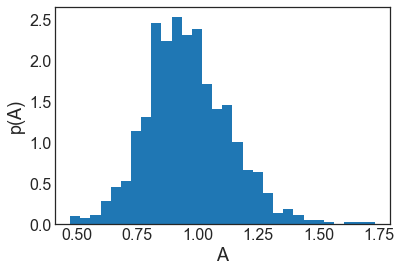

In [33]:
_=plt.hist(mcmc_results.T[0],bins=30,density=True)
plt.xlabel("A")
plt.ylabel("p(A)")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.9605437062881212
0.17253519571528106


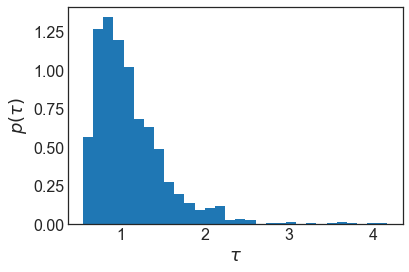

In [34]:
_=plt.hist(mcmc_results.T[1],bins=30,density=True)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

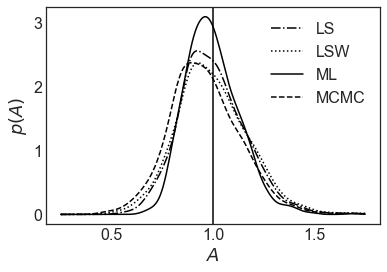

In [35]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
densityMCMC = gaussian_kde(mcmc_results.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

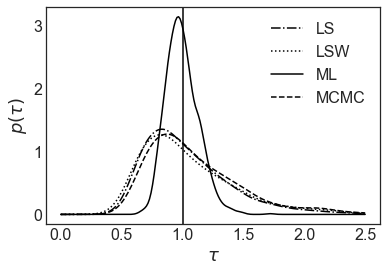

In [36]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
densityMCMC = gaussian_kde(mcmc_results.T[1])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(1000, 12)
(1000, 4)
(0.8341939876513245, 3.315384288925287e-260)


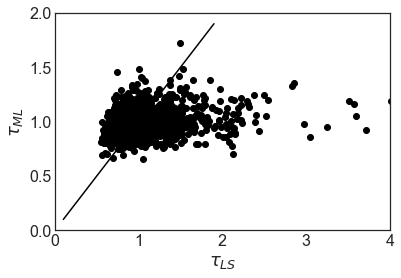

In [37]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(mcmc_results.T[1],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8380006733306882, 8.59837950237443e-265)


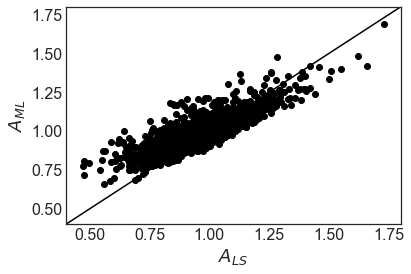

In [38]:
# amplitude correlation
plt.scatter(mcmc_results.T[0],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[0]))
plt.savefig("A_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [39]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())
print("Amplitude MCMC mean (real):",mcmc_results.T[0].mean())
print("Amplitude MCMC std (real):",mcmc_results.T[0].std())
print("Amplitude MCMC std (fit):",mcmc_results.T[2].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 4.692624086158618
Amplitude LSW std (real): 8.3673321023892
Amplitude LSW stderr (real): 0.08367332102389201
Amplitude LSW std (fit): 0.9950832668790089
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702
Amplitude MCMC mean (real): 0.9605437062881212
Amplitude MCMC std (real): 0.17253519571528106
Amplitude MCMC std (fit): 0.2031864675510421


In [40]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())
print("Decay time MCMC mean (real):",mcmc_results.T[1].mean())
print("Decay time MCMC std (real):",mcmc_results.T[1].std())
print("Decay time MCMC std (fit):",mcmc_results.T[2].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101
Decay time MCMC mean (real): 1.1199953275946877
Decay time MCMC std (real): 0.4452800421594692
Decay time MCMC std (fit): 0.2031864675510421
